In [1]:
import os

QUANTILES = [0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99] 

SPLIT = 0.9         # train/test %

FIGSIZE = (9, 6)


qL1, qL2 = 0.01, 0.10        # percentiles of predictions: lower bounds
qU1, qU2 = 1-qL1, 1-qL2,     # upper bounds derived from lower bounds
label_q1 = f'{int(qU1 * 100)} / {int(qL1 * 100)} percentile band'
label_q2 = f'{int(qU2 * 100)} / {int(qL2 * 100)} percentile band'

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import missingno as mno
import pywt
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)
import random
import numpy as np
import torch
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TransformerModel, NBEATSModel, NHiTSModel, XGBModel, RNNModel, BlockRNNModel, TFTModel
from darts.models import AutoARIMA, LinearRegressionModel, RegressionEnsembleModel
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.metrics import mape, rmse, smape
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.tuner import lr_finder
import pytorch_lightning as pl
pl.seed_everything(42, workers=True)
pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
xls = pd.ExcelFile('df_radon_combined.xlsx')

df_radon = {}
for num in xls.sheet_names[2:]:
    df_radon[num] = pd.read_excel(xls, num) 

#remove these indexes
devices = ['1', '2', '5', '9', '17', '23', '27', '28', '36', '44', '48']
for key in list(df_radon):
    if key in devices:
        del df_radon[key]

for key in df_radon:
    print(key)
    df_radon[key]['SyncDate'] = pd.to_datetime(df_radon[key]['SyncDate'])
    print(f"{df_radon[key]['SyncDate'].min()} - {df_radon[key]['SyncDate'].max()}")
    df_radon[key].sort_values(by='SyncDate', ascending=True, inplace=True)
    df_radon[key]['SyncDate'] = df_radon[key]['SyncDate'].dt.floor('H')
    df_radon[key] = df_radon[key].resample('H', on = 'SyncDate').mean()
    df_radon[key] = df_radon[key].interpolate(method='linear', limit_direction='both')
    start_time = pd.to_datetime('2022-05-11T18:29:00.000000000')
    end_time = pd.to_datetime('2023-06-06T12:00:00.000000000')
    df_radon[key] = df_radon[key][(df_radon[key].index >= start_time) & (df_radon[key].index <= end_time)]
    print(f"{df_radon[key].index.min()} - {df_radon[key].index.max()}")

3
2022-05-08 00:16:30 - 2023-06-06 12:25:38
2022-05-11 19:00:00 - 2023-06-06 12:00:00
4
2022-05-08 00:17:23 - 2023-06-06 12:26:06
2022-05-11 19:00:00 - 2023-06-06 12:00:00
7
2022-04-01 10:18:57 - 2023-06-06 12:30:25
2022-05-11 19:00:00 - 2023-06-06 12:00:00
8
2022-04-04 18:52:46 - 2023-06-06 12:27:12
2022-05-11 19:00:00 - 2023-06-06 12:00:00
10
2022-05-08 00:56:00 - 2023-06-06 23:02:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
11
2022-05-08 00:50:01 - 2023-06-07 12:13:32
2022-05-11 19:00:00 - 2023-06-06 12:00:00
13
2022-05-08 00:33:33 - 2023-06-06 23:09:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
15
2022-05-08 00:39:00 - 2023-06-06 23:59:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
16
2022-05-08 00:47:00 - 2023-06-06 23:00:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
18
2022-05-08 00:49:00 - 2023-06-06 23:07:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
19
2022-05-08 00:51:00 - 2023-06-06 23:36:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
20
2022-05-08 00:54:00 - 2023-06-07 12:40:49
20

# Radon 45

In [4]:
df = df_radon['45'].copy()

In [5]:
# Denoising the Radon signal
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

In [6]:
def wavelet_denoising(x, wavelet='db4', level=5):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    n = len(x) 
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    if len(x) % 2 ==0:
        return pywt.waverec(coeff, wavelet, mode='per')
    else:
        return pywt.waverec(coeff, wavelet, mode='per')[:n]

In [7]:
signal = df['Radon'].copy()
wavelet_name='coif9'
filtered = wavelet_denoising(signal, wavelet=wavelet_name, level=4)
df['Radon'] = filtered

In [8]:
# create time series object for target variable
ts_P = TimeSeries.from_series(df["Radon"], fill_missing_dates=True, freq="H") 

# check attributes of the time series
print("components:", ts_P.components)
print("duration:",ts_P.duration)
print("frequency:",ts_P.freq)
print("frequency:",ts_P.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_P.has_datetime_index)
print("deterministic:",ts_P.is_deterministic)
print("univariate:",ts_P.is_univariate)

components: Index(['Radon'], dtype='object', name='component')
duration: 390 days 17:00:00
frequency: <Hour>
frequency: H
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: True


In [9]:
# train/test split and scaling of target variable
ts_train, ts_test = ts_P.split_after(split_point=9210)

print("training start:", ts_train.start_time())
print("training end:", ts_train.end_time())
print("training duration:",ts_train.duration)
print("test start:", ts_test.start_time())
print("test end:", ts_test.end_time())
print("test duration:", ts_test.duration)


scalerP = Scaler()
scalerP.fit_transform(ts_train)
ts_ttrain = scalerP.transform(ts_train)
ts_ttest = scalerP.transform(ts_test)    
ts_t = scalerP.transform(ts_P)

# make sure data are of type float
ts_t = ts_t.astype(np.float32)
ts_ttrain = ts_ttrain.astype(np.float32)
ts_ttest = ts_ttest.astype(np.float32)

print("first and last row of scaled Radon time series:")
pd.options.display.float_format = '{:,.2f}'.format
ts_t.pd_dataframe().iloc[[0,-1]]

training start: 2022-05-11 19:00:00
training end: 2023-05-30 13:00:00
training duration: 383 days 18:00:00
test start: 2023-05-30 14:00:00
test end: 2023-06-06 12:00:00
test duration: 6 days 22:00:00
first and last row of scaled Radon time series:


component            Radon
SyncDate                  
2022-05-11 19:00:00   0.04
2023-06-06 12:00:00   0.05

In [10]:
print("first and last row of scaled target variable in training set: price:")
ts_ttrain.pd_dataframe().iloc[[0,-1]]

first and last row of scaled target variable in training set: price:


component            Radon
SyncDate                  
2022-05-11 19:00:00   0.04
2023-05-30 13:00:00   0.07

In [11]:
def set_seed(seed_value):
    import random
    import numpy as np
    import torch

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    pl.seed_everything(seed_value, workers=True)

In [17]:
import torch
from ray.air import session
from darts.utils.losses import SmapeLoss
from torchmetrics import MetricCollection, SymmetricMeanAbsolutePercentageError, MeanAbsolutePercentageError
def build_fit_tft_model(
    model_args,
    save_checkpoints=False,
    callbacks=None,
    save_model=False
):
#     BATCH_SIZE=64
    MAX_EPOCHS=500
    NR_EPOCHS_VAL_PERIOD=1
    set_seed(42)
    torch_metrics = MetricCollection([MeanAbsolutePercentageError(), SymmetricMeanAbsolutePercentageError()])

#     early_stopper = EarlyStopping(
#         monitor="val_loss",
#         patience=5,
#         min_delta=0.001,
#         mode='min',
#     )

#     if callbacks is None:
#         callbacks = [early_stopper]
#     else:
#         callbacks.append(early_stopper)
    
    #detect if GPU is available
#     if torch.cuda.is_available():
#         pl_trainer_kwargs = {
#             "accelerator": "gpu",
#             "gpus": -1,
#             "auto_select_gpus": True,
#             "callbacks": callbacks,
#             "enable_progress_bar":False,
#         }
#         num_workers=8
#     else:
#         pl_trainer_kwargs={
#             "callbacks": callbacks,
#         }
#         num_workers=0
    pl_trainer_kwargs={
            "accelerator": "gpu",
            "gpus":-1,
            "auto_select_gpus": True,
            "callbacks": callbacks,
            "enable_progress_bar": False,
        }
   
   

    model = TFTModel(
        input_chunk_length=model_args['in_len'],
        output_chunk_length=model_args['out_len'],
        batch_size=model_args['batch_size'],
        n_epochs=MAX_EPOCHS,
        nr_epochs_val_period=NR_EPOCHS_VAL_PERIOD,
        model_name="tft",
        hidden_size=int(model_args['out_len']+((2/3)*model_args['in_len'])),
        lstm_layers=model_args['lstm_layers'],
        num_attention_heads=model_args['num_attention_heads'],
        full_attention=model_args['full_attention'],
        feed_forward=model_args['feed_forward'],
        dropout=model_args['dropout'],
        add_relative_index=True,
        norm_type=model_args['norm_type'],
        use_static_covariates=False,
        loss_fn=SmapeLoss(),
        optimizer_kwargs={'lr': model_args['lr']},
        log_tensorboard=False,
        force_reset=True,
        save_checkpoints=save_checkpoints,
        pl_trainer_kwargs=pl_trainer_kwargs,
        torch_metrics=torch_metrics,
        random_state=42
        )
    val_len = len(ts_test)
    val_series = ts_ttrain[-((val_len) + model_args['in_len']) :]
    ts_ttrain_input = ts_ttrain[:-(val_len )]
    model.fit(  ts_ttrain_input, 
                val_series=val_series,
            )
#     model.load_from_checkpoint(f"{model_args['model']} RNN model", best=True)
    ts_tpred = model.predict(
                series = ts_ttrain,
                n = len(ts_ttest),
                verbose=True
    )
    ts_q = scalerP.inverse_transform(ts_tpred)
    q_smape = smape(ts_q, ts_test)
    session.report({'q_smape': q_smape})

In [18]:
def build_fit_tft_model_return(
    model_args,
    save_checkpoints=False,
    callbacks=None,
    save_model=False
):
#     BATCH_SIZE=64
    MAX_EPOCHS=500
    NR_EPOCHS_VAL_PERIOD=1
    set_seed(42)
    torch_metrics = MetricCollection([MeanAbsolutePercentageError(), SymmetricMeanAbsolutePercentageError()])

#     early_stopper = EarlyStopping(
#         monitor="val_loss",
#         patience=5,
#         min_delta=0.001,
#         mode='min',
#     )

#     if callbacks is None:
#         callbacks = [early_stopper]
#     else:
#         callbacks.append(early_stopper)
    
    #detect if GPU is available
#     if torch.cuda.is_available():
#         pl_trainer_kwargs = {
#             "accelerator": "gpu",
#             "gpus": -1,
#             "auto_select_gpus": True,
#             "callbacks": callbacks,
#             "enable_progress_bar":False,
#         }
#         num_workers=8
#     else:
#         pl_trainer_kwargs={
#             "callbacks": callbacks,
#         }
#         num_workers=0
    pl_trainer_kwargs={
            "accelerator": "gpu",
            "gpus":1,
            "auto_select_gpus": True,
            "callbacks": callbacks,
            "enable_progress_bar": True,
        }
   
   

    model = TFTModel(
        input_chunk_length=model_args['in_len'],
        output_chunk_length=model_args['out_len'],
        batch_size=model_args['batch_size'],
        n_epochs=MAX_EPOCHS,
        nr_epochs_val_period=NR_EPOCHS_VAL_PERIOD,
        model_name="tft",
        hidden_size=int(model_args['out_len']+((2/3)*model_args['in_len'])),
        lstm_layers=model_args['lstm_layers'],
        num_attention_heads=model_args['num_attention_heads'],
        full_attention=model_args['full_attention'],
        feed_forward=model_args['feed_forward'],
        dropout=model_args['dropout'],
        add_relative_index=True,
        norm_type=model_args['norm_type'],
        use_static_covariates=False,
        loss_fn=SmapeLoss(),
        optimizer_kwargs={'lr': model_args['lr']},
        log_tensorboard=False,
        force_reset=True,
        save_checkpoints=save_checkpoints,
        pl_trainer_kwargs=pl_trainer_kwargs,
        torch_metrics=torch_metrics,
        random_state=42
        )
    val_len = len(ts_test)
    val_series = ts_ttrain[-((val_len) + model_args['in_len']) :]
    ts_ttrain_input = ts_ttrain[:-(val_len )]
    model.fit(  ts_ttrain_input, 
                
                val_series=val_series,
                )
#     model.load_from_checkpoint(f"{model_args['model']} RNN model", best=True)
#     ts_tpred = model.predict(
#                 series = ts_ttrain,
#                 past_covariates=covF_t,
#                 n = len(ts_ttest),
#                 verbose=True
#     )
#     ts_q = scalerP.inverse_transform(ts_tpred)
#     q_smape = smape(ts_q, ts_test)
#     session.report({'q_smape': q_smape})
    return model

In [19]:
from ray import tune
from ray.tune import CLIReporter 
# from ray.tune.integration.pytorch_lightning import TuneReportCallback
from ray.tune.schedulers import ASHAScheduler, AsyncHyperBandScheduler
from ray.tune.search.optuna import OptunaSearch
from ray.tune.search import ConcurrencyLimiter
# tune_callback = TuneReportCallback(
#     {
#         "loss":"val_loss",
#         "sMAPE": "val_SymmetricMeanAbsolutePercentageError",
#     },
#     on="validation_end",
# )

early_stopper = EarlyStopping(
        monitor="val_SymmetricMeanAbsolutePercentageError",
        patience=3,
        mode='min',
    )

#define the hyperparameter search space
config = {
    "in_len": tune.randint(8,168),
    "out_len":tune.randint(1,12),
    "lstm_layers":tune.choice([1,2,3]),
    "num_attention_heads":tune.randint(2,8),
    "full_attention":tune.choice([True, False]),
    "feed_forward":tune.choice(['GLU', 'Bilinear', 'ReGLU', 'GEGLU', 'SwiGLU', 'ReLU', 'GELU', 'GatedResidualNetwork']),
    "dropout":tune.uniform(0.1, 0.5),
    "norm_type":tune.choice(['LayerNorm','RMSNorm','LayerNormNoBias']),
    "lr": tune.loguniform(1e-5, 1e-1),
    "batch_size":tune.choice([16,32,64,128,256]),
    
}

reporter = CLIReporter(
    parameter_columns=list(config.keys()),
    metric_columns=["q_smape"])
resources_per_trial = {"cpu": 5, "gpu": 0.4}

num_samples = 100

algo = OptunaSearch()

algo = ConcurrencyLimiter(algo, max_concurrent=10)

scheduler = AsyncHyperBandScheduler(max_t=100, grace_period=10, reduction_factor=2)

train_fn_with_parameters = tune.with_parameters(build_fit_tft_model, callbacks=[early_stopper])

analysis = tune.run(
    train_fn_with_parameters,
    resources_per_trial=resources_per_trial,
    metric="q_smape",
    mode="min",
    config=config,
    num_samples=num_samples,
    search_alg=algo,
    scheduler = scheduler,
    progress_reporter=reporter,
    name="tft_tune",
    raise_on_failed_trial=False
)

print("Best hyperparameters found were: ", analysis.best_config)

== Status ==
Current time: 2023-07-10 02:05:51 (running for 00:00:00.14)
Memory usage on this node: 50.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 1/100 (1 RUNNING)
+------------------------------+----------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------+-----------+-------------+-----------+--------------+
| Trial name                   | status   | loc                  |   in_len |   out_len |   lstm_layers |   num_attention_heads | full_attention   | feed_forward   |   dropout | norm_type   |        lr |   batch_size |
|------------------------------+----------+----------------------+----------+-----------+---------------+--------------

(build_fit_tft_model pid=2118190) Global seed set to 42
(build_fit_tft_model pid=2118190) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2118190)   rank_zero_deprecation(
(build_fit_tft_model pid=2118190) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2118190)   rank_zero_deprecation(
(build_fit_tft_model pid=2118190) Auto select gpus: [0]
(build_fit_tft_model pid=2118190) GPU available: True (cuda), used: True
(bui

== Status ==
Current time: 2023-07-10 02:06:00 (running for 00:00:09.74)
Memory usage on this node: 55.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 9/100 (1 PENDING, 8 RUNNING)
+------------------------------+----------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+--------------+
| Trial name                   | status   | loc                  |   in_len |   out_len |   lstm_layers |   num_attention_heads | full_attention   | feed_forward         |   dropout | norm_type       |          lr |   batch_size |
|------------------------------+----------+----------------------+--

(build_fit_tft_model pid=2118432) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2118432)   rank_zero_deprecation(
(build_fit_tft_model pid=2118432) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2118432)   rank_zero_deprecation(
(build_fit_tft_model pid=2118426) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting 

(build_fit_tft_model pid=2118417) Auto select gpus: [0]
(build_fit_tft_model pid=2118417) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2118417) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2118417) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2118417) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2118417) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2118419) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_tft_model pid=2118419) 
(build_fit_tft_model pid=2118419)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2118419) --------

(build_fit_tft_model pid=2118419) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_tft_model pid=2118419)   rank_zero_warn(
(build_fit_tft_model pid=2118419) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_tft_model pid=2118419)   rank_zero_warn(
(build_fit_tft_model pid=2118421) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(lo

(build_fit_tft_model pid=2118429) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_tft_model pid=2118429) 
(build_fit_tft_model pid=2118429)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2118429) ----------------------------------------------------------------------------------------
(build_fit_tft_model pid=2118429) 0  | criterion                         | SmapeLoss                        | 0     
(build_fit_tft_model pid=2118429) 1  | train_metrics                     | MetricCollection                 | 0     
(build_fit_tft_model pid=2118429) 2  | val_metrics                       | MetricCollection                 | 0     
(build_fit_tft_model pid=2118429) 3  | input_embeddings                  | _MultiEmbedding                  | 0     
(build_fit_tft_model pid=2118429) 4  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
(build_fit_tft_model pid=2118429) 5  | encoder_vsn              

(build_fit_tft_model pid=2118417) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_tft_model pid=2118417)   rank_zero_warn(
(build_fit_tft_model pid=2118417) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_tft_model pid=2118417)   rank_zero_warn(


== Status ==
Current time: 2023-07-10 02:06:05 (running for 00:00:14.75)
Memory usage on this node: 71.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 9/100 (1 PENDING, 8 RUNNING)
+------------------------------+----------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+--------------+
| Trial name                   | status   | loc                  |   in_len |   out_len |   lstm_layers |   num_attention_heads | full_attention   | feed_forward         |   dropout | norm_type       |          lr |   batch_size |
|------------------------------+----------+----------------------+--

== Status ==
Current time: 2023-07-10 02:06:20 (running for 00:00:29.76)
Memory usage on this node: 71.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 9/100 (1 PENDING, 8 RUNNING)
+------------------------------+----------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+--------------+
| Trial name                   | status   | loc                  |   in_len |   out_len |   lstm_layers |   num_attention_heads | full_attention   | feed_forward         |   dropout | norm_type       |          lr |   batch_size |
|------------------------------+----------+----------------------+--

(build_fit_tft_model pid=2118429) Auto select gpus: [0]
(build_fit_tft_model pid=2118429) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2118429) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2118429) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2118429) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2118429) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2118429) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.13it/s]


(build_fit_tft_model pid=2120184) Global seed set to 42
(build_fit_tft_model pid=2120184) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2120184)   rank_zero_deprecation(
(build_fit_tft_model pid=2120184) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2120184)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 02:06:26 (running for 00:00:35.38)
Memory usage on this node: 69.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 631bb87b with q_smape=200.0 and parameters={'in_len': 38, 'out_len': 8, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': False, 'feed_forward': 'ReGLU', 'dropout': 0.4036025570924623, 'norm_type': 'LayerNormNoBias', 'lr': 0.03744597647719067, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 10/100 (1 PENDING, 8 RUNNING, 1 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+---

(build_fit_tft_model pid=2120184) Auto select gpus: [0]
(build_fit_tft_model pid=2120184) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2120184) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2120184) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2120184) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2120184) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2120184) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_tft_model pid=2120184) 
(build_fit_tft_model pid=2120184)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2120184) --------

== Status ==
Current time: 2023-07-10 02:06:31 (running for 00:00:40.39)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 631bb87b with q_smape=200.0 and parameters={'in_len': 38, 'out_len': 8, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': False, 'feed_forward': 'ReGLU', 'dropout': 0.4036025570924623, 'norm_type': 'LayerNormNoBias', 'lr': 0.03744597647719067, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 10/100 (1 PENDING, 8 RUNNING, 1 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+---

(build_fit_tft_model pid=2118432) Auto select gpus: [0]
(build_fit_tft_model pid=2118432) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2118432) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2118432) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2118432) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2118432) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2118190) Auto select gpus: [0]
(build_fit_tft_model pid=2118190) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2118190) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2118190) IPU available: False, using: 0 I

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]


(build_fit_tft_model pid=2118190) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


(build_fit_tft_model pid=2120450) Global seed set to 42
(build_fit_tft_model pid=2120452) Global seed set to 42
(build_fit_tft_model pid=2120450) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2120450)   rank_zero_deprecation(
(build_fit_tft_model pid=2120450) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2120450)   rank_zero_deprecation(
(build_fit_tft_model pid=2120452) /home/ubuntu/anaconda3/lib/python3.9/site-p

== Status ==
Current time: 2023-07-10 02:06:44 (running for 00:00:53.39)
Memory usage on this node: 67.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 523b215c with q_smape=73.19827989904316 and parameters={'in_len': 110, 'out_len': 2, 'lstm_layers': 3, 'num_attention_heads': 4, 'full_attention': True, 'feed_forward': 'ReGLU', 'dropout': 0.17971049854218035, 'norm_type': 'LayerNormNoBias', 'lr': 0.011767053150780029, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 12/100 (1 PENDING, 8 RUNNING, 3 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+---

(build_fit_tft_model pid=2120450) Auto select gpus: [0]
(build_fit_tft_model pid=2120450) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2120450) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2120450) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2120450) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2120450) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2120452) Auto select gpus: [0]
(build_fit_tft_model pid=2120452) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2120452) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2120452) IPU available: False, using: 0 I

(build_fit_tft_model pid=2120452) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_tft_model pid=2120452)   rank_zero_warn(
(build_fit_tft_model pid=2120452) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_tft_model pid=2120452)   rank_zero_warn(


== Status ==
Current time: 2023-07-10 02:06:49 (running for 00:00:58.41)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 523b215c with q_smape=73.19827989904316 and parameters={'in_len': 110, 'out_len': 2, 'lstm_layers': 3, 'num_attention_heads': 4, 'full_attention': True, 'feed_forward': 'ReGLU', 'dropout': 0.17971049854218035, 'norm_type': 'LayerNormNoBias', 'lr': 0.011767053150780029, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 12/100 (1 PENDING, 8 RUNNING, 3 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+---

== Status ==
Current time: 2023-07-10 02:06:59 (running for 00:01:08.42)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 523b215c with q_smape=73.19827989904316 and parameters={'in_len': 110, 'out_len': 2, 'lstm_layers': 3, 'num_attention_heads': 4, 'full_attention': True, 'feed_forward': 'ReGLU', 'dropout': 0.17971049854218035, 'norm_type': 'LayerNormNoBias', 'lr': 0.011767053150780029, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 12/100 (1 PENDING, 8 RUNNING, 3 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+---

(build_fit_tft_model pid=2118419) Auto select gpus: [0]
(build_fit_tft_model pid=2118419) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2118419) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2118419) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2118419) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2118419) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2118419) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


(build_fit_tft_model pid=2120939) Global seed set to 42
(build_fit_tft_model pid=2120939) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2120939)   rank_zero_deprecation(
(build_fit_tft_model pid=2120939) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2120939)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 02:07:06 (running for 00:01:15.38)
Memory usage on this node: 69.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ecbc9399 with q_smape=58.391434219737945 and parameters={'in_len': 109, 'out_len': 8, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.13017871179550494, 'norm_type': 'LayerNorm', 'lr': 0.0016586928951777629, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 13/100 (1 PENDING, 8 RUNNING, 4 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2120939) Auto select gpus: [0]
(build_fit_tft_model pid=2120939) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2120939) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2120939) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2120939) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2120939) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2120939) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_tft_model pid=2120939) 
(build_fit_tft_model pid=2120939)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2120939) --------

== Status ==
Current time: 2023-07-10 02:07:11 (running for 00:01:20.39)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ecbc9399 with q_smape=58.391434219737945 and parameters={'in_len': 109, 'out_len': 8, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.13017871179550494, 'norm_type': 'LayerNorm', 'lr': 0.0016586928951777629, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 13/100 (1 PENDING, 8 RUNNING, 4 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2120184) Auto select gpus: [0]
(build_fit_tft_model pid=2120184) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2120184) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2120184) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2120184) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2120184) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2120184) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
== Status ==
Current time: 2023-07-10 02:07:16 (running for 00:01:25.40)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ecbc9399 with q_smape=58.391434219737945 and parameters={'in_len': 109, 'out_len': 8, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.13017871179550494, 'norm_type': 'LayerNorm', 'lr': 0.0016586928951777629, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 13/100 (1 PENDING, 8 RUNNING, 4 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+----------------

(build_fit_tft_model pid=2121236) Global seed set to 42
(build_fit_tft_model pid=2121236) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2121236)   rank_zero_deprecation(
(build_fit_tft_model pid=2121236) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2121236)   rank_zero_deprecation(
(build_fit_tft_model pid=2118421) Auto select gpus: [0]
(build_fit_tft_model pid=2118421) GPU available: True (cuda), used: True
(bui

== Status ==
Current time: 2023-07-10 02:07:22 (running for 00:01:31.36)
Memory usage on this node: 69.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ecbc9399 with q_smape=58.391434219737945 and parameters={'in_len': 109, 'out_len': 8, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.13017871179550494, 'norm_type': 'LayerNorm', 'lr': 0.0016586928951777629, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 14/100 (1 PENDING, 8 RUNNING, 5 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2121236) Auto select gpus: [0]
(build_fit_tft_model pid=2121236) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2121236) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2121236) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2121236) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2121236) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2121236) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_tft_model pid=2121236) 
(build_fit_tft_model pid=2121236)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2121236) --------

== Status ==
Current time: 2023-07-10 02:07:28 (running for 00:01:37.39)
Memory usage on this node: 69.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ecbc9399 with q_smape=58.391434219737945 and parameters={'in_len': 109, 'out_len': 8, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.13017871179550494, 'norm_type': 'LayerNorm', 'lr': 0.0016586928951777629, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 15/100 (1 PENDING, 8 RUNNING, 6 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2121474) Auto select gpus: [0]
(build_fit_tft_model pid=2121474) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2121474) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2121474) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2121474) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2121474) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2121474) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_tft_model pid=2121474) 
(build_fit_tft_model pid=2121474)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2121474) --------

== Status ==
Current time: 2023-07-10 02:07:33 (running for 00:01:42.40)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ecbc9399 with q_smape=58.391434219737945 and parameters={'in_len': 109, 'out_len': 8, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.13017871179550494, 'norm_type': 'LayerNorm', 'lr': 0.0016586928951777629, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 15/100 (1 PENDING, 8 RUNNING, 6 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2120939) Auto select gpus: [0]
(build_fit_tft_model pid=2120939) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2120939) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2120939) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2120939) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2120939) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2120939) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


(build_fit_tft_model pid=2121729) Global seed set to 42
(build_fit_tft_model pid=2121729) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2121729)   rank_zero_deprecation(
(build_fit_tft_model pid=2121729) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2121729)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 02:07:40 (running for 00:01:49.39)
Memory usage on this node: 69.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ecbc9399 with q_smape=58.391434219737945 and parameters={'in_len': 109, 'out_len': 8, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.13017871179550494, 'norm_type': 'LayerNorm', 'lr': 0.0016586928951777629, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 16/100 (1 PENDING, 8 RUNNING, 7 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2121729) Auto select gpus: [0]
(build_fit_tft_model pid=2121729) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2121729) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2121729) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2121729) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2121729) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2121729) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_tft_model pid=2121729) 
(build_fit_tft_model pid=2121729)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2121729) --------

== Status ==
Current time: 2023-07-10 02:07:45 (running for 00:01:54.40)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ecbc9399 with q_smape=58.391434219737945 and parameters={'in_len': 109, 'out_len': 8, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.13017871179550494, 'norm_type': 'LayerNorm', 'lr': 0.0016586928951777629, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 16/100 (1 PENDING, 8 RUNNING, 7 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2120450) Auto select gpus: [0]
(build_fit_tft_model pid=2120450) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2120450) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2120450) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2120450) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2120450) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2120450) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


(build_fit_tft_model pid=2121982) Global seed set to 42
(build_fit_tft_model pid=2121982) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2121982)   rank_zero_deprecation(
(build_fit_tft_model pid=2121982) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2121982)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 02:07:58 (running for 00:02:07.39)
Memory usage on this node: 69.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ecbc9399 with q_smape=58.391434219737945 and parameters={'in_len': 109, 'out_len': 8, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.13017871179550494, 'norm_type': 'LayerNorm', 'lr': 0.0016586928951777629, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 17/100 (1 PENDING, 8 RUNNING, 8 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2121982) Auto select gpus: [0]
(build_fit_tft_model pid=2121982) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2121982) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2121982) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2121982) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2121982) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2121982) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_tft_model pid=2121982) 
(build_fit_tft_model pid=2121982)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2121982) --------

== Status ==
Current time: 2023-07-10 02:08:03 (running for 00:02:12.40)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ecbc9399 with q_smape=58.391434219737945 and parameters={'in_len': 109, 'out_len': 8, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.13017871179550494, 'norm_type': 'LayerNorm', 'lr': 0.0016586928951777629, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 17/100 (1 PENDING, 8 RUNNING, 8 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2121474) Auto select gpus: [0]
(build_fit_tft_model pid=2121474) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2121474) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2121474) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2121474) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2121474) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2121474) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


(build_fit_tft_model pid=2122239) Global seed set to 42
(build_fit_tft_model pid=2122239) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2122239)   rank_zero_deprecation(
(build_fit_tft_model pid=2122239) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2122239)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 02:08:18 (running for 00:02:27.39)
Memory usage on this node: 69.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ecbc9399 with q_smape=58.391434219737945 and parameters={'in_len': 109, 'out_len': 8, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.13017871179550494, 'norm_type': 'LayerNorm', 'lr': 0.0016586928951777629, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 18/100 (1 PENDING, 8 RUNNING, 9 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2122239) Auto select gpus: [0]
(build_fit_tft_model pid=2122239) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2122239) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2122239) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2122239) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2122239) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2122239) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_tft_model pid=2122239) 
(build_fit_tft_model pid=2122239)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2122239) --------

== Status ==
Current time: 2023-07-10 02:08:23 (running for 00:02:32.40)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ecbc9399 with q_smape=58.391434219737945 and parameters={'in_len': 109, 'out_len': 8, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.13017871179550494, 'norm_type': 'LayerNorm', 'lr': 0.0016586928951777629, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 18/100 (1 PENDING, 8 RUNNING, 9 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:08:33 (running for 00:02:42.42)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ecbc9399 with q_smape=58.391434219737945 and parameters={'in_len': 109, 'out_len': 8, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.13017871179550494, 'norm_type': 'LayerNorm', 'lr': 0.0016586928951777629, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 18/100 (1 PENDING, 8 RUNNING, 9 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2120452) Auto select gpus: [0]
(build_fit_tft_model pid=2120452) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2120452) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2120452) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2120452) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2120452) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2120452) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


(build_fit_tft_model pid=2122546) Global seed set to 42
(build_fit_tft_model pid=2122546) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2122546)   rank_zero_deprecation(
(build_fit_tft_model pid=2122546) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2122546)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 02:08:42 (running for 00:02:51.42)
Memory usage on this node: 69.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ecbc9399 with q_smape=58.391434219737945 and parameters={'in_len': 109, 'out_len': 8, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.13017871179550494, 'norm_type': 'LayerNorm', 'lr': 0.0016586928951777629, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 19/100 (1 PENDING, 8 RUNNING, 10 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+------

(build_fit_tft_model pid=2122546) Auto select gpus: [0]
(build_fit_tft_model pid=2122546) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2122546) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2122546) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2122546) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2122546) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2122546) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_tft_model pid=2122546) 
(build_fit_tft_model pid=2122546)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2122546) --------

== Status ==
Current time: 2023-07-10 02:08:47 (running for 00:02:56.44)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ecbc9399 with q_smape=58.391434219737945 and parameters={'in_len': 109, 'out_len': 8, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.13017871179550494, 'norm_type': 'LayerNorm', 'lr': 0.0016586928951777629, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 19/100 (1 PENDING, 8 RUNNING, 10 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+------

(build_fit_tft_model pid=2118426) Auto select gpus: [0]
(build_fit_tft_model pid=2118426) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2118426) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2118426) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2118426) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2118426) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2118426) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.64it/s]


(build_fit_tft_model pid=2122798) Global seed set to 42
(build_fit_tft_model pid=2122798) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2122798)   rank_zero_deprecation(
(build_fit_tft_model pid=2122798) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2122798)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 02:08:54 (running for 00:03:03.41)
Memory usage on this node: 69.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ecbc9399 with q_smape=58.391434219737945 and parameters={'in_len': 109, 'out_len': 8, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.13017871179550494, 'norm_type': 'LayerNorm', 'lr': 0.0016586928951777629, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 20/100 (1 PENDING, 8 RUNNING, 11 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+------

(build_fit_tft_model pid=2122798) Auto select gpus: [0]
(build_fit_tft_model pid=2122798) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2122798) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2122798) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2122798) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2122798) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2122798) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_tft_model pid=2122798) 
(build_fit_tft_model pid=2122798)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2122798) --------

== Status ==
Current time: 2023-07-10 02:08:59 (running for 00:03:08.42)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ecbc9399 with q_smape=58.391434219737945 and parameters={'in_len': 109, 'out_len': 8, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.13017871179550494, 'norm_type': 'LayerNorm', 'lr': 0.0016586928951777629, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 20/100 (1 PENDING, 8 RUNNING, 11 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+------

== Status ==
Current time: 2023-07-10 02:09:09 (running for 00:03:18.43)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ecbc9399 with q_smape=58.391434219737945 and parameters={'in_len': 109, 'out_len': 8, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.13017871179550494, 'norm_type': 'LayerNorm', 'lr': 0.0016586928951777629, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 20/100 (1 PENDING, 8 RUNNING, 11 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+------

(build_fit_tft_model pid=2121982) Auto select gpus: [0]
(build_fit_tft_model pid=2121982) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2121982) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2121982) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2121982) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2121982) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2121982) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]


(build_fit_tft_model pid=2124422) Global seed set to 42
(build_fit_tft_model pid=2124422) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2124422)   rank_zero_deprecation(
(build_fit_tft_model pid=2124422) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2124422)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 02:09:16 (running for 00:03:25.41)
Memory usage on this node: 69.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ecbc9399 with q_smape=58.391434219737945 and parameters={'in_len': 109, 'out_len': 8, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.13017871179550494, 'norm_type': 'LayerNorm', 'lr': 0.0016586928951777629, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 21/100 (1 PENDING, 8 RUNNING, 12 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+------

(build_fit_tft_model pid=2124422) Auto select gpus: [0]
(build_fit_tft_model pid=2124422) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2124422) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2124422) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2124422) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2124422) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2124422) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_tft_model pid=2124422) 
(build_fit_tft_model pid=2124422)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2124422) --------

== Status ==
Current time: 2023-07-10 02:09:21 (running for 00:03:30.43)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ecbc9399 with q_smape=58.391434219737945 and parameters={'in_len': 109, 'out_len': 8, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.13017871179550494, 'norm_type': 'LayerNorm', 'lr': 0.0016586928951777629, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 21/100 (1 PENDING, 8 RUNNING, 12 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+------

== Status ==
Current time: 2023-07-10 02:09:31 (running for 00:03:40.45)
Memory usage on this node: 71.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ecbc9399 with q_smape=58.391434219737945 and parameters={'in_len': 109, 'out_len': 8, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.13017871179550494, 'norm_type': 'LayerNorm', 'lr': 0.0016586928951777629, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 21/100 (1 PENDING, 8 RUNNING, 12 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+------

== Status ==
Current time: 2023-07-10 02:09:41 (running for 00:03:50.46)
Memory usage on this node: 71.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ecbc9399 with q_smape=58.391434219737945 and parameters={'in_len': 109, 'out_len': 8, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.13017871179550494, 'norm_type': 'LayerNorm', 'lr': 0.0016586928951777629, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 21/100 (1 PENDING, 8 RUNNING, 12 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+------

== Status ==
Current time: 2023-07-10 02:09:51 (running for 00:04:00.48)
Memory usage on this node: 71.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ecbc9399 with q_smape=58.391434219737945 and parameters={'in_len': 109, 'out_len': 8, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.13017871179550494, 'norm_type': 'LayerNorm', 'lr': 0.0016586928951777629, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 21/100 (1 PENDING, 8 RUNNING, 12 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+------

(build_fit_tft_model pid=2121236) Auto select gpus: [0]
(build_fit_tft_model pid=2121236) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2121236) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2121236) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2121236) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2121236) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.54it/s]


(build_fit_tft_model pid=2121236) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


== Status ==
Current time: 2023-07-10 02:09:57 (running for 00:04:06.40)
Memory usage on this node: 68.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 742f3e27 with q_smape=27.44375540594598 and parameters={'in_len': 21, 'out_len': 11, 'lstm_layers': 3, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'ReLU', 'dropout': 0.31597619441841773, 'norm_type': 'LayerNormNoBias', 'lr': 1.682950935402536e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 21/100 (8 RUNNING, 13 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+

(build_fit_tft_model pid=2126150) Global seed set to 42
(build_fit_tft_model pid=2126150) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2126150)   rank_zero_deprecation(
(build_fit_tft_model pid=2126150) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2126150)   rank_zero_deprecation(
(build_fit_tft_model pid=2126150) Auto select gpus: [0]
(build_fit_tft_model pid=2126150) GPU available: True (cuda), used: True
(bui

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2118417) Auto select gpus: [0]
(build_fit_tft_model pid=2118417) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2118417) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2118417) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2118417) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2118417) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2118417) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


== Status ==
Current time: 2023-07-10 02:10:04 (running for 00:04:12.79)
Memory usage on this node: 70.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 742f3e27 with q_smape=27.44375540594598 and parameters={'in_len': 21, 'out_len': 11, 'lstm_layers': 3, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'ReLU', 'dropout': 0.31597619441841773, 'norm_type': 'LayerNormNoBias', 'lr': 1.682950935402536e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 22/100 (1 PENDING, 8 RUNNING, 13 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+---

(build_fit_tft_model pid=2126150) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_tft_model pid=2126150) 
(build_fit_tft_model pid=2126150)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2126150) ----------------------------------------------------------------------------------------
(build_fit_tft_model pid=2126150) 0  | criterion                         | SmapeLoss                        | 0     
(build_fit_tft_model pid=2126150) 1  | train_metrics                     | MetricCollection                 | 0     
(build_fit_tft_model pid=2126150) 2  | val_metrics                       | MetricCollection                 | 0     
(build_fit_tft_model pid=2126150) 3  | input_embeddings                  | _MultiEmbedding                  | 0     
(build_fit_tft_model pid=2126150) 4  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
(build_fit_tft_model pid=2126150) 5  | encoder_vsn              

== Status ==
Current time: 2023-07-10 02:10:09 (running for 00:04:18.43)
Memory usage on this node: 69.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 742f3e27 with q_smape=27.44375540594598 and parameters={'in_len': 21, 'out_len': 11, 'lstm_layers': 3, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'ReLU', 'dropout': 0.31597619441841773, 'norm_type': 'LayerNormNoBias', 'lr': 1.682950935402536e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 23/100 (1 PENDING, 8 RUNNING, 14 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+---

(build_fit_tft_model pid=2126393) Auto select gpus: [0]
(build_fit_tft_model pid=2126393) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2126393) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2126393) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2126393) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2126393) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2126393) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_tft_model pid=2126393) 
(build_fit_tft_model pid=2126393)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2126393) --------

== Status ==
Current time: 2023-07-10 02:10:14 (running for 00:04:23.44)
Memory usage on this node: 71.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 742f3e27 with q_smape=27.44375540594598 and parameters={'in_len': 21, 'out_len': 11, 'lstm_layers': 3, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'ReLU', 'dropout': 0.31597619441841773, 'norm_type': 'LayerNormNoBias', 'lr': 1.682950935402536e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 23/100 (1 PENDING, 8 RUNNING, 14 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+---

(build_fit_tft_model pid=2122546) Auto select gpus: [0]
(build_fit_tft_model pid=2122546) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2122546) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2122546) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2122546) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2122546) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2122546) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


(build_fit_tft_model pid=2126646) Global seed set to 42
(build_fit_tft_model pid=2126646) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2126646)   rank_zero_deprecation(
(build_fit_tft_model pid=2126646) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2126646)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 02:10:23 (running for 00:04:32.42)
Memory usage on this node: 69.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 742f3e27 with q_smape=27.44375540594598 and parameters={'in_len': 21, 'out_len': 11, 'lstm_layers': 3, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'ReLU', 'dropout': 0.31597619441841773, 'norm_type': 'LayerNormNoBias', 'lr': 1.682950935402536e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 24/100 (1 PENDING, 8 RUNNING, 15 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+---

(build_fit_tft_model pid=2126646) Auto select gpus: [0]
(build_fit_tft_model pid=2126646) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2126646) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2126646) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2126646) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2126646) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2126646) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_tft_model pid=2126646) 
(build_fit_tft_model pid=2126646)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2126646) --------

== Status ==
Current time: 2023-07-10 02:10:28 (running for 00:04:37.44)
Memory usage on this node: 71.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 742f3e27 with q_smape=27.44375540594598 and parameters={'in_len': 21, 'out_len': 11, 'lstm_layers': 3, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'ReLU', 'dropout': 0.31597619441841773, 'norm_type': 'LayerNormNoBias', 'lr': 1.682950935402536e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 24/100 (1 PENDING, 8 RUNNING, 15 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+---

(build_fit_tft_model pid=2124422) Auto select gpus: [0]
(build_fit_tft_model pid=2124422) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2124422) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2124422) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2124422) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2124422) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2124422) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]pid=2124422) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


(build_fit_tft_model pid=2126905) Global seed set to 42
(build_fit_tft_model pid=2126905) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2126905)   rank_zero_deprecation(
(build_fit_tft_model pid=2126905) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2126905)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 02:10:41 (running for 00:04:50.43)
Memory usage on this node: 69.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 742f3e27 with q_smape=27.44375540594598 and parameters={'in_len': 21, 'out_len': 11, 'lstm_layers': 3, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'ReLU', 'dropout': 0.31597619441841773, 'norm_type': 'LayerNormNoBias', 'lr': 1.682950935402536e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 25/100 (1 PENDING, 8 RUNNING, 16 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+---

(build_fit_tft_model pid=2126905) Auto select gpus: [0]
(build_fit_tft_model pid=2126905) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2126905) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2126905) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2126905) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2126905) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2126905) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_tft_model pid=2126905) 
(build_fit_tft_model pid=2126905)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2126905) --------

== Status ==
Current time: 2023-07-10 02:10:46 (running for 00:04:55.44)
Memory usage on this node: 71.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 742f3e27 with q_smape=27.44375540594598 and parameters={'in_len': 21, 'out_len': 11, 'lstm_layers': 3, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'ReLU', 'dropout': 0.31597619441841773, 'norm_type': 'LayerNormNoBias', 'lr': 1.682950935402536e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 25/100 (1 PENDING, 8 RUNNING, 16 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+---

== Status ==
Current time: 2023-07-10 02:10:56 (running for 00:05:05.46)
Memory usage on this node: 71.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 742f3e27 with q_smape=27.44375540594598 and parameters={'in_len': 21, 'out_len': 11, 'lstm_layers': 3, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'ReLU', 'dropout': 0.31597619441841773, 'norm_type': 'LayerNormNoBias', 'lr': 1.682950935402536e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 25/100 (1 PENDING, 8 RUNNING, 16 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+---

(build_fit_tft_model pid=2126150) Auto select gpus: [0]
(build_fit_tft_model pid=2126150) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2126150) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2126150) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2126150) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2126150) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2126150) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]
== Status ==
Current time: 2023-07-10 02:11:05 (running for 00:05:14.44)
Memory usage on this node: 68.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 742f3e27 with q_smape=27.44375540594598 and parameters={'in_len': 21, 'out_len': 11, 'lstm_layers': 3, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'ReLU', 'dropout': 0.31597619441841773, 'norm_type': 'LayerNormNoBias', 'lr': 1.682950935402536e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 26/100 (1 PENDING, 8 RUNNING, 17 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+----

(build_fit_tft_model pid=2127168) Global seed set to 42
(build_fit_tft_model pid=2127168) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2127168)   rank_zero_deprecation(
(build_fit_tft_model pid=2127168) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2127168)   rank_zero_deprecation(
(build_fit_tft_model pid=2127168) Auto select gpus: [0]
(build_fit_tft_model pid=2127168) GPU available: True (cuda), used: True
(bui

== Status ==
Current time: 2023-07-10 02:11:10 (running for 00:05:19.51)
Memory usage on this node: 71.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 742f3e27 with q_smape=27.44375540594598 and parameters={'in_len': 21, 'out_len': 11, 'lstm_layers': 3, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'ReLU', 'dropout': 0.31597619441841773, 'norm_type': 'LayerNormNoBias', 'lr': 1.682950935402536e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 26/100 (1 PENDING, 8 RUNNING, 17 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+---

== Status ==
Current time: 2023-07-10 02:11:20 (running for 00:05:29.52)
Memory usage on this node: 71.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 742f3e27 with q_smape=27.44375540594598 and parameters={'in_len': 21, 'out_len': 11, 'lstm_layers': 3, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'ReLU', 'dropout': 0.31597619441841773, 'norm_type': 'LayerNormNoBias', 'lr': 1.682950935402536e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 26/100 (1 PENDING, 8 RUNNING, 17 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+---

== Status ==
Current time: 2023-07-10 02:11:30 (running for 00:05:39.54)
Memory usage on this node: 71.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 742f3e27 with q_smape=27.44375540594598 and parameters={'in_len': 21, 'out_len': 11, 'lstm_layers': 3, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'ReLU', 'dropout': 0.31597619441841773, 'norm_type': 'LayerNormNoBias', 'lr': 1.682950935402536e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 26/100 (1 PENDING, 8 RUNNING, 17 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+---

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2121729) Auto select gpus: [0]
(build_fit_tft_model pid=2121729) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2121729) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2121729) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2121729) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2121729) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2121729) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


(build_fit_tft_model pid=2127491) Global seed set to 42
(build_fit_tft_model pid=2127491) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2127491)   rank_zero_deprecation(
(build_fit_tft_model pid=2127491) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2127491)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 02:11:43 (running for 00:05:52.43)
Memory usage on this node: 69.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 742f3e27 with q_smape=27.44375540594598 and parameters={'in_len': 21, 'out_len': 11, 'lstm_layers': 3, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'ReLU', 'dropout': 0.31597619441841773, 'norm_type': 'LayerNormNoBias', 'lr': 1.682950935402536e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 27/100 (1 PENDING, 8 RUNNING, 18 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+---

(build_fit_tft_model pid=2127491) Auto select gpus: [0]
(build_fit_tft_model pid=2127491) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2127491) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2127491) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2127491) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2127491) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2127491) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_tft_model pid=2127491) 
(build_fit_tft_model pid=2127491)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2127491) --------

== Status ==
Current time: 2023-07-10 02:11:48 (running for 00:05:57.45)
Memory usage on this node: 71.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 742f3e27 with q_smape=27.44375540594598 and parameters={'in_len': 21, 'out_len': 11, 'lstm_layers': 3, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'ReLU', 'dropout': 0.31597619441841773, 'norm_type': 'LayerNormNoBias', 'lr': 1.682950935402536e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 27/100 (1 PENDING, 8 RUNNING, 18 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+---

== Status ==
Current time: 2023-07-10 02:11:58 (running for 00:06:07.46)
Memory usage on this node: 71.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 742f3e27 with q_smape=27.44375540594598 and parameters={'in_len': 21, 'out_len': 11, 'lstm_layers': 3, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'ReLU', 'dropout': 0.31597619441841773, 'norm_type': 'LayerNormNoBias', 'lr': 1.682950935402536e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 27/100 (1 PENDING, 8 RUNNING, 18 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+---

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2118424) Auto select gpus: [0]
(build_fit_tft_model pid=2118424) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2118424) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2118424) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2118424) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2118424) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2118424) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.15it/s]
== Status ==
Current time: 2023-07-10 02:12:10 (running for 00:06:19.42)
Memory usage on this node: 68.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2ce7430d with q_smape=21.14855291239264 and parameters={'in_len': 74, 'out_len': 5, 'lstm_layers': 1, 'num_attention_heads': 5, 'full_attention': False, 'feed_forward': 'GEGLU', 'dropout': 0.28266622409682285, 'norm_type': 'LayerNormNoBias', 'lr': 0.0003222294548441543, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 27/100 (8 RUNNING, 19 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+--------------

(build_fit_tft_model pid=2127851) Global seed set to 42
(build_fit_tft_model pid=2127851) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2127851)   rank_zero_deprecation(
(build_fit_tft_model pid=2127851) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2127851)   rank_zero_deprecation(
(build_fit_tft_model pid=2127851) Auto select gpus: [0]
(build_fit_tft_model pid=2127851) GPU available: True (cuda), used: True
(bui

== Status ==
Current time: 2023-07-10 02:12:20 (running for 00:06:29.05)
Memory usage on this node: 71.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2ce7430d with q_smape=21.14855291239264 and parameters={'in_len': 74, 'out_len': 5, 'lstm_layers': 1, 'num_attention_heads': 5, 'full_attention': False, 'feed_forward': 'GEGLU', 'dropout': 0.28266622409682285, 'norm_type': 'LayerNormNoBias', 'lr': 0.0003222294548441543, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 28/100 (1 PENDING, 8 RUNNING, 19 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--

(build_fit_tft_model pid=2127168) Auto select gpus: [0]
(build_fit_tft_model pid=2127168) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2127168) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2127168) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2127168) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2127168) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Predicting: 0it [00:00, ?it/s]pid=2122239) 
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2122239) Auto select gpus: [0]
(build_fit_tft_model pid=2122239) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2122239) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2122239) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2122239) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2122239) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2122239) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_tft_model pid=2127168) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


(build_fit_tft_model pid=2128105) Global seed set to 42
(build_fit_tft_model pid=2128105) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2128105)   rank_zero_deprecation(
(build_fit_tft_model pid=2128105) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2128105)   rank_zero_deprecation(
(build_fit_tft_model pid=2128107) Global seed set to 42
(build_fit_tft_model pid=2128107) /home/ubuntu/anaconda3/lib/python3.9/site-p

== Status ==
Current time: 2023-07-10 02:12:27 (running for 00:06:36.48)
Memory usage on this node: 67.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2ce7430d with q_smape=21.14855291239264 and parameters={'in_len': 74, 'out_len': 5, 'lstm_layers': 1, 'num_attention_heads': 5, 'full_attention': False, 'feed_forward': 'GEGLU', 'dropout': 0.28266622409682285, 'norm_type': 'LayerNormNoBias', 'lr': 0.0003222294548441543, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 30/100 (1 PENDING, 8 RUNNING, 21 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--

(build_fit_tft_model pid=2128105) Auto select gpus: [0]
(build_fit_tft_model pid=2128105) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2128105) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2128105) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2128105) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2128105) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2128107) Auto select gpus: [0]
(build_fit_tft_model pid=2128107) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2128107) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2128107) IPU available: False, using: 0 I

(build_fit_tft_model pid=2128107) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_tft_model pid=2128107)   rank_zero_warn(
(build_fit_tft_model pid=2128107) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_tft_model pid=2128107)   rank_zero_warn(
(build_fit_tft_model pid=2128107) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logg

== Status ==
Current time: 2023-07-10 02:12:32 (running for 00:06:41.49)
Memory usage on this node: 71.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2ce7430d with q_smape=21.14855291239264 and parameters={'in_len': 74, 'out_len': 5, 'lstm_layers': 1, 'num_attention_heads': 5, 'full_attention': False, 'feed_forward': 'GEGLU', 'dropout': 0.28266622409682285, 'norm_type': 'LayerNormNoBias', 'lr': 0.0003222294548441543, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 30/100 (1 PENDING, 8 RUNNING, 21 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--

== Status ==
Current time: 2023-07-10 02:12:42 (running for 00:06:51.51)
Memory usage on this node: 71.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2ce7430d with q_smape=21.14855291239264 and parameters={'in_len': 74, 'out_len': 5, 'lstm_layers': 1, 'num_attention_heads': 5, 'full_attention': False, 'feed_forward': 'GEGLU', 'dropout': 0.28266622409682285, 'norm_type': 'LayerNormNoBias', 'lr': 0.0003222294548441543, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 30/100 (1 PENDING, 8 RUNNING, 21 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--

== Status ==
Current time: 2023-07-10 02:12:52 (running for 00:07:01.52)
Memory usage on this node: 71.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2ce7430d with q_smape=21.14855291239264 and parameters={'in_len': 74, 'out_len': 5, 'lstm_layers': 1, 'num_attention_heads': 5, 'full_attention': False, 'feed_forward': 'GEGLU', 'dropout': 0.28266622409682285, 'norm_type': 'LayerNormNoBias', 'lr': 0.0003222294548441543, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 30/100 (1 PENDING, 8 RUNNING, 21 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--

== Status ==
Current time: 2023-07-10 02:13:02 (running for 00:07:11.54)
Memory usage on this node: 71.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2ce7430d with q_smape=21.14855291239264 and parameters={'in_len': 74, 'out_len': 5, 'lstm_layers': 1, 'num_attention_heads': 5, 'full_attention': False, 'feed_forward': 'GEGLU', 'dropout': 0.28266622409682285, 'norm_type': 'LayerNormNoBias', 'lr': 0.0003222294548441543, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 30/100 (1 PENDING, 8 RUNNING, 21 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--

== Status ==
Current time: 2023-07-10 02:13:12 (running for 00:07:21.55)
Memory usage on this node: 71.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2ce7430d with q_smape=21.14855291239264 and parameters={'in_len': 74, 'out_len': 5, 'lstm_layers': 1, 'num_attention_heads': 5, 'full_attention': False, 'feed_forward': 'GEGLU', 'dropout': 0.28266622409682285, 'norm_type': 'LayerNormNoBias', 'lr': 0.0003222294548441543, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 30/100 (1 PENDING, 8 RUNNING, 21 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--

== Status ==
Current time: 2023-07-10 02:13:22 (running for 00:07:31.57)
Memory usage on this node: 71.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2ce7430d with q_smape=21.14855291239264 and parameters={'in_len': 74, 'out_len': 5, 'lstm_layers': 1, 'num_attention_heads': 5, 'full_attention': False, 'feed_forward': 'GEGLU', 'dropout': 0.28266622409682285, 'norm_type': 'LayerNormNoBias', 'lr': 0.0003222294548441543, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 30/100 (1 PENDING, 8 RUNNING, 21 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--

(build_fit_tft_model pid=2126646) Auto select gpus: [0]
(build_fit_tft_model pid=2126646) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2126646) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2126646) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2126646) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2126646) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.76it/s]


(build_fit_tft_model pid=2126646) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


== Status ==
Current time: 2023-07-10 02:13:28 (running for 00:07:37.42)
Memory usage on this node: 68.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2ce7430d with q_smape=21.14855291239264 and parameters={'in_len': 74, 'out_len': 5, 'lstm_layers': 1, 'num_attention_heads': 5, 'full_attention': False, 'feed_forward': 'GEGLU', 'dropout': 0.28266622409682285, 'norm_type': 'LayerNormNoBias', 'lr': 0.0003222294548441543, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 30/100 (8 RUNNING, 22 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------

(build_fit_tft_model pid=2128642) Global seed set to 42
(build_fit_tft_model pid=2128642) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2128642)   rank_zero_deprecation(
(build_fit_tft_model pid=2128642) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2128642)   rank_zero_deprecation(
(build_fit_tft_model pid=2128642) Auto select gpus: [0]
(build_fit_tft_model pid=2128642) GPU available: True (cuda), used: True
(bui

== Status ==
Current time: 2023-07-10 02:13:38 (running for 00:07:47.05)
Memory usage on this node: 71.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2ce7430d with q_smape=21.14855291239264 and parameters={'in_len': 74, 'out_len': 5, 'lstm_layers': 1, 'num_attention_heads': 5, 'full_attention': False, 'feed_forward': 'GEGLU', 'dropout': 0.28266622409682285, 'norm_type': 'LayerNormNoBias', 'lr': 0.0003222294548441543, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 31/100 (1 PENDING, 8 RUNNING, 22 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--

== Status ==
Current time: 2023-07-10 02:13:48 (running for 00:07:57.07)
Memory usage on this node: 71.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2ce7430d with q_smape=21.14855291239264 and parameters={'in_len': 74, 'out_len': 5, 'lstm_layers': 1, 'num_attention_heads': 5, 'full_attention': False, 'feed_forward': 'GEGLU', 'dropout': 0.28266622409682285, 'norm_type': 'LayerNormNoBias', 'lr': 0.0003222294548441543, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 31/100 (1 PENDING, 8 RUNNING, 22 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--

== Status ==
Current time: 2023-07-10 02:13:58 (running for 00:08:07.09)
Memory usage on this node: 71.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2ce7430d with q_smape=21.14855291239264 and parameters={'in_len': 74, 'out_len': 5, 'lstm_layers': 1, 'num_attention_heads': 5, 'full_attention': False, 'feed_forward': 'GEGLU', 'dropout': 0.28266622409682285, 'norm_type': 'LayerNormNoBias', 'lr': 0.0003222294548441543, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 31/100 (1 PENDING, 8 RUNNING, 22 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--

== Status ==
Current time: 2023-07-10 02:14:08 (running for 00:08:17.10)
Memory usage on this node: 71.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2ce7430d with q_smape=21.14855291239264 and parameters={'in_len': 74, 'out_len': 5, 'lstm_layers': 1, 'num_attention_heads': 5, 'full_attention': False, 'feed_forward': 'GEGLU', 'dropout': 0.28266622409682285, 'norm_type': 'LayerNormNoBias', 'lr': 0.0003222294548441543, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 31/100 (1 PENDING, 8 RUNNING, 22 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--

== Status ==
Current time: 2023-07-10 02:14:18 (running for 00:08:27.12)
Memory usage on this node: 71.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2ce7430d with q_smape=21.14855291239264 and parameters={'in_len': 74, 'out_len': 5, 'lstm_layers': 1, 'num_attention_heads': 5, 'full_attention': False, 'feed_forward': 'GEGLU', 'dropout': 0.28266622409682285, 'norm_type': 'LayerNormNoBias', 'lr': 0.0003222294548441543, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 31/100 (1 PENDING, 8 RUNNING, 22 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--

== Status ==
Current time: 2023-07-10 02:14:28 (running for 00:08:37.14)
Memory usage on this node: 71.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2ce7430d with q_smape=21.14855291239264 and parameters={'in_len': 74, 'out_len': 5, 'lstm_layers': 1, 'num_attention_heads': 5, 'full_attention': False, 'feed_forward': 'GEGLU', 'dropout': 0.28266622409682285, 'norm_type': 'LayerNormNoBias', 'lr': 0.0003222294548441543, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 31/100 (1 PENDING, 8 RUNNING, 22 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2122798) Auto select gpus: [0]
(build_fit_tft_model pid=2122798) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2122798) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2122798) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2122798) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2122798) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2122798) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.80it/s]
== Status ==
Current time: 2023-07-10 02:14:38 (running for 00:08:47.44)
Memory usage on this node: 68.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 31/100 (8 RUNNING, 23 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+

(build_fit_tft_model pid=2128977) Global seed set to 42
(build_fit_tft_model pid=2128977) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2128977)   rank_zero_deprecation(
(build_fit_tft_model pid=2128977) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2128977)   rank_zero_deprecation(
(build_fit_tft_model pid=2128977) Auto select gpus: [0]
(build_fit_tft_model pid=2128977) GPU available: True (cuda), used: True
(bui

== Status ==
Current time: 2023-07-10 02:14:48 (running for 00:08:57.18)
Memory usage on this node: 71.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 32/100 (1 PENDING, 8 RUNNING, 23 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:14:58 (running for 00:09:07.20)
Memory usage on this node: 71.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 32/100 (1 PENDING, 8 RUNNING, 23 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:15:08 (running for 00:09:17.21)
Memory usage on this node: 71.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 32/100 (1 PENDING, 8 RUNNING, 23 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:15:18 (running for 00:09:27.23)
Memory usage on this node: 71.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 32/100 (1 PENDING, 8 RUNNING, 23 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2128977) Auto select gpus: [0]
(build_fit_tft_model pid=2128977) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2128977) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2128977) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2128977) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2128977) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2128977) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


(build_fit_tft_model pid=2129260) Global seed set to 42
(build_fit_tft_model pid=2129260) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2129260)   rank_zero_deprecation(
(build_fit_tft_model pid=2129260) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2129260)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 02:15:25 (running for 00:09:34.47)
Memory usage on this node: 69.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 33/100 (1 PENDING, 8 RUNNING, 24 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2129260) Auto select gpus: [0]
(build_fit_tft_model pid=2129260) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2129260) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2129260) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2129260) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2129260) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2129260) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_tft_model pid=2129260) 
(build_fit_tft_model pid=2129260)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2129260) --------

== Status ==
Current time: 2023-07-10 02:15:30 (running for 00:09:39.47)
Memory usage on this node: 71.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 33/100 (1 PENDING, 8 RUNNING, 24 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:15:40 (running for 00:09:49.50)
Memory usage on this node: 71.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 33/100 (1 PENDING, 8 RUNNING, 24 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2126905) Auto select gpus: [0]
(build_fit_tft_model pid=2126905) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2126905) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2126905) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2126905) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2126905) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2126905) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.59it/s]


(build_fit_tft_model pid=2129518) Global seed set to 42
(build_fit_tft_model pid=2129518) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2129518)   rank_zero_deprecation(
(build_fit_tft_model pid=2129518) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2129518)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 02:15:47 (running for 00:09:56.48)
Memory usage on this node: 69.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 34/100 (1 PENDING, 8 RUNNING, 25 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2129518) Auto select gpus: [0]
(build_fit_tft_model pid=2129518) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2129518) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2129518) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2129518) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2129518) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2129518) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_tft_model pid=2129518) 
(build_fit_tft_model pid=2129518)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2129518) --------

== Status ==
Current time: 2023-07-10 02:15:52 (running for 00:10:01.49)
Memory usage on this node: 71.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 34/100 (1 PENDING, 8 RUNNING, 25 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:16:02 (running for 00:10:11.50)
Memory usage on this node: 71.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 34/100 (1 PENDING, 8 RUNNING, 25 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:16:12 (running for 00:10:21.52)
Memory usage on this node: 71.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 34/100 (1 PENDING, 8 RUNNING, 25 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:16:22 (running for 00:10:31.54)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 34/100 (1 PENDING, 8 RUNNING, 25 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:16:32 (running for 00:10:41.56)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 34/100 (1 PENDING, 8 RUNNING, 25 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:16:42 (running for 00:10:51.57)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 34/100 (1 PENDING, 8 RUNNING, 25 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2127851) Auto select gpus: [0]
(build_fit_tft_model pid=2127851) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2127851) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2127851) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2127851) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2127851) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2127851) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


== Status ==
Current time: 2023-07-10 02:16:48 (running for 00:10:57.46)
Memory usage on this node: 68.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 34/100 (8 RUNNING, 26 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+----

(build_fit_tft_model pid=2129915) Global seed set to 42
(build_fit_tft_model pid=2129915) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2129915)   rank_zero_deprecation(
(build_fit_tft_model pid=2129915) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2129915)   rank_zero_deprecation(
(build_fit_tft_model pid=2129915) Auto select gpus: [0]
(build_fit_tft_model pid=2129915) GPU available: True (cuda), used: True
(bui

== Status ==
Current time: 2023-07-10 02:16:58 (running for 00:11:07.52)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 35/100 (1 PENDING, 8 RUNNING, 26 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:17:08 (running for 00:11:17.53)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 35/100 (1 PENDING, 8 RUNNING, 26 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2128107) Auto select gpus: [0]
(build_fit_tft_model pid=2128107) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2128107) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2128107) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2128107) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2128107) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2128107) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.66it/s]


(build_fit_tft_model pid=2130187) Global seed set to 42
(build_fit_tft_model pid=2130187) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2130187)   rank_zero_deprecation(
(build_fit_tft_model pid=2130187) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2130187)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 02:17:22 (running for 00:11:31.48)
Memory usage on this node: 69.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 36/100 (1 PENDING, 8 RUNNING, 27 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2130187) Auto select gpus: [0]
(build_fit_tft_model pid=2130187) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2130187) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2130187) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2130187) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2130187) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2130187) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_tft_model pid=2130187) 
(build_fit_tft_model pid=2130187)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2130187) --------

== Status ==
Current time: 2023-07-10 02:17:27 (running for 00:11:36.49)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 36/100 (1 PENDING, 8 RUNNING, 27 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2126393) Auto select gpus: [0]
(build_fit_tft_model pid=2126393) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2126393) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2126393) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2126393) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2126393) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2126393) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.14it/s]


(build_fit_tft_model pid=2128105) Auto select gpus: [0]
(build_fit_tft_model pid=2128105) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2128105) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2128105) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2128105) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2128105) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2128105) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


== Status ==
Current time: 2023-07-10 02:17:33 (running for 00:11:42.05)
Memory usage on this node: 68.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 37/100 (1 PENDING, 8 RUNNING, 28 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2130436) Global seed set to 42
(build_fit_tft_model pid=2130436) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2130436)   rank_zero_deprecation(
(build_fit_tft_model pid=2130436) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2130436)   rank_zero_deprecation(
(build_fit_tft_model pid=2130436) Auto select gpus: [0]
(build_fit_tft_model pid=2130436) GPU available: True (cuda), used: True
(bui

== Status ==
Current time: 2023-07-10 02:17:39 (running for 00:11:48.48)
Memory usage on this node: 69.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 38/100 (1 PENDING, 8 RUNNING, 29 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2130674) Auto select gpus: [0]
(build_fit_tft_model pid=2130674) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2130674) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2130674) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2130674) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2130674) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2130674) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_tft_model pid=2130674) 
(build_fit_tft_model pid=2130674)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2130674) --------

== Status ==
Current time: 2023-07-10 02:17:44 (running for 00:11:53.50)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 38/100 (1 PENDING, 8 RUNNING, 29 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2129518) Auto select gpus: [0]
(build_fit_tft_model pid=2129518) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2129518) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2129518) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2129518) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2129518) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2129518) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.53it/s]


(build_fit_tft_model pid=2130932) Global seed set to 42
(build_fit_tft_model pid=2130932) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2130932)   rank_zero_deprecation(
(build_fit_tft_model pid=2130932) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2130932)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 02:17:51 (running for 00:12:00.49)
Memory usage on this node: 69.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 39/100 (1 PENDING, 8 RUNNING, 30 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2130932) Auto select gpus: [0]
(build_fit_tft_model pid=2130932) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2130932) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2130932) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2130932) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2130932) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2130932) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_tft_model pid=2130932) 
(build_fit_tft_model pid=2130932)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2130932) --------

== Status ==
Current time: 2023-07-10 02:17:56 (running for 00:12:05.51)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 39/100 (1 PENDING, 8 RUNNING, 30 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:18:06 (running for 00:12:15.53)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 39/100 (1 PENDING, 8 RUNNING, 30 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2130932) Auto select gpus: [0]
(build_fit_tft_model pid=2130932) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2130932) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2130932) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2130932) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2130932) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2130932) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.11it/s]


(build_fit_tft_model pid=2131201) Global seed set to 42
(build_fit_tft_model pid=2131201) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2131201)   rank_zero_deprecation(
(build_fit_tft_model pid=2131201) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2131201)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 02:18:21 (running for 00:12:30.49)
Memory usage on this node: 69.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 40/100 (1 PENDING, 8 RUNNING, 31 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2131201) Auto select gpus: [0]
(build_fit_tft_model pid=2131201) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2131201) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2131201) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2131201) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2131201) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2131201) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_tft_model pid=2131201) 
(build_fit_tft_model pid=2131201)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2131201) --------

== Status ==
Current time: 2023-07-10 02:18:26 (running for 00:12:35.50)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 40/100 (1 PENDING, 8 RUNNING, 31 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:18:36 (running for 00:12:45.52)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 40/100 (1 PENDING, 8 RUNNING, 31 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2130187) Auto select gpus: [0]
(build_fit_tft_model pid=2130187) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2130187) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2130187) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2130187) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2130187) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.37it/s]


(build_fit_tft_model pid=2130187) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2131201) Auto select gpus: [0]
(build_fit_tft_model pid=2131201) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2131201) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2131201) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2131201) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2131201) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2131201) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.80it/s]


(build_fit_tft_model pid=2131508) Global seed set to 42
(build_fit_tft_model pid=2131508) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2131508)   rank_zero_deprecation(
(build_fit_tft_model pid=2131508) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2131508)   rank_zero_deprecation(
(build_fit_tft_model pid=2131674) Global seed set to 42
(build_fit_tft_model pid=2131674) /home/ubuntu/anaconda3/lib/python3.9/site-p

== Status ==
Current time: 2023-07-10 02:18:50 (running for 00:12:59.50)
Memory usage on this node: 68.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 42/100 (1 PENDING, 8 RUNNING, 33 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2131674) Auto select gpus: [0]
(build_fit_tft_model pid=2131674) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2131674) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2131674) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2131674) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2131674) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2131508) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_tft_model pid=2131508) 
(build_fit_tft_model pid=2131508)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2131508) --------

(build_fit_tft_model pid=2131674) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_tft_model pid=2131674)   rank_zero_warn(
(build_fit_tft_model pid=2131674) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_tft_model pid=2131674)   rank_zero_warn(


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2130436) Auto select gpus: [0]
(build_fit_tft_model pid=2130436) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2130436) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2130436) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2130436) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2130436) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2130436) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2130674) Auto select gpus: [0]
(build_fit_tft_model pid=2130674) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2130674) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2130674) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2130674) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2130674) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2130674) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.10it/s]
== Status ==
Current time: 2023-07-10 02:19:00 (running for 00:13:09.00)
Memory usage on this node: 69.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 43/100 (1 PENDING, 8 RUNNING, 34 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+--------

(build_fit_tft_model pid=2132001) Global seed set to 42
(build_fit_tft_model pid=2132001) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2132001)   rank_zero_deprecation(
(build_fit_tft_model pid=2132001) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2132001)   rank_zero_deprecation(
(build_fit_tft_model pid=2132001) Auto select gpus: [0]
(build_fit_tft_model pid=2132001) GPU available: True (cuda), used: True
(bui

== Status ==
Current time: 2023-07-10 02:19:05 (running for 00:13:14.51)
Memory usage on this node: 69.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 44/100 (1 PENDING, 8 RUNNING, 35 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2132238) Auto select gpus: [0]
(build_fit_tft_model pid=2132238) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2132238) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2132238) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2132238) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2132238) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2132238) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_tft_model pid=2132238) 
(build_fit_tft_model pid=2132238)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2132238) --------

== Status ==
Current time: 2023-07-10 02:19:10 (running for 00:13:19.52)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 44/100 (1 PENDING, 8 RUNNING, 35 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:19:20 (running for 00:13:29.54)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 44/100 (1 PENDING, 8 RUNNING, 35 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2129915) Auto select gpus: [0]
(build_fit_tft_model pid=2129915) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2129915) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2129915) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2129915) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2129915) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2129915) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.69it/s]


(build_fit_tft_model pid=2132509) Global seed set to 42
(build_fit_tft_model pid=2132509) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2132509)   rank_zero_deprecation(
(build_fit_tft_model pid=2132509) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2132509)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 02:19:31 (running for 00:13:40.51)
Memory usage on this node: 69.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 45/100 (1 PENDING, 8 RUNNING, 36 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2132509) Auto select gpus: [0]
(build_fit_tft_model pid=2132509) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2132509) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2132509) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2132509) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2132509) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2132509) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_tft_model pid=2132509) 
(build_fit_tft_model pid=2132509)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2132509) --------

== Status ==
Current time: 2023-07-10 02:19:36 (running for 00:13:45.52)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 45/100 (1 PENDING, 8 RUNNING, 36 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2127491) Auto select gpus: [0]
(build_fit_tft_model pid=2127491) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2127491) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2127491) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2127491) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2127491) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.96it/s]


(build_fit_tft_model pid=2127491) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


== Status ==
Current time: 2023-07-10 02:19:42 (running for 00:13:51.48)
Memory usage on this node: 68.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 45/100 (8 RUNNING, 37 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+----

(build_fit_tft_model pid=2132807) Global seed set to 42
(build_fit_tft_model pid=2132807) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2132807)   rank_zero_deprecation(
(build_fit_tft_model pid=2132807) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2132807)   rank_zero_deprecation(
(build_fit_tft_model pid=2132807) Auto select gpus: [0]
(build_fit_tft_model pid=2132807) GPU available: True (cuda), used: True
(bui

== Status ==
Current time: 2023-07-10 02:19:52 (running for 00:14:01.24)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 46/100 (1 PENDING, 8 RUNNING, 37 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:20:02 (running for 00:14:11.26)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 46/100 (1 PENDING, 8 RUNNING, 37 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:20:12 (running for 00:14:21.28)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 46/100 (1 PENDING, 8 RUNNING, 37 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:20:22 (running for 00:14:31.29)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 46/100 (1 PENDING, 8 RUNNING, 37 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:20:32 (running for 00:14:41.32)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 46/100 (1 PENDING, 8 RUNNING, 37 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:20:42 (running for 00:14:51.34)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 46/100 (1 PENDING, 8 RUNNING, 37 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:20:52 (running for 00:15:01.36)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 46/100 (1 PENDING, 8 RUNNING, 37 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2132509) Auto select gpus: [0]
(build_fit_tft_model pid=2132509) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2132509) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2132509) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2132509) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2132509) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2132509) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.45it/s]


(build_fit_tft_model pid=2133119) Global seed set to 42
(build_fit_tft_model pid=2133119) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2133119)   rank_zero_deprecation(
(build_fit_tft_model pid=2133119) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2133119)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 02:21:03 (running for 00:15:12.52)
Memory usage on this node: 69.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 47/100 (1 PENDING, 8 RUNNING, 38 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2133119) Auto select gpus: [0]
(build_fit_tft_model pid=2133119) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2133119) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2133119) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2133119) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2133119) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2133119) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_tft_model pid=2133119) 
(build_fit_tft_model pid=2133119)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2133119) --------

== Status ==
Current time: 2023-07-10 02:21:08 (running for 00:15:17.53)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 47/100 (1 PENDING, 8 RUNNING, 38 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2132807) Auto select gpus: [0]
(build_fit_tft_model pid=2132807) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2132807) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2132807) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2132807) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2132807) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2132807) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.64it/s]


(build_fit_tft_model pid=2133371) Global seed set to 42
(build_fit_tft_model pid=2133371) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2133371)   rank_zero_deprecation(
(build_fit_tft_model pid=2133371) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2133371)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 02:21:15 (running for 00:15:24.53)
Memory usage on this node: 69.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 48/100 (1 PENDING, 8 RUNNING, 39 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2133371) Auto select gpus: [0]
(build_fit_tft_model pid=2133371) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2133371) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2133371) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2133371) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2133371) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2133371) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_tft_model pid=2133371) 
(build_fit_tft_model pid=2133371)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2133371) --------

== Status ==
Current time: 2023-07-10 02:21:20 (running for 00:15:29.54)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 48/100 (1 PENDING, 8 RUNNING, 39 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:21:30 (running for 00:15:39.56)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 48/100 (1 PENDING, 8 RUNNING, 39 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:21:40 (running for 00:15:49.58)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 48/100 (1 PENDING, 8 RUNNING, 39 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2133371) Auto select gpus: [0]
(build_fit_tft_model pid=2133371) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2133371) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2133371) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2133371) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2133371) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2133371) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.05it/s]


(build_fit_tft_model pid=2133119) Auto select gpus: [0]
(build_fit_tft_model pid=2133119) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2133119) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2133119) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2133119) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2133119) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2133119) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_tft_model pid=2133691) Global seed set to 42
(build_fit_tft_model pid=2133691) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_conn

== Status ==
Current time: 2023-07-10 02:21:54 (running for 00:16:03.52)
Memory usage on this node: 69.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 50/100 (1 PENDING, 8 RUNNING, 41 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2133852) Auto select gpus: [0]
(build_fit_tft_model pid=2133852) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2133852) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2133852) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2133852) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2133852) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2133852) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_tft_model pid=2133852) 
(build_fit_tft_model pid=2133852)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2133852) --------

== Status ==
Current time: 2023-07-10 02:21:59 (running for 00:16:08.53)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 50/100 (1 PENDING, 8 RUNNING, 41 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:22:09 (running for 00:16:18.55)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 50/100 (1 PENDING, 8 RUNNING, 41 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:22:19 (running for 00:16:28.57)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 50/100 (1 PENDING, 8 RUNNING, 41 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
== Status ==
Current time: 2023-07-10 02:22:29 (running for 00:16:38.59)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 50/100 (1 PENDING, 8 RUNNING, 41 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+----------------

(build_fit_tft_model pid=2133691) Auto select gpus: [0]
(build_fit_tft_model pid=2133691) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2133691) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2133691) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2133691) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2133691) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2133691) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_tft_model pid=2133852) Auto select gpus: [0]
(build_fit_tft_model pid=2133852) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2133852) TPU available: False, using: 0 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


(build_fit_tft_model pid=2134251) Global seed set to 42
(build_fit_tft_model pid=2134251) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2134251)   rank_zero_deprecation(
(build_fit_tft_model pid=2134251) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2134251)   rank_zero_deprecation(
(build_fit_tft_model pid=2134251) Auto select gpus: [0]
(build_fit_tft_model pid=2134251) GPU available: True (cuda), used: True
(bui

== Status ==
Current time: 2023-07-10 02:22:39 (running for 00:16:48.53)
Memory usage on this node: 69.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 52/100 (1 PENDING, 8 RUNNING, 43 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2134413) Auto select gpus: [0]
(build_fit_tft_model pid=2134413) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2134413) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2134413) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2134413) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2134413) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2134413) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_tft_model pid=2134413) 
(build_fit_tft_model pid=2134413)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2134413) --------

== Status ==
Current time: 2023-07-10 02:22:44 (running for 00:16:53.55)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 52/100 (1 PENDING, 8 RUNNING, 43 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:22:54 (running for 00:17:03.57)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 52/100 (1 PENDING, 8 RUNNING, 43 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:23:04 (running for 00:17:13.59)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 52/100 (1 PENDING, 8 RUNNING, 43 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2132001) Auto select gpus: [0]
(build_fit_tft_model pid=2132001) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2132001) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2132001) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2132001) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2132001) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2132001) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.14it/s]


(build_fit_tft_model pid=2134772) Global seed set to 42
(build_fit_tft_model pid=2134772) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2134772)   rank_zero_deprecation(
(build_fit_tft_model pid=2134772) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2134772)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 02:23:17 (running for 00:17:26.54)
Memory usage on this node: 69.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 53/100 (1 PENDING, 8 RUNNING, 44 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2134772) Auto select gpus: [0]
(build_fit_tft_model pid=2134772) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2134772) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2134772) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2134772) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2134772) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2134772) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_tft_model pid=2134772) 
(build_fit_tft_model pid=2134772)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2134772) --------

== Status ==
Current time: 2023-07-10 02:23:22 (running for 00:17:31.55)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 53/100 (1 PENDING, 8 RUNNING, 44 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2128642) Auto select gpus: [0]
(build_fit_tft_model pid=2128642) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2128642) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2128642) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2128642) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2128642) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2128642) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.86it/s]


(build_fit_tft_model pid=2135069) Global seed set to 42
(build_fit_tft_model pid=2135069) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2135069)   rank_zero_deprecation(
(build_fit_tft_model pid=2135069) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2135069)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 02:23:35 (running for 00:17:44.54)
Memory usage on this node: 69.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 54/100 (1 PENDING, 8 RUNNING, 45 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2129260) Auto select gpus: [0]
(build_fit_tft_model pid=2129260) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2129260) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2129260) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2129260) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2129260) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2129260) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_tft_model pid=2135069) Auto select gpus: [0]
(build_fit_tft_model pid=2135069) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2135069) TPU available: False, using: 0 

== Status ==
Current time: 2023-07-10 02:23:43 (running for 00:17:52.54)
Memory usage on this node: 69.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 55/100 (1 PENDING, 8 RUNNING, 46 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2135313) Auto select gpus: [0]
(build_fit_tft_model pid=2135313) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2135313) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2135313) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2135313) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2135313) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2135313) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_tft_model pid=2135313) 
(build_fit_tft_model pid=2135313)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2135313) --------

== Status ==
Current time: 2023-07-10 02:23:48 (running for 00:17:57.56)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 55/100 (1 PENDING, 8 RUNNING, 46 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:23:58 (running for 00:18:07.58)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 55/100 (1 PENDING, 8 RUNNING, 46 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2131674) Auto select gpus: [0]
(build_fit_tft_model pid=2131674) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2131674) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2131674) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2131674) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2131674) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2131674) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.49it/s]


(build_fit_tft_model pid=2135581) Global seed set to 42
(build_fit_tft_model pid=2135581) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2135581)   rank_zero_deprecation(
(build_fit_tft_model pid=2135581) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2135581)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 02:24:11 (running for 00:18:20.56)
Memory usage on this node: 69.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 56/100 (1 PENDING, 8 RUNNING, 47 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2135581) Auto select gpus: [0]
(build_fit_tft_model pid=2135581) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2135581) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2135581) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2135581) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2135581) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2135581) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_tft_model pid=2135581) 
(build_fit_tft_model pid=2135581)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2135581) --------

== Status ==
Current time: 2023-07-10 02:24:16 (running for 00:18:25.57)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 56/100 (1 PENDING, 8 RUNNING, 47 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:24:26 (running for 00:18:35.59)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 56/100 (1 PENDING, 8 RUNNING, 47 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:24:36 (running for 00:18:45.61)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 56/100 (1 PENDING, 8 RUNNING, 47 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2134772) Auto select gpus: [0]
(build_fit_tft_model pid=2134772) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2134772) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2134772) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2134772) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2134772) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2134772) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2131508) Auto select gpus: [0]
(build_fit_tft_model pid=2131508) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2131508) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2131508) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2131508) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2131508) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2135894) Global seed set to 42
(build_fit_tft_model pid=2135894) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is dep

== Status ==
Current time: 2023-07-10 02:24:43 (running for 00:18:52.50)
Memory usage on this node: 69.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 57/100 (1 PENDING, 8 RUNNING, 48 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2135894) Auto select gpus: [0]
(build_fit_tft_model pid=2135894) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2135894) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2135894) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2135894) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2135894) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2135894) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_tft_model pid=2135894) 
(build_fit_tft_model pid=2135894)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2135894) --------

== Status ==
Current time: 2023-07-10 02:24:49 (running for 00:18:58.55)
Memory usage on this node: 69.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 58/100 (1 PENDING, 8 RUNNING, 49 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2136134) Auto select gpus: [0]
(build_fit_tft_model pid=2136134) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2136134) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2136134) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2136134) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2136134) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2134413) Auto select gpus: [0]
(build_fit_tft_model pid=2134413) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2134413) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2134413) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2134413) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2134413) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2134413) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.41it/s]


(build_fit_tft_model pid=2136134) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_tft_model pid=2136134) 
(build_fit_tft_model pid=2136134)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2136134) ----------------------------------------------------------------------------------------
(build_fit_tft_model pid=2136134) 0  | criterion                         | SmapeLoss                        | 0     
(build_fit_tft_model pid=2136134) 1  | train_metrics                     | MetricCollection                 | 0     
(build_fit_tft_model pid=2136134) 2  | val_metrics                       | MetricCollection                 | 0     
(build_fit_tft_model pid=2136134) 3  | input_embeddings                  | _MultiEmbedding                  | 0     
(build_fit_tft_model pid=2136134) 4  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
(build_fit_tft_model pid=2136134) 5  | encoder_vsn              

== Status ==
Current time: 2023-07-10 02:24:57 (running for 00:19:06.55)
Memory usage on this node: 69.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 59/100 (1 PENDING, 8 RUNNING, 50 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2136385) Auto select gpus: [0]
(build_fit_tft_model pid=2136385) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2136385) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2136385) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2136385) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2136385) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2136385) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_tft_model pid=2136385) 
(build_fit_tft_model pid=2136385)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2136385) --------

== Status ==
Current time: 2023-07-10 02:25:02 (running for 00:19:11.56)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 59/100 (1 PENDING, 8 RUNNING, 50 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2134251) Auto select gpus: [0]
(build_fit_tft_model pid=2134251) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2134251) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2134251) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2134251) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2134251) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2134251) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.11it/s]


(build_fit_tft_model pid=2136636) Global seed set to 42
(build_fit_tft_model pid=2136636) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2136636)   rank_zero_deprecation(
(build_fit_tft_model pid=2136636) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2136636)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 02:25:13 (running for 00:19:22.56)
Memory usage on this node: 69.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 60/100 (1 PENDING, 8 RUNNING, 51 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2136636) Auto select gpus: [0]
(build_fit_tft_model pid=2136636) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2136636) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2136636) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2136636) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2136636) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2136636) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_tft_model pid=2136636) 
(build_fit_tft_model pid=2136636)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2136636) --------

== Status ==
Current time: 2023-07-10 02:25:18 (running for 00:19:27.58)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 60/100 (1 PENDING, 8 RUNNING, 51 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:25:28 (running for 00:19:37.61)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 60/100 (1 PENDING, 8 RUNNING, 51 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2135069) Auto select gpus: [0]
(build_fit_tft_model pid=2135069) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2135069) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2135069) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2135069) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2135069) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.51it/s]


(build_fit_tft_model pid=2135069) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_tft_model pid=2136897) Global seed set to 42
(build_fit_tft_model pid=2136897) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2136897)   rank_zero_deprecation(
(build_fit_tft_model pid=2136897) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2136897)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 02:25:35 (running for 00:19:44.55)
Memory usage on this node: 69.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 61/100 (1 PENDING, 8 RUNNING, 52 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2136897) Auto select gpus: [0]
(build_fit_tft_model pid=2136897) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2136897) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2136897) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2136897) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2136897) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2136134) Auto select gpus: [0]
(build_fit_tft_model pid=2136134) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2136134) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2136134) IPU available: False, using: 0 I

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


(build_fit_tft_model pid=2136897) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_tft_model pid=2136897) 
(build_fit_tft_model pid=2136897)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2136897) ----------------------------------------------------------------------------------------
(build_fit_tft_model pid=2136897) 0  | criterion                         | SmapeLoss                        | 0     
(build_fit_tft_model pid=2136897) 1  | train_metrics                     | MetricCollection                 | 0     
(build_fit_tft_model pid=2136897) 2  | val_metrics                       | MetricCollection                 | 0     
(build_fit_tft_model pid=2136897) 3  | input_embeddings                  | _MultiEmbedding                  | 0     
(build_fit_tft_model pid=2136897) 4  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
(build_fit_tft_model pid=2136897) 5  | encoder_vsn              

== Status ==
Current time: 2023-07-10 02:25:43 (running for 00:19:52.57)
Memory usage on this node: 69.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 62/100 (1 PENDING, 8 RUNNING, 53 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2137142) Auto select gpus: [0]
(build_fit_tft_model pid=2137142) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2137142) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2137142) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2137142) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2137142) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2137142) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_tft_model pid=2137142) 
(build_fit_tft_model pid=2137142)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2137142) --------

== Status ==
Current time: 2023-07-10 02:25:48 (running for 00:19:57.57)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 62/100 (1 PENDING, 8 RUNNING, 53 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:25:58 (running for 00:20:07.59)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 62/100 (1 PENDING, 8 RUNNING, 53 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2136636) Auto select gpus: [0]
(build_fit_tft_model pid=2136636) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2136636) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2136636) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2136636) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2136636) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2136636) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.73it/s]


(build_fit_tft_model pid=2137404) Global seed set to 42
(build_fit_tft_model pid=2137404) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2137404)   rank_zero_deprecation(
(build_fit_tft_model pid=2137404) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2137404)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 02:26:07 (running for 00:20:16.57)
Memory usage on this node: 69.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 63/100 (1 PENDING, 8 RUNNING, 54 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2137404) Auto select gpus: [0]
(build_fit_tft_model pid=2137404) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2137404) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2137404) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2137404) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2137404) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2137404) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_tft_model pid=2137404) 
(build_fit_tft_model pid=2137404)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2137404) --------

== Status ==
Current time: 2023-07-10 02:26:12 (running for 00:20:21.58)
Memory usage on this node: 71.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 63/100 (1 PENDING, 8 RUNNING, 54 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2136385) Auto select gpus: [0]
(build_fit_tft_model pid=2136385) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2136385) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2136385) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2136385) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2136385) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2136385) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


(build_fit_tft_model pid=2135581) Auto select gpus: [0]
(build_fit_tft_model pid=2135581) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2135581) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2135581) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2135581) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2135581) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2135581) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.50it/s]
== Status ==
Current time: 2023-07-10 02:26:23 (running for 00:20:32.23)
Memory usage on this node: 68.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 64/100 (1 PENDING, 8 RUNNING, 55 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+--------

(build_fit_tft_model pid=2137710) Global seed set to 42
(build_fit_tft_model pid=2137710) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2137710)   rank_zero_deprecation(
(build_fit_tft_model pid=2137710) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2137710)   rank_zero_deprecation(
(build_fit_tft_model pid=2137710) Auto select gpus: [0]
(build_fit_tft_model pid=2137710) GPU available: True (cuda), used: True
(bui

== Status ==
Current time: 2023-07-10 02:26:30 (running for 00:20:39.58)
Memory usage on this node: 69.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 65/100 (1 PENDING, 8 RUNNING, 56 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2137949) Auto select gpus: [0]
(build_fit_tft_model pid=2137949) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2137949) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2137949) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2137949) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2137949) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.24it/s]


(build_fit_tft_model pid=2137142) Auto select gpus: [0]
(build_fit_tft_model pid=2137142) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2137142) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2137142) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2137142) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2137142) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2137949) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_tft_model pid=2137949) 
(build_fit_tft_model pid=2137949)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2137949) --------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2137404) Auto select gpus: [0]
(build_fit_tft_model pid=2137404) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2137404) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2137404) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2137404) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2137404) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2137404) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.59it/s]
== Status ==
Current time: 2023-07-10 02:26:38 (running for 00:20:47.20)
Memory usage on this node: 69.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 66/100 (1 PENDING, 8 RUNNING, 57 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+--------

(build_fit_tft_model pid=2138197) Global seed set to 42
(build_fit_tft_model pid=2138197) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2138197)   rank_zero_deprecation(
(build_fit_tft_model pid=2138197) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2138197)   rank_zero_deprecation(
(build_fit_tft_model pid=2138197) Auto select gpus: [0]
(build_fit_tft_model pid=2138197) GPU available: True (cuda), used: True
(bui

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2135894) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


== Status ==
Current time: 2023-07-10 02:26:43 (running for 00:20:52.25)
Memory usage on this node: 69.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 67/100 (1 PENDING, 8 RUNNING, 58 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2138436) Global seed set to 42
(build_fit_tft_model pid=2138436) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2138436)   rank_zero_deprecation(
(build_fit_tft_model pid=2138436) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2138436)   rank_zero_deprecation(
(build_fit_tft_model pid=2138436) Auto select gpus: [0]
(build_fit_tft_model pid=2138436) GPU available: True (cuda), used: True
(bui

== Status ==
Current time: 2023-07-10 02:26:48 (running for 00:20:57.56)
Memory usage on this node: 69.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 68/100 (1 PENDING, 8 RUNNING, 59 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2138721) Auto select gpus: [0]
(build_fit_tft_model pid=2138721) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2138721) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2138721) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2138721) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2138721) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2137710) Auto select gpus: [0]
(build_fit_tft_model pid=2137710) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2137710) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2137710) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2137710) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2137710) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2137710) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.82it/s]


(build_fit_tft_model pid=2138721) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_tft_model pid=2138721) 
(build_fit_tft_model pid=2138721)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2138721) ----------------------------------------------------------------------------------------
(build_fit_tft_model pid=2138721) 0  | criterion                         | SmapeLoss                        | 0     
(build_fit_tft_model pid=2138721) 1  | train_metrics                     | MetricCollection                 | 0     
(build_fit_tft_model pid=2138721) 2  | val_metrics                       | MetricCollection                 | 0     
(build_fit_tft_model pid=2138721) 3  | input_embeddings                  | _MultiEmbedding                  | 0     
(build_fit_tft_model pid=2138721) 4  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
(build_fit_tft_model pid=2138721) 5  | encoder_vsn              

== Status ==
Current time: 2023-07-10 02:26:56 (running for 00:21:05.57)
Memory usage on this node: 69.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 69/100 (1 PENDING, 8 RUNNING, 60 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2138974) Auto select gpus: [0]
(build_fit_tft_model pid=2138974) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2138974) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2138974) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2138974) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2138974) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2137949) Auto select gpus: [0]
(build_fit_tft_model pid=2137949) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2137949) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2137949) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2137949) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2137949) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2137949) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.74it/s]


(build_fit_tft_model pid=2138974) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_tft_model pid=2138974) 
(build_fit_tft_model pid=2138974)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2138974) ----------------------------------------------------------------------------------------
(build_fit_tft_model pid=2138974) 0  | criterion                         | SmapeLoss                        | 0     
(build_fit_tft_model pid=2138974) 1  | train_metrics                     | MetricCollection                 | 0     
(build_fit_tft_model pid=2138974) 2  | val_metrics                       | MetricCollection                 | 0     
(build_fit_tft_model pid=2138974) 3  | input_embeddings                  | _MultiEmbedding                  | 0     
(build_fit_tft_model pid=2138974) 4  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
(build_fit_tft_model pid=2138974) 5  | encoder_vsn              

== Status ==
Current time: 2023-07-10 02:27:04 (running for 00:21:13.57)
Memory usage on this node: 69.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 70/100 (1 PENDING, 8 RUNNING, 61 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2138436) Auto select gpus: [0]
(build_fit_tft_model pid=2138436) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2138436) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2138436) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2138436) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2138436) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2138436) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_tft_model pid=2139217) Auto select gpus: [0]
(build_fit_tft_model pid=2139217) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2139217) TPU available: False, using: 0 

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2132238) Auto select gpus: [0]
(build_fit_tft_model pid=2132238) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2132238) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2132238) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2132238) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2132238) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2132238) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.53it/s]


(build_fit_tft_model pid=2139500) Global seed set to 42
(build_fit_tft_model pid=2139500) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2139500)   rank_zero_deprecation(
(build_fit_tft_model pid=2139500) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2139500)   rank_zero_deprecation(
(build_fit_tft_model pid=2139500) Auto select gpus: [0]
(build_fit_tft_model pid=2139500) GPU available: True (cuda), used: True
(bui

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2138197) Auto select gpus: [0]
(build_fit_tft_model pid=2138197) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2138197) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2138197) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2138197) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2138197) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2138197) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


== Status ==
Current time: 2023-07-10 02:27:12 (running for 00:21:21.20)
Memory usage on this node: 68.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 72/100 (1 PENDING, 8 RUNNING, 63 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2139667) Global seed set to 42
(build_fit_tft_model pid=2139667) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2139667)   rank_zero_deprecation(
(build_fit_tft_model pid=2139667) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2139667)   rank_zero_deprecation(
(build_fit_tft_model pid=2139500) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_tft_model pid=2139500) 
(build_fit_tft_model p

(build_fit_tft_model pid=2139979) Global seed set to 42
(build_fit_tft_model pid=2139979) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2139979)   rank_zero_deprecation(
(build_fit_tft_model pid=2139979) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2139979)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 02:27:17 (running for 00:21:26.58)
Memory usage on this node: 69.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 73/100 (1 PENDING, 8 RUNNING, 64 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2139979) Auto select gpus: [0]
(build_fit_tft_model pid=2139979) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2139979) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2139979) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2139979) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2139979) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2139979) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_tft_model pid=2139979) 
(build_fit_tft_model pid=2139979)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2139979) --------

== Status ==
Current time: 2023-07-10 02:27:22 (running for 00:21:31.59)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 73/100 (1 PENDING, 8 RUNNING, 64 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:27:32 (running for 00:21:41.61)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 73/100 (1 PENDING, 8 RUNNING, 64 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:27:42 (running for 00:21:51.64)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 73/100 (1 PENDING, 8 RUNNING, 64 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:27:52 (running for 00:22:01.66)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 73/100 (1 PENDING, 8 RUNNING, 64 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:28:02 (running for 00:22:11.68)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 73/100 (1 PENDING, 8 RUNNING, 64 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:28:12 (running for 00:22:21.70)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 73/100 (1 PENDING, 8 RUNNING, 64 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2138974) Auto select gpus: [0]
(build_fit_tft_model pid=2138974) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2138974) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2138974) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2138974) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2138974) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2138974) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.12it/s]


(build_fit_tft_model pid=2140295) Global seed set to 42
(build_fit_tft_model pid=2140295) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2140295)   rank_zero_deprecation(
(build_fit_tft_model pid=2140295) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2140295)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 02:28:25 (running for 00:22:34.58)
Memory usage on this node: 69.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 74/100 (1 PENDING, 8 RUNNING, 65 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2140295) Auto select gpus: [0]
(build_fit_tft_model pid=2140295) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2140295) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2140295) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2140295) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2140295) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2140295) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_tft_model pid=2140295) 
(build_fit_tft_model pid=2140295)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2140295) --------

== Status ==
Current time: 2023-07-10 02:28:30 (running for 00:22:39.59)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 74/100 (1 PENDING, 8 RUNNING, 65 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:28:40 (running for 00:22:49.61)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 74/100 (1 PENDING, 8 RUNNING, 65 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:28:50 (running for 00:22:59.64)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 74/100 (1 PENDING, 8 RUNNING, 65 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:29:00 (running for 00:23:09.66)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 74/100 (1 PENDING, 8 RUNNING, 65 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:29:10 (running for 00:23:19.68)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 74/100 (1 PENDING, 8 RUNNING, 65 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:29:20 (running for 00:23:29.70)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 74/100 (1 PENDING, 8 RUNNING, 65 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2136897) Auto select gpus: [0]
(build_fit_tft_model pid=2136897) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2136897) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2136897) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2136897) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2136897) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2136897) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.60it/s]


(build_fit_tft_model pid=2140647) Global seed set to 42
(build_fit_tft_model pid=2140647) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2140647)   rank_zero_deprecation(
(build_fit_tft_model pid=2140647) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2140647)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 02:29:35 (running for 00:23:44.62)
Memory usage on this node: 69.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 75/100 (1 PENDING, 8 RUNNING, 66 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2140647) Auto select gpus: [0]
(build_fit_tft_model pid=2140647) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2140647) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2140647) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2140647) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2140647) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2140647) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_tft_model pid=2140647) 
(build_fit_tft_model pid=2140647)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2140647) --------

== Status ==
Current time: 2023-07-10 02:29:40 (running for 00:23:49.63)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 75/100 (1 PENDING, 8 RUNNING, 66 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:29:50 (running for 00:23:59.65)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 75/100 (1 PENDING, 8 RUNNING, 66 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:30:00 (running for 00:24:09.68)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 75/100 (1 PENDING, 8 RUNNING, 66 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:30:10 (running for 00:24:19.70)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 75/100 (1 PENDING, 8 RUNNING, 66 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:30:20 (running for 00:24:29.72)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 75/100 (1 PENDING, 8 RUNNING, 66 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:30:30 (running for 00:24:39.74)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 75/100 (1 PENDING, 8 RUNNING, 66 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2139500) Auto select gpus: [0]
(build_fit_tft_model pid=2139500) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2139500) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2139500) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2139500) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2139500) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2139500) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.67it/s]


(build_fit_tft_model pid=2140999) Global seed set to 42
(build_fit_tft_model pid=2140999) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2140999)   rank_zero_deprecation(
(build_fit_tft_model pid=2140999) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2140999)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 02:30:45 (running for 00:24:54.59)
Memory usage on this node: 69.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 76/100 (1 PENDING, 8 RUNNING, 67 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2140999) Auto select gpus: [0]
(build_fit_tft_model pid=2140999) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2140999) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2140999) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2140999) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2140999) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2140999) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_tft_model pid=2140999) 
(build_fit_tft_model pid=2140999)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2140999) --------

== Status ==
Current time: 2023-07-10 02:30:50 (running for 00:24:59.61)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 76/100 (1 PENDING, 8 RUNNING, 67 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:31:00 (running for 00:25:09.63)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e907d985 with q_smape=10.809645709003567 and parameters={'in_len': 11, 'out_len': 11, 'lstm_layers': 2, 'num_attention_heads': 2, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.2328576438884974, 'norm_type': 'LayerNorm', 'lr': 0.00030371990339037665, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 76/100 (1 PENDING, 8 RUNNING, 67 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2135313) Auto select gpus: [0]
(build_fit_tft_model pid=2135313) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2135313) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2135313) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2135313) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2135313) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2135313) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_tft_model pid=2141261) Global seed set to 42
(build_fit_tft_model pid=2141261) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_conn

== Status ==
Current time: 2023-07-10 02:31:07 (running for 00:25:16.60)
Memory usage on this node: 69.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 77/100 (1 PENDING, 8 RUNNING, 68 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

(build_fit_tft_model pid=2141261) Auto select gpus: [0]
(build_fit_tft_model pid=2141261) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2141261) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2141261) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2141261) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2141261) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2141261) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_tft_model pid=2141261) 
(build_fit_tft_model pid=2141261)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2141261) --------

== Status ==
Current time: 2023-07-10 02:31:12 (running for 00:25:21.61)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 77/100 (1 PENDING, 8 RUNNING, 68 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

(build_fit_tft_model pid=2140647) Auto select gpus: [0]
(build_fit_tft_model pid=2140647) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2140647) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2140647) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2140647) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2140647) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2140647) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.73it/s]


(build_fit_tft_model pid=2141521) Global seed set to 42
(build_fit_tft_model pid=2141521) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2141521)   rank_zero_deprecation(
(build_fit_tft_model pid=2141521) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2141521)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 02:31:27 (running for 00:25:36.61)
Memory usage on this node: 69.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 78/100 (1 PENDING, 8 RUNNING, 69 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

(build_fit_tft_model pid=2141521) Auto select gpus: [0]
(build_fit_tft_model pid=2141521) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2141521) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2141521) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2141521) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2141521) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2141521) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_tft_model pid=2141521) 
(build_fit_tft_model pid=2141521)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2141521) --------

== Status ==
Current time: 2023-07-10 02:31:32 (running for 00:25:41.61)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 78/100 (1 PENDING, 8 RUNNING, 69 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

== Status ==
Current time: 2023-07-10 02:31:42 (running for 00:25:51.64)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 78/100 (1 PENDING, 8 RUNNING, 69 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

== Status ==
Current time: 2023-07-10 02:31:52 (running for 00:26:01.67)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 78/100 (1 PENDING, 8 RUNNING, 69 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

== Status ==
Current time: 2023-07-10 02:32:02 (running for 00:26:11.69)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 78/100 (1 PENDING, 8 RUNNING, 69 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

== Status ==
Current time: 2023-07-10 02:32:12 (running for 00:26:21.71)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 78/100 (1 PENDING, 8 RUNNING, 69 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2139217) Auto select gpus: [0]
(build_fit_tft_model pid=2139217) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2139217) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2139217) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2139217) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2139217) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2139217) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.26it/s]


(build_fit_tft_model pid=2141521) Auto select gpus: [0]
(build_fit_tft_model pid=2141521) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2141521) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2141521) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2141521) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2141521) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2141521) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.41it/s]
== Status ==
Current time: 2023-07-10 02:32:25 (running for 00:26:34.75)
Memory usage on this node: 68.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 79/100 (1 PENDING, 8 RUNNING, 70 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+---------

(build_fit_tft_model pid=2141826) Global seed set to 42
(build_fit_tft_model pid=2141826) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2141826)   rank_zero_deprecation(
(build_fit_tft_model pid=2141826) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2141826)   rank_zero_deprecation(
(build_fit_tft_model pid=2141826) Auto select gpus: [0]
(build_fit_tft_model pid=2141826) GPU available: True (cuda), used: True
(bui

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
== Status ==
Current time: 2023-07-10 02:32:32 (running for 00:26:41.62)
Memory usage on this node: 69.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 80/100 (1 PENDING, 8 RUNNING, 71 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+-----------------

(build_fit_tft_model pid=2141261) Auto select gpus: [0]
(build_fit_tft_model pid=2141261) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2141261) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2141261) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2141261) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2141261) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2141261) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.71it/s]


(build_fit_tft_model pid=2142065) Auto select gpus: [0]
(build_fit_tft_model pid=2142065) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2142065) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2142065) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2142065) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2142065) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2142065) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_tft_model pid=2142065) 
(build_fit_tft_model pid=2142065)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2142065) --------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2138721) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]
== Status ==
Current time: 2023-07-10 02:32:37 (running for 00:26:46.71)
Memory usage on this node: 68.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 81/100 (1 PENDING, 8 RUNNING, 72 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+---------

(build_fit_tft_model pid=2142309) Global seed set to 42
(build_fit_tft_model pid=2142309) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2142309)   rank_zero_deprecation(
(build_fit_tft_model pid=2142309) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2142309)   rank_zero_deprecation(
(build_fit_tft_model pid=2142309) Auto select gpus: [0]
(build_fit_tft_model pid=2142309) GPU available: True (cuda), used: True
(bui

== Status ==
Current time: 2023-07-10 02:32:43 (running for 00:26:52.62)
Memory usage on this node: 69.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 82/100 (1 PENDING, 8 RUNNING, 73 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

(build_fit_tft_model pid=2142551) Auto select gpus: [0]
(build_fit_tft_model pid=2142551) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2142551) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2142551) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2142551) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2142551) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2142551) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_tft_model pid=2142551) 
(build_fit_tft_model pid=2142551)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2142551) --------

== Status ==
Current time: 2023-07-10 02:32:48 (running for 00:26:57.63)
Memory usage on this node: 71.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 82/100 (1 PENDING, 8 RUNNING, 73 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

== Status ==
Current time: 2023-07-10 02:32:58 (running for 00:27:07.65)
Memory usage on this node: 71.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 82/100 (1 PENDING, 8 RUNNING, 73 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

== Status ==
Current time: 2023-07-10 02:33:08 (running for 00:27:17.68)
Memory usage on this node: 71.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 82/100 (1 PENDING, 8 RUNNING, 73 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

(build_fit_tft_model pid=2142065) Auto select gpus: [0]
(build_fit_tft_model pid=2142065) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2142065) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2142065) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2142065) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2142065) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2142065) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.97it/s]


(build_fit_tft_model pid=2142831) Global seed set to 42
(build_fit_tft_model pid=2142831) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2142831)   rank_zero_deprecation(
(build_fit_tft_model pid=2142831) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2142831)   rank_zero_deprecation(
(build_fit_tft_model pid=2141826) Auto select gpus: [0]
(build_fit_tft_model pid=2141826) GPU available: True (cuda), used: True
(bui

== Status ==
Current time: 2023-07-10 02:33:17 (running for 00:27:26.62)
Memory usage on this node: 69.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 83/100 (1 PENDING, 8 RUNNING, 74 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

(build_fit_tft_model pid=2142831) Auto select gpus: [0]
(build_fit_tft_model pid=2142831) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2142831) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2142831) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2142831) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2142831) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2142831) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_tft_model pid=2142831) 
(build_fit_tft_model pid=2142831)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2142831) --------

== Status ==
Current time: 2023-07-10 02:33:23 (running for 00:27:32.61)
Memory usage on this node: 69.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 84/100 (1 PENDING, 8 RUNNING, 75 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

(build_fit_tft_model pid=2143071) Auto select gpus: [0]
(build_fit_tft_model pid=2143071) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2143071) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2143071) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2143071) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2143071) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2143071) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_tft_model pid=2143071) 
(build_fit_tft_model pid=2143071)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2143071) --------

== Status ==
Current time: 2023-07-10 02:33:28 (running for 00:27:37.63)
Memory usage on this node: 71.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 84/100 (1 PENDING, 8 RUNNING, 75 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

== Status ==
Current time: 2023-07-10 02:33:38 (running for 00:27:47.66)
Memory usage on this node: 71.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 84/100 (1 PENDING, 8 RUNNING, 75 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

(build_fit_tft_model pid=2140999) Auto select gpus: [0]
(build_fit_tft_model pid=2140999) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2140999) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2140999) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2140999) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2140999) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2140999) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


(build_fit_tft_model pid=2143375) Global seed set to 42
(build_fit_tft_model pid=2143375) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2143375)   rank_zero_deprecation(
(build_fit_tft_model pid=2143375) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2143375)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 02:33:45 (running for 00:27:54.62)
Memory usage on this node: 69.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 85/100 (1 PENDING, 8 RUNNING, 76 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

(build_fit_tft_model pid=2143375) Auto select gpus: [0]
(build_fit_tft_model pid=2143375) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2143375) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2143375) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2143375) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2143375) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2143375) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_tft_model pid=2143375) 
(build_fit_tft_model pid=2143375)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2143375) --------

== Status ==
Current time: 2023-07-10 02:33:50 (running for 00:27:59.64)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 85/100 (1 PENDING, 8 RUNNING, 76 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

(build_fit_tft_model pid=2140295) Auto select gpus: [0]
(build_fit_tft_model pid=2140295) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2140295) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2140295) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2140295) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2140295) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2140295) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


(build_fit_tft_model pid=2143630) Global seed set to 42
(build_fit_tft_model pid=2143630) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2143630)   rank_zero_deprecation(
(build_fit_tft_model pid=2143630) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2143630)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 02:33:59 (running for 00:28:08.62)
Memory usage on this node: 69.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 86/100 (1 PENDING, 8 RUNNING, 77 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

(build_fit_tft_model pid=2143630) Auto select gpus: [0]
(build_fit_tft_model pid=2143630) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2143630) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2143630) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2143630) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2143630) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2143630) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_tft_model pid=2143630) 
(build_fit_tft_model pid=2143630)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2143630) --------

== Status ==
Current time: 2023-07-10 02:34:04 (running for 00:28:13.64)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 86/100 (1 PENDING, 8 RUNNING, 77 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

== Status ==
Current time: 2023-07-10 02:34:14 (running for 00:28:23.66)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 86/100 (1 PENDING, 8 RUNNING, 77 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

== Status ==
Current time: 2023-07-10 02:34:24 (running for 00:28:33.68)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 86/100 (1 PENDING, 8 RUNNING, 77 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

== Status ==
Current time: 2023-07-10 02:34:34 (running for 00:28:43.71)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 86/100 (1 PENDING, 8 RUNNING, 77 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

== Status ==
Current time: 2023-07-10 02:34:44 (running for 00:28:53.73)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 86/100 (1 PENDING, 8 RUNNING, 77 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

(build_fit_tft_model pid=2142309) Auto select gpus: [0]
(build_fit_tft_model pid=2142309) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2142309) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2142309) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2142309) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2142309) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2142309) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2142551) Auto select gpus: [0]
(build_fit_tft_model pid=2142551) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2142551) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2142551) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2142551) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2142551) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2142551) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_tft_model pid=2145333) Global seed set to 42


== Status ==
Current time: 2023-07-10 02:34:53 (running for 00:29:02.45)
Memory usage on this node: 69.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 87/100 (1 PENDING, 8 RUNNING, 78 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

(build_fit_tft_model pid=2145333) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2145333)   rank_zero_deprecation(
(build_fit_tft_model pid=2145333) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2145333)   rank_zero_deprecation(
(build_fit_tft_model pid=2145333) Auto select gpus: [0]
(build_fit_tft_model pid=2145333) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2145333) TPU available: False, usin

== Status ==
Current time: 2023-07-10 02:34:58 (running for 00:29:07.65)
Memory usage on this node: 69.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 88/100 (1 PENDING, 8 RUNNING, 79 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

(build_fit_tft_model pid=2145571) Auto select gpus: [0]
(build_fit_tft_model pid=2145571) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2145571) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2145571) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2145571) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2145571) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2145571) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_tft_model pid=2145571) 
(build_fit_tft_model pid=2145571)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2145571) --------

== Status ==
Current time: 2023-07-10 02:35:03 (running for 00:29:12.66)
Memory usage on this node: 71.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 88/100 (1 PENDING, 8 RUNNING, 79 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

== Status ==
Current time: 2023-07-10 02:35:13 (running for 00:29:22.69)
Memory usage on this node: 71.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 88/100 (1 PENDING, 8 RUNNING, 79 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

== Status ==
Current time: 2023-07-10 02:35:23 (running for 00:29:32.71)
Memory usage on this node: 71.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 88/100 (1 PENDING, 8 RUNNING, 79 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2139667) Auto select gpus: [0]
(build_fit_tft_model pid=2139667) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2139667) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2139667) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2139667) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2139667) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2139667) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.23it/s]


(build_fit_tft_model pid=2147254) Global seed set to 42
(build_fit_tft_model pid=2147254) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2147254)   rank_zero_deprecation(
(build_fit_tft_model pid=2147254) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2147254)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 02:35:36 (running for 00:29:45.64)
Memory usage on this node: 69.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 89/100 (1 PENDING, 8 RUNNING, 80 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

(build_fit_tft_model pid=2147254) Auto select gpus: [0]
(build_fit_tft_model pid=2147254) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2147254) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2147254) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2147254) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2147254) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2147254) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_tft_model pid=2147254) 
(build_fit_tft_model pid=2147254)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2147254) --------

== Status ==
Current time: 2023-07-10 02:35:41 (running for 00:29:50.66)
Memory usage on this node: 71.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 89/100 (1 PENDING, 8 RUNNING, 80 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

== Status ==
Current time: 2023-07-10 02:35:51 (running for 00:30:00.69)
Memory usage on this node: 71.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 89/100 (1 PENDING, 8 RUNNING, 80 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

(build_fit_tft_model pid=2139979) Auto select gpus: [0]
(build_fit_tft_model pid=2139979) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2139979) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2139979) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2139979) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2139979) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2139979) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.66it/s]
== Status ==
Current time: 2023-07-10 02:35:57 (running for 00:30:06.61)
Memory usage on this node: 68.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 89/100 (8 RUNNING, 81 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+-

(build_fit_tft_model pid=2147520) Global seed set to 42
(build_fit_tft_model pid=2147520) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2147520)   rank_zero_deprecation(
(build_fit_tft_model pid=2147520) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2147520)   rank_zero_deprecation(
(build_fit_tft_model pid=2147520) Auto select gpus: [0]
(build_fit_tft_model pid=2147520) GPU available: True (cuda), used: True
(bui

== Status ==
Current time: 2023-07-10 02:36:07 (running for 00:30:16.32)
Memory usage on this node: 71.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 90/100 (1 PENDING, 8 RUNNING, 81 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

== Status ==
Current time: 2023-07-10 02:36:17 (running for 00:30:26.34)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 90/100 (1 PENDING, 8 RUNNING, 81 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

(build_fit_tft_model pid=2145571) Auto select gpus: [0]
(build_fit_tft_model pid=2145571) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2145571) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2145571) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2145571) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2145571) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2145571) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


(build_fit_tft_model pid=2142831) Auto select gpus: [0]
(build_fit_tft_model pid=2142831) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2142831) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2142831) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2142831) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2142831) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.64it/s]


(build_fit_tft_model pid=2142831) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_tft_model pid=2147830) Global seed set to 42
(build_fit_tft_model pid=2147830) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2147830)   rank_zero_deprecation(
(build_fit_tft_model pid=2147830) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2147830)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 02:36:26 (running for 00:30:35.42)
Memory usage on this node: 69.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 91/100 (1 PENDING, 8 RUNNING, 82 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

(build_fit_tft_model pid=2147830) Auto select gpus: [0]
(build_fit_tft_model pid=2147830) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2147830) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2147830) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2147830) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2147830) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2147830) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_tft_model pid=2147830) 
(build_fit_tft_model pid=2147830)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2147830) --------

== Status ==
Current time: 2023-07-10 02:36:31 (running for 00:30:40.65)
Memory usage on this node: 69.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 92/100 (1 PENDING, 8 RUNNING, 83 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

(build_fit_tft_model pid=2148069) Auto select gpus: [0]
(build_fit_tft_model pid=2148069) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2148069) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2148069) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2148069) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2148069) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2148069) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_tft_model pid=2148069) 
(build_fit_tft_model pid=2148069)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2148069) --------

== Status ==
Current time: 2023-07-10 02:36:36 (running for 00:30:45.66)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 92/100 (1 PENDING, 8 RUNNING, 83 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

== Status ==
Current time: 2023-07-10 02:36:46 (running for 00:30:55.69)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 92/100 (1 PENDING, 8 RUNNING, 83 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

== Status ==
Current time: 2023-07-10 02:36:56 (running for 00:31:05.72)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 92/100 (1 PENDING, 8 RUNNING, 83 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

== Status ==
Current time: 2023-07-10 02:37:06 (running for 00:31:15.74)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 92/100 (1 PENDING, 8 RUNNING, 83 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

== Status ==
Current time: 2023-07-10 02:37:16 (running for 00:31:25.76)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 92/100 (1 PENDING, 8 RUNNING, 83 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

(build_fit_tft_model pid=2143630) Auto select gpus: [0]
(build_fit_tft_model pid=2143630) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2143630) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2143630) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2143630) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2143630) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2143630) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


(build_fit_tft_model pid=2148443) Global seed set to 42
(build_fit_tft_model pid=2148443) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2148443)   rank_zero_deprecation(
(build_fit_tft_model pid=2148443) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2148443)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 02:37:23 (running for 00:31:32.66)
Memory usage on this node: 69.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 93/100 (1 PENDING, 8 RUNNING, 84 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

(build_fit_tft_model pid=2148443) Auto select gpus: [0]
(build_fit_tft_model pid=2148443) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2148443) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2148443) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2148443) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2148443) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2148443) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_tft_model pid=2148443) 
(build_fit_tft_model pid=2148443)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2148443) --------

== Status ==
Current time: 2023-07-10 02:37:28 (running for 00:31:37.67)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 93/100 (1 PENDING, 8 RUNNING, 84 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

== Status ==
Current time: 2023-07-10 02:37:38 (running for 00:31:47.70)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 93/100 (1 PENDING, 8 RUNNING, 84 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

(build_fit_tft_model pid=2145333) Auto select gpus: [0]
(build_fit_tft_model pid=2145333) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2145333) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2145333) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2145333) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2145333) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2145333) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.41it/s]
== Status ==
Current time: 2023-07-10 02:37:44 (running for 00:31:53.64)
Memory usage on this node: 68.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 93/100 (8 RUNNING, 85 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+-

(build_fit_tft_model pid=2148705) Global seed set to 42
(build_fit_tft_model pid=2148705) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2148705)   rank_zero_deprecation(
(build_fit_tft_model pid=2148705) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2148705)   rank_zero_deprecation(
(build_fit_tft_model pid=2148705) Auto select gpus: [0]
(build_fit_tft_model pid=2148705) GPU available: True (cuda), used: True
(bui

== Status ==
Current time: 2023-07-10 02:37:54 (running for 00:32:03.26)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 94/100 (1 PENDING, 8 RUNNING, 85 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

== Status ==
Current time: 2023-07-10 02:38:04 (running for 00:32:13.30)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 94/100 (1 PENDING, 8 RUNNING, 85 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

== Status ==
Current time: 2023-07-10 02:38:14 (running for 00:32:23.32)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 94/100 (1 PENDING, 8 RUNNING, 85 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

== Status ==
Current time: 2023-07-10 02:38:24 (running for 00:32:33.35)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 94/100 (1 PENDING, 8 RUNNING, 85 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

== Status ==
Current time: 2023-07-10 02:38:34 (running for 00:32:43.37)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 94/100 (1 PENDING, 8 RUNNING, 85 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

== Status ==
Current time: 2023-07-10 02:38:44 (running for 00:32:53.39)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 94/100 (1 PENDING, 8 RUNNING, 85 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

== Status ==
Current time: 2023-07-10 02:38:54 (running for 00:33:03.42)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 94/100 (1 PENDING, 8 RUNNING, 85 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

(build_fit_tft_model pid=2143071) Auto select gpus: [0]
(build_fit_tft_model pid=2143071) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2143071) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2143071) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2143071) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2143071) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2143071) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]
== Status ==
Current time: 2023-07-10 02:39:04 (running for 00:33:13.63)
Memory usage on this node: 68.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 94/100 (8 RUNNING, 86 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+-

(build_fit_tft_model pid=2149024) Global seed set to 42
(build_fit_tft_model pid=2149024) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2149024)   rank_zero_deprecation(
(build_fit_tft_model pid=2149024) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2149024)   rank_zero_deprecation(
(build_fit_tft_model pid=2149024) Auto select gpus: [0]
(build_fit_tft_model pid=2149024) GPU available: True (cuda), used: True
(bui

== Status ==
Current time: 2023-07-10 02:39:14 (running for 00:33:23.33)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 95/100 (1 PENDING, 8 RUNNING, 86 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

== Status ==
Current time: 2023-07-10 02:39:24 (running for 00:33:33.35)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 95/100 (1 PENDING, 8 RUNNING, 86 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

(build_fit_tft_model pid=2148705) Auto select gpus: [0]
(build_fit_tft_model pid=2148705) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2148705) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2148705) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2148705) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2148705) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2148705) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.30it/s]


(build_fit_tft_model pid=2149283) Global seed set to 42
(build_fit_tft_model pid=2149283) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2149283)   rank_zero_deprecation(
(build_fit_tft_model pid=2149283) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2149283)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 02:39:31 (running for 00:33:40.66)
Memory usage on this node: 69.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 96/100 (1 PENDING, 8 RUNNING, 87 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

(build_fit_tft_model pid=2149283) Auto select gpus: [0]
(build_fit_tft_model pid=2149283) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2149283) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2149283) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2149283) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2149283) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2149283) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_tft_model pid=2149283) 
(build_fit_tft_model pid=2149283)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2149283) --------

== Status ==
Current time: 2023-07-10 02:39:36 (running for 00:33:45.68)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 96/100 (1 PENDING, 8 RUNNING, 87 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

== Status ==
Current time: 2023-07-10 02:39:46 (running for 00:33:55.70)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 96/100 (1 PENDING, 8 RUNNING, 87 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

(build_fit_tft_model pid=2148069) Auto select gpus: [0]
(build_fit_tft_model pid=2148069) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2148069) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2148069) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2148069) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2148069) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2148069) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.34it/s]


(build_fit_tft_model pid=2149586) Global seed set to 42
(build_fit_tft_model pid=2149586) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2149586)   rank_zero_deprecation(
(build_fit_tft_model pid=2149586) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2149586)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 02:39:55 (running for 00:34:04.67)
Memory usage on this node: 69.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 97/100 (1 PENDING, 8 RUNNING, 88 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

(build_fit_tft_model pid=2149586) Auto select gpus: [0]
(build_fit_tft_model pid=2149586) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2149586) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2149586) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2149586) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2149586) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2149586) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_tft_model pid=2149586) 
(build_fit_tft_model pid=2149586)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2149586) --------

== Status ==
Current time: 2023-07-10 02:40:00 (running for 00:34:09.69)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 97/100 (1 PENDING, 8 RUNNING, 88 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

(build_fit_tft_model pid=2147254) Auto select gpus: [0]
(build_fit_tft_model pid=2147254) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2147254) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2147254) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2147254) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2147254) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2147254) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]


(build_fit_tft_model pid=2149837) Global seed set to 42
(build_fit_tft_model pid=2149837) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2149837)   rank_zero_deprecation(
(build_fit_tft_model pid=2149837) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2149837)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 02:40:07 (running for 00:34:16.67)
Memory usage on this node: 69.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 98/100 (1 PENDING, 8 RUNNING, 89 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

(build_fit_tft_model pid=2147830) Auto select gpus: [0]
(build_fit_tft_model pid=2147830) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2147830) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2147830) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2147830) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2147830) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2149837) Auto select gpus: [0]
(build_fit_tft_model pid=2149837) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2149837) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2149837) IPU available: False, using: 0 I

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


(build_fit_tft_model pid=2149837) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_tft_model pid=2149837) 
(build_fit_tft_model pid=2149837)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2149837) ----------------------------------------------------------------------------------------
(build_fit_tft_model pid=2149837) 0  | criterion                         | SmapeLoss                        | 0     
(build_fit_tft_model pid=2149837) 1  | train_metrics                     | MetricCollection                 | 0     
(build_fit_tft_model pid=2149837) 2  | val_metrics                       | MetricCollection                 | 0     
(build_fit_tft_model pid=2149837) 3  | input_embeddings                  | _MultiEmbedding                  | 0     
(build_fit_tft_model pid=2149837) 4  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
(build_fit_tft_model pid=2149837) 5  | encoder_vsn              

== Status ==
Current time: 2023-07-10 02:40:15 (running for 00:34:24.69)
Memory usage on this node: 69.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 99/100 (1 PENDING, 8 RUNNING, 90 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

(build_fit_tft_model pid=2150081) Auto select gpus: [0]
(build_fit_tft_model pid=2150081) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2150081) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2150081) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2150081) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2150081) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2150081) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_tft_model pid=2150081) 
(build_fit_tft_model pid=2150081)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2150081) --------

Predicting: 0it [00:00, ?it/s]pid=2148443) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.66it/s]


(build_fit_tft_model pid=2150081) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_tft_model pid=2150081)   rank_zero_warn(
(build_fit_tft_model pid=2150081) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_tft_model pid=2150081)   rank_zero_warn(
(build_fit_tft_model pid=2150081) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logg

== Status ==
Current time: 2023-07-10 02:40:23 (running for 00:34:32.68)
Memory usage on this node: 69.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (1 PENDING, 8 RUNNING, 91 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

(build_fit_tft_model pid=2150329) Auto select gpus: [0]
(build_fit_tft_model pid=2150329) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2150329) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2150329) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2150329) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2150329) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2150329) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_tft_model pid=2150329) 
(build_fit_tft_model pid=2150329)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2150329) --------

== Status ==
Current time: 2023-07-10 02:40:28 (running for 00:34:37.70)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (1 PENDING, 8 RUNNING, 91 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

== Status ==
Current time: 2023-07-10 02:40:38 (running for 00:34:47.73)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (1 PENDING, 8 RUNNING, 91 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2149024) Auto select gpus: [0]
(build_fit_tft_model pid=2149024) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2149024) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2149024) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2149024) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2149024) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2149024) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.80it/s]


(build_fit_tft_model pid=2150598) Global seed set to 42
(build_fit_tft_model pid=2150598) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2150598)   rank_zero_deprecation(
(build_fit_tft_model pid=2150598) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2150598)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 02:40:53 (running for 00:35:02.66)
Memory usage on this node: 69.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (8 RUNNING, 92 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+----

(build_fit_tft_model pid=2150598) Auto select gpus: [0]
(build_fit_tft_model pid=2150598) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2150598) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2150598) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2150598) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2150598) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2150598) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_tft_model pid=2150598) 
(build_fit_tft_model pid=2150598)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2150598) --------

== Status ==
Current time: 2023-07-10 02:40:58 (running for 00:35:07.67)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (8 RUNNING, 92 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+----

== Status ==
Current time: 2023-07-10 02:41:08 (running for 00:35:17.69)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (8 RUNNING, 92 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+----

(build_fit_tft_model pid=2150329) Auto select gpus: [0]
(build_fit_tft_model pid=2150329) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2150329) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2150329) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2150329) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2150329) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2150329) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]
== Status ==
Current time: 2023-07-10 02:41:18 (running for 00:35:27.31)
Memory usage on this node: 68.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (7 RUNNING, 93 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+---------------

== Status ==
Current time: 2023-07-10 02:41:28 (running for 00:35:37.34)
Memory usage on this node: 68.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (7 RUNNING, 93 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+--------------+----

(build_fit_tft_model pid=2150081) Auto select gpus: [0]
(build_fit_tft_model pid=2150081) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2150081) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2150081) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2150081) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2150081) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2150081) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]
== Status ==
Current time: 2023-07-10 02:41:36 (running for 00:35:44.78)
Memory usage on this node: 66.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 30.0/48 CPUs, 2.4/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (6 RUNNING, 94 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+---------------

Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2150598) Auto select gpus: [0]
(build_fit_tft_model pid=2150598) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2150598) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2150598) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2150598) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2150598) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2150598) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]
== Status ==
Current time: 2023-07-10 02:41:47 (running for 00:35:56.70)
Memory usage on this node: 63.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 25.0/48 CPUs, 2.0/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (5 RUNNING, 95 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+---------------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
== Status ==
Current time: 2023-07-10 02:41:57 (running for 00:36:06.72)
Memory usage on this node: 63.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 25.0/48 CPUs, 2.0/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (5 RUNNING, 95 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+

(build_fit_tft_model pid=2149837) Auto select gpus: [0]
(build_fit_tft_model pid=2149837) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2149837) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2149837) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2149837) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2149837) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2149837) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]
== Status ==
Current time: 2023-07-10 02:42:03 (running for 00:36:11.93)
Memory usage on this node: 61.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 20.0/48 CPUs, 1.6/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (4 RUNNING, 96 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+---------------

(build_fit_tft_model pid=2149283) Auto select gpus: [0]
(build_fit_tft_model pid=2149283) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2149283) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2149283) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2149283) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2149283) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2149283) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


(build_fit_tft_model pid=2147520) Auto select gpus: [0]
(build_fit_tft_model pid=2147520) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2147520) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2147520) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2147520) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2147520) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2147520) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]
== Status ==
Current time: 2023-07-10 02:42:12 (running for 00:36:21.41)
Memory usage on this node: 56.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+---------------

== Status ==
Current time: 2023-07-10 02:42:22 (running for 00:36:31.43)
Memory usage on this node: 56.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+--------------+----

== Status ==
Current time: 2023-07-10 02:42:32 (running for 00:36:41.46)
Memory usage on this node: 56.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+--------------+----

== Status ==
Current time: 2023-07-10 02:42:42 (running for 00:36:51.48)
Memory usage on this node: 56.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+--------------+----

== Status ==
Current time: 2023-07-10 02:42:52 (running for 00:37:01.50)
Memory usage on this node: 56.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+--------------+----

== Status ==
Current time: 2023-07-10 02:43:02 (running for 00:37:11.53)
Memory usage on this node: 56.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+--------------+----

== Status ==
Current time: 2023-07-10 02:43:12 (running for 00:37:21.55)
Memory usage on this node: 56.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+--------------+----

== Status ==
Current time: 2023-07-10 02:43:22 (running for 00:37:31.57)
Memory usage on this node: 56.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+--------------+----

== Status ==
Current time: 2023-07-10 02:43:32 (running for 00:37:41.60)
Memory usage on this node: 56.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+--------------+----

== Status ==
Current time: 2023-07-10 02:43:42 (running for 00:37:51.62)
Memory usage on this node: 56.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+--------------+----

== Status ==
Current time: 2023-07-10 02:43:52 (running for 00:38:01.64)
Memory usage on this node: 56.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+--------------+----

== Status ==
Current time: 2023-07-10 02:44:02 (running for 00:38:11.66)
Memory usage on this node: 56.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+--------------+----

== Status ==
Current time: 2023-07-10 02:44:12 (running for 00:38:21.69)
Memory usage on this node: 56.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+--------------+----

== Status ==
Current time: 2023-07-10 02:44:22 (running for 00:38:31.71)
Memory usage on this node: 56.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+--------------+----

== Status ==
Current time: 2023-07-10 02:44:32 (running for 00:38:41.74)
Memory usage on this node: 56.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+--------------+----

== Status ==
Current time: 2023-07-10 02:44:42 (running for 00:38:51.76)
Memory usage on this node: 56.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+--------------+----

== Status ==
Current time: 2023-07-10 02:44:53 (running for 00:39:01.78)
Memory usage on this node: 56.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+--------------+----

== Status ==
Current time: 2023-07-10 02:45:03 (running for 00:39:11.81)
Memory usage on this node: 56.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+--------------+----

== Status ==
Current time: 2023-07-10 02:45:13 (running for 00:39:21.83)
Memory usage on this node: 56.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+--------------+----

== Status ==
Current time: 2023-07-10 02:45:23 (running for 00:39:31.85)
Memory usage on this node: 56.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+--------------+----

(build_fit_tft_model pid=2149586) Auto select gpus: [0]
(build_fit_tft_model pid=2149586) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2149586) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2149586) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2149586) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2149586) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2149586) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]
== Status ==
Current time: 2023-07-10 02:45:36 (running for 00:39:45.13)
Memory usage on this node: 53.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------

== Status ==
Current time: 2023-07-10 02:45:46 (running for 00:39:55.15)
Memory usage on this node: 53.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+--------------+-----

== Status ==
Current time: 2023-07-10 02:45:56 (running for 00:40:05.18)
Memory usage on this node: 53.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+--------------+-----

(build_fit_tft_model pid=2143375) Auto select gpus: [0]
(build_fit_tft_model pid=2143375) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2143375) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2143375) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2143375) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2143375) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2143375) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]
== Status ==
Current time: 2023-07-10 02:45:59 (running for 00:40:08.03)
Memory usage on this node: 53.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 0/48 CPUs, 0/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: efee0d88 with q_smape=8.167416320717862 and parameters={'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (100 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-------

Best hyperparameters found were:  {'in_len': 103, 'out_len': 6, 'lstm_layers': 3, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'GEGLU', 'dropout': 0.3551304343079558, 'norm_type': 'LayerNorm', 'lr': 1.5930217002341174e-05, 'batch_size': 16}


In [20]:
analysis.best_config

{'in_len': 103,
 'out_len': 6,
 'lstm_layers': 3,
 'num_attention_heads': 7,
 'full_attention': True,
 'feed_forward': 'GEGLU',
 'dropout': 0.3551304343079558,
 'norm_type': 'LayerNorm',
 'lr': 1.5930217002341174e-05,
 'batch_size': 16}

# Highly unstable for this data alone I am not able to understand why?

Plausible reson being - the prediction output length is >10 when you are predicting that many timestamps forward even though after setting seeds you will have some issues. 

In [21]:
early_stopper = EarlyStopping(
        monitor="val_SymmetricMeanAbsolutePercentageError",
        patience=3,
        mode='min',
    )
best_model = build_fit_tft_model_return(analysis.best_config, callbacks=[early_stopper])

/home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
/home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
  rank_zero_deprecation(


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [22]:
test_len = len(ts_test)
ts_tpred = best_model.predict(
                series = ts_ttrain,
                n = len(ts_test),
                verbose=True
    )

Predicting: 0it [00:00, ?it/s]

In [23]:
dfY = pd.DataFrame()
dfY['Actual'] = TimeSeries.pd_series(ts_test)
def pred(ts_tpred, ts_test):
    ts_tq = scalerP.inverse_transform(ts_tpred)
    s = TimeSeries.pd_series(ts_tq)
    header = "Predicted"
    dfY[header] = s
    q_smape = smape(ts_tq, ts_test)
    print('SMAPE:',q_smape)
pred(ts_tpred, ts_test)

SMAPE: 8.826943712767113


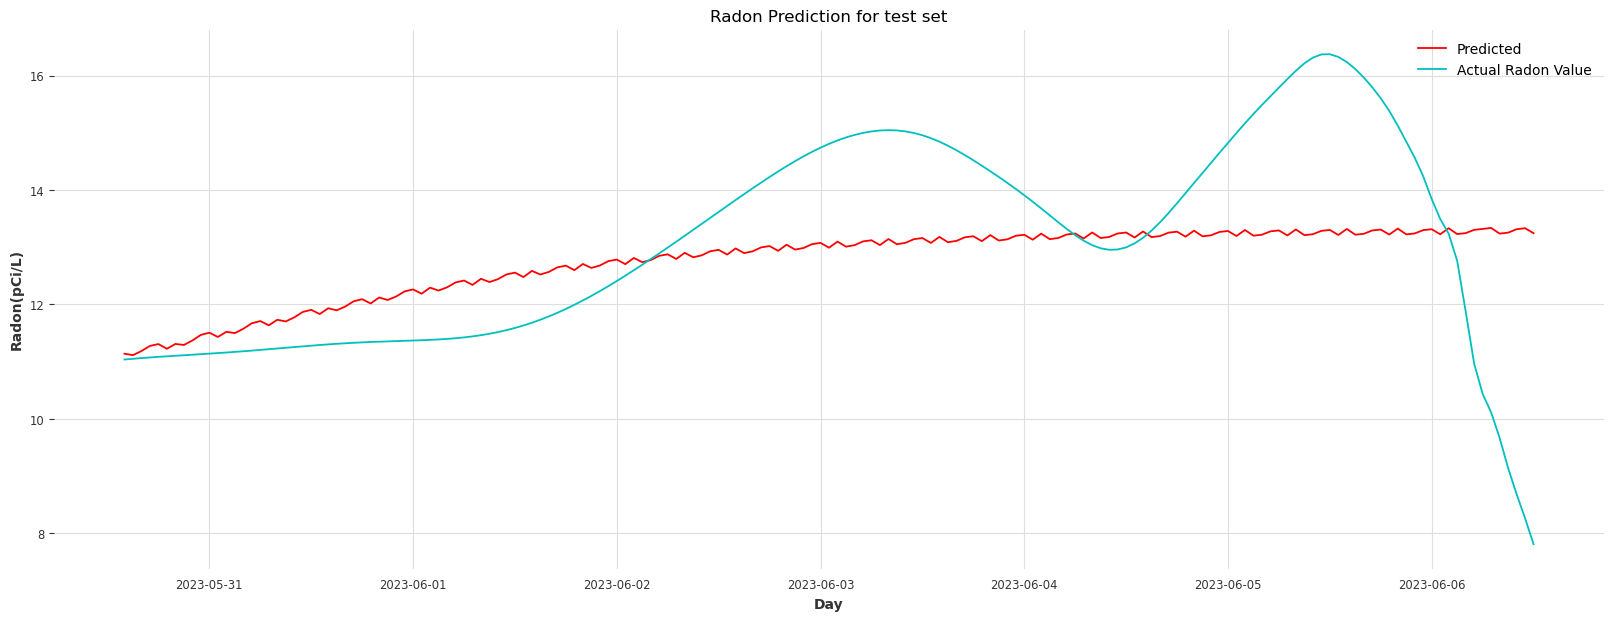

In [24]:
# plot the forecast
plt.figure(100, figsize=(20, 7))
plt.plot(dfY.index, dfY['Predicted'], color='r', label='Predicted')
plt.plot(dfY.index, dfY['Actual'], color='c', label='Actual Radon Value')
plt.legend()
plt.title('Radon Prediction for test set')
plt.xlabel('Day')
plt.ylabel('Radon(pCi/L)')
plt.show()

# Radon 13

In [25]:
df = df_radon['13'].copy()

In [26]:
# Denoising the Radon signal
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

In [27]:
def wavelet_denoising(x, wavelet='db4', level=5):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    n = len(x) 
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    if len(x) % 2 ==0:
        return pywt.waverec(coeff, wavelet, mode='per')
    else:
        return pywt.waverec(coeff, wavelet, mode='per')[:n]

In [28]:
signal = df['Radon'].copy()
wavelet_name='coif17'
filtered = wavelet_denoising(signal, wavelet=wavelet_name, level=4)
df['Radon'] = filtered

In [29]:
# create time series object for target variable
ts_P = TimeSeries.from_series(df["Radon"], fill_missing_dates=True, freq="H") 

# check attributes of the time series
print("components:", ts_P.components)
print("duration:",ts_P.duration)
print("frequency:",ts_P.freq)
print("frequency:",ts_P.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_P.has_datetime_index)
print("deterministic:",ts_P.is_deterministic)
print("univariate:",ts_P.is_univariate)

components: Index(['Radon'], dtype='object', name='component')
duration: 390 days 17:00:00
frequency: <Hour>
frequency: H
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: True


In [30]:
# train/test split and scaling of target variable
ts_train, ts_test = ts_P.split_after(split_point=9210)

print("training start:", ts_train.start_time())
print("training end:", ts_train.end_time())
print("training duration:",ts_train.duration)
print("test start:", ts_test.start_time())
print("test end:", ts_test.end_time())
print("test duration:", ts_test.duration)


scalerP = Scaler()
scalerP.fit_transform(ts_train)
ts_ttrain = scalerP.transform(ts_train)
ts_ttest = scalerP.transform(ts_test)    
ts_t = scalerP.transform(ts_P)

# make sure data are of type float
ts_t = ts_t.astype(np.float32)
ts_ttrain = ts_ttrain.astype(np.float32)
ts_ttest = ts_ttest.astype(np.float32)

print("first and last row of scaled Radon time series:")
pd.options.display.float_format = '{:,.2f}'.format
ts_t.pd_dataframe().iloc[[0,-1]]

training start: 2022-05-11 19:00:00
training end: 2023-05-30 13:00:00
training duration: 383 days 18:00:00
test start: 2023-05-30 14:00:00
test end: 2023-06-06 12:00:00
test duration: 6 days 22:00:00
first and last row of scaled Radon time series:


component            Radon
SyncDate                  
2022-05-11 19:00:00   0.05
2023-06-06 12:00:00   0.05

In [31]:
print("first and last row of scaled target variable in training set: price:")
ts_ttrain.pd_dataframe().iloc[[0,-1]]

first and last row of scaled target variable in training set: price:


component            Radon
SyncDate                  
2022-05-11 19:00:00   0.05
2023-05-30 13:00:00   0.03

In [32]:
def set_seed(seed_value):
    import random
    import numpy as np
    import torch

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    pl.seed_everything(seed_value, workers=True)

In [33]:
import torch
from ray.air import session
from darts.utils.losses import SmapeLoss
from torchmetrics import MetricCollection, SymmetricMeanAbsolutePercentageError, MeanAbsolutePercentageError
def build_fit_tft_model(
    model_args,
    save_checkpoints=False,
    callbacks=None,
    save_model=False
):
#     BATCH_SIZE=64
    MAX_EPOCHS=500
    NR_EPOCHS_VAL_PERIOD=1
    set_seed(42)
    torch_metrics = MetricCollection([MeanAbsolutePercentageError(), SymmetricMeanAbsolutePercentageError()])

#     early_stopper = EarlyStopping(
#         monitor="val_loss",
#         patience=5,
#         min_delta=0.001,
#         mode='min',
#     )

#     if callbacks is None:
#         callbacks = [early_stopper]
#     else:
#         callbacks.append(early_stopper)
    
    #detect if GPU is available
#     if torch.cuda.is_available():
#         pl_trainer_kwargs = {
#             "accelerator": "gpu",
#             "gpus": -1,
#             "auto_select_gpus": True,
#             "callbacks": callbacks,
#             "enable_progress_bar":False,
#         }
#         num_workers=8
#     else:
#         pl_trainer_kwargs={
#             "callbacks": callbacks,
#         }
#         num_workers=0
    pl_trainer_kwargs={
            "accelerator": "gpu",
            "gpus":-1,
            "auto_select_gpus": True,
            "callbacks": callbacks,
            "enable_progress_bar": False,
        }
   
   

    model = TFTModel(
        input_chunk_length=model_args['in_len'],
        output_chunk_length=model_args['out_len'],
        batch_size=model_args['batch_size'],
        n_epochs=MAX_EPOCHS,
        nr_epochs_val_period=NR_EPOCHS_VAL_PERIOD,
        model_name="tft",
        hidden_size=int(model_args['out_len']+((2/3)*model_args['in_len'])),
        lstm_layers=model_args['lstm_layers'],
        num_attention_heads=model_args['num_attention_heads'],
        full_attention=model_args['full_attention'],
        feed_forward=model_args['feed_forward'],
        dropout=model_args['dropout'],
        add_relative_index=True,
        norm_type=model_args['norm_type'],
        use_static_covariates=False,
        loss_fn=SmapeLoss(),
        optimizer_kwargs={'lr': model_args['lr']},
        log_tensorboard=False,
        force_reset=True,
        save_checkpoints=save_checkpoints,
        pl_trainer_kwargs=pl_trainer_kwargs,
        torch_metrics=torch_metrics,
        random_state=42
        )
    val_len = len(ts_test)
    val_series = ts_ttrain[-((val_len) + model_args['in_len']) :]
    ts_ttrain_input = ts_ttrain[:-(val_len )]
    model.fit(  ts_ttrain_input, 
                val_series=val_series,
            )
#     model.load_from_checkpoint(f"{model_args['model']} RNN model", best=True)
    ts_tpred = model.predict(
                series = ts_ttrain,
                n = len(ts_ttest),
                verbose=True
    )
    ts_q = scalerP.inverse_transform(ts_tpred)
    q_smape = smape(ts_q, ts_test)
    session.report({'q_smape': q_smape})

In [34]:
def build_fit_tft_model_return(
    model_args,
    save_checkpoints=False,
    callbacks=None,
    save_model=False
):
#     BATCH_SIZE=64
    MAX_EPOCHS=500
    NR_EPOCHS_VAL_PERIOD=1
    set_seed(42)
    torch_metrics = MetricCollection([MeanAbsolutePercentageError(), SymmetricMeanAbsolutePercentageError()])

#     early_stopper = EarlyStopping(
#         monitor="val_loss",
#         patience=5,
#         min_delta=0.001,
#         mode='min',
#     )

#     if callbacks is None:
#         callbacks = [early_stopper]
#     else:
#         callbacks.append(early_stopper)
    
    #detect if GPU is available
#     if torch.cuda.is_available():
#         pl_trainer_kwargs = {
#             "accelerator": "gpu",
#             "gpus": -1,
#             "auto_select_gpus": True,
#             "callbacks": callbacks,
#             "enable_progress_bar":False,
#         }
#         num_workers=8
#     else:
#         pl_trainer_kwargs={
#             "callbacks": callbacks,
#         }
#         num_workers=0
    pl_trainer_kwargs={
            "accelerator": "gpu",
            "gpus":1,
            "auto_select_gpus": True,
            "callbacks": callbacks,
            "enable_progress_bar": True,
        }
   
   

    model = TFTModel(
        input_chunk_length=model_args['in_len'],
        output_chunk_length=model_args['out_len'],
        batch_size=model_args['batch_size'],
        n_epochs=MAX_EPOCHS,
        nr_epochs_val_period=NR_EPOCHS_VAL_PERIOD,
        model_name="tft",
        hidden_size=int(model_args['out_len']+((2/3)*model_args['in_len'])),
        lstm_layers=model_args['lstm_layers'],
        num_attention_heads=model_args['num_attention_heads'],
        full_attention=model_args['full_attention'],
        feed_forward=model_args['feed_forward'],
        dropout=model_args['dropout'],
        add_relative_index=True,
        norm_type=model_args['norm_type'],
        use_static_covariates=False,
        loss_fn=SmapeLoss(),
        optimizer_kwargs={'lr': model_args['lr']},
        log_tensorboard=False,
        force_reset=True,
        save_checkpoints=save_checkpoints,
        pl_trainer_kwargs=pl_trainer_kwargs,
        torch_metrics=torch_metrics,
        random_state=42
        )
    val_len = len(ts_test)
    val_series = ts_ttrain[-((val_len) + model_args['in_len']) :]
    ts_ttrain_input = ts_ttrain[:-(val_len )]
    model.fit(  ts_ttrain_input, 
                
                val_series=val_series,
                )
#     model.load_from_checkpoint(f"{model_args['model']} RNN model", best=True)
#     ts_tpred = model.predict(
#                 series = ts_ttrain,
#                 past_covariates=covF_t,
#                 n = len(ts_ttest),
#                 verbose=True
#     )
#     ts_q = scalerP.inverse_transform(ts_tpred)
#     q_smape = smape(ts_q, ts_test)
#     session.report({'q_smape': q_smape})
    return model

In [41]:
from ray import tune
from ray.tune import CLIReporter 
# from ray.tune.integration.pytorch_lightning import TuneReportCallback
from ray.tune.schedulers import ASHAScheduler, AsyncHyperBandScheduler
from ray.tune.search.optuna import OptunaSearch
from ray.tune.search import ConcurrencyLimiter
# tune_callback = TuneReportCallback(
#     {
#         "loss":"val_loss",
#         "sMAPE": "val_SymmetricMeanAbsolutePercentageError",
#     },
#     on="validation_end",
# )

early_stopper = EarlyStopping(
        monitor="val_SymmetricMeanAbsolutePercentageError",
        patience=3,
        mode='min',
    )

#define the hyperparameter search space
config = {
    "in_len": tune.randint(8,168),
    "out_len":tune.randint(1,12),
    "lstm_layers":tune.choice([1,2,3]),
    "num_attention_heads":tune.randint(2,8),
    "full_attention":tune.choice([True, False]),
    "feed_forward":tune.choice(['GLU', 'Bilinear', 'ReGLU', 'GEGLU', 'SwiGLU', 'ReLU', 'GELU', 'GatedResidualNetwork']),
    "dropout":tune.uniform(0.1, 0.5),
    "norm_type":tune.choice(['LayerNorm','RMSNorm','LayerNormNoBias']),
    "lr": tune.loguniform(1e-5, 1e-1),
    "batch_size":tune.choice([16,32,64,128,256]),
    
}

reporter = CLIReporter(
    parameter_columns=list(config.keys()),
    metric_columns=["q_smape"])
resources_per_trial = {"cpu": 5, "gpu": 0.4}

num_samples = 100

algo = OptunaSearch()

algo = ConcurrencyLimiter(algo, max_concurrent=10)

scheduler = AsyncHyperBandScheduler(max_t=100, grace_period=10, reduction_factor=2)

train_fn_with_parameters = tune.with_parameters(build_fit_tft_model, callbacks=[early_stopper])

analysis = tune.run(
    train_fn_with_parameters,
    resources_per_trial=resources_per_trial,
    metric="q_smape",
    mode="min",
    config=config,
    num_samples=num_samples,
    search_alg=algo,
    scheduler = scheduler,
    progress_reporter=reporter,
    name="tft_tune",
    raise_on_failed_trial=False
)

print("Best hyperparameters found were: ", analysis.best_config)

== Status ==
Current time: 2023-07-10 03:53:05 (running for 00:00:00.15)
Memory usage on this node: 53.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 1/100 (1 RUNNING)
+------------------------------+----------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------+-----------+-------------+-----------+--------------+
| Trial name                   | status   | loc                  |   in_len |   out_len |   lstm_layers |   num_attention_heads | full_attention   | feed_forward   |   dropout | norm_type   |        lr |   batch_size |
|------------------------------+----------+----------------------+----------+-----------+---------------+--------------

(build_fit_tft_model pid=2194741) Global seed set to 42
(build_fit_tft_model pid=2194741) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2194741)   rank_zero_deprecation(
(build_fit_tft_model pid=2194741) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2194741)   rank_zero_deprecation(
(build_fit_tft_model pid=2194741) Auto select gpus: [0]
(build_fit_tft_model pid=2194741) GPU available: True (cuda), used: True
(bui

== Status ==
Current time: 2023-07-10 03:53:14 (running for 00:00:09.74)
Memory usage on this node: 58.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 9/100 (1 PENDING, 8 RUNNING)
+------------------------------+----------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+--------------+
| Trial name                   | status   | loc                  |   in_len |   out_len |   lstm_layers |   num_attention_heads | full_attention   | feed_forward         |   dropout | norm_type       |          lr |   batch_size |
|------------------------------+----------+----------------------+--

(build_fit_tft_model pid=2195243) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2195243)   rank_zero_deprecation(
(build_fit_tft_model pid=2195243) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2195243)   rank_zero_deprecation(
(build_fit_tft_model pid=2195342) Global seed set to 42
(build_fit_tft_model pid=2195312) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator

(build_fit_tft_model pid=2195238) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_tft_model pid=2195238) 
(build_fit_tft_model pid=2195238)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2195238) ----------------------------------------------------------------------------------------
(build_fit_tft_model pid=2195238) 0  | criterion                         | SmapeLoss                        | 0     
(build_fit_tft_model pid=2195238) 1  | train_metrics                     | MetricCollection                 | 0     
(build_fit_tft_model pid=2195238) 2  | val_metrics                       | MetricCollection                 | 0     
(build_fit_tft_model pid=2195238) 3  | input_embeddings                  | _MultiEmbedding                  | 0     
(build_fit_tft_model pid=2195238) 4  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
(build_fit_tft_model pid=2195238) 5  | encoder_vsn              

(build_fit_tft_model pid=2195312) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_tft_model pid=2195312)   rank_zero_warn(
(build_fit_tft_model pid=2195312) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_tft_model pid=2195312)   rank_zero_warn(
(build_fit_tft_model pid=2195240) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(lo

(build_fit_tft_model pid=2195236) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_tft_model pid=2195236) 
(build_fit_tft_model pid=2195236)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2195236) ----------------------------------------------------------------------------------------
(build_fit_tft_model pid=2195236) 0  | criterion                         | SmapeLoss                        | 0     
(build_fit_tft_model pid=2195236) 1  | train_metrics                     | MetricCollection                 | 0     
(build_fit_tft_model pid=2195236) 2  | val_metrics                       | MetricCollection                 | 0     
(build_fit_tft_model pid=2195236) 3  | input_embeddings                  | _MultiEmbedding                  | 0     
(build_fit_tft_model pid=2195236) 4  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
(build_fit_tft_model pid=2195236) 5  | encoder_vsn              

== Status ==
Current time: 2023-07-10 03:53:19 (running for 00:00:14.90)
Memory usage on this node: 73.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 9/100 (1 PENDING, 8 RUNNING)
+------------------------------+----------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+--------------+
| Trial name                   | status   | loc                  |   in_len |   out_len |   lstm_layers |   num_attention_heads | full_attention   | feed_forward         |   dropout | norm_type       |          lr |   batch_size |
|------------------------------+----------+----------------------+--

== Status ==
Current time: 2023-07-10 03:53:34 (running for 00:00:29.91)
Memory usage on this node: 73.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 9/100 (1 PENDING, 8 RUNNING)
+------------------------------+----------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+--------------+
| Trial name                   | status   | loc                  |   in_len |   out_len |   lstm_layers |   num_attention_heads | full_attention   | feed_forward         |   dropout | norm_type       |          lr |   batch_size |
|------------------------------+----------+----------------------+--

== Status ==
Current time: 2023-07-10 03:53:49 (running for 00:00:44.92)
Memory usage on this node: 73.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 9/100 (1 PENDING, 8 RUNNING)
+------------------------------+----------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+--------------+
| Trial name                   | status   | loc                  |   in_len |   out_len |   lstm_layers |   num_attention_heads | full_attention   | feed_forward         |   dropout | norm_type       |          lr |   batch_size |
|------------------------------+----------+----------------------+--

== Status ==
Current time: 2023-07-10 03:54:04 (running for 00:00:59.94)
Memory usage on this node: 73.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 9/100 (1 PENDING, 8 RUNNING)
+------------------------------+----------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+--------------+
| Trial name                   | status   | loc                  |   in_len |   out_len |   lstm_layers |   num_attention_heads | full_attention   | feed_forward         |   dropout | norm_type       |          lr |   batch_size |
|------------------------------+----------+----------------------+--

== Status ==
Current time: 2023-07-10 03:54:19 (running for 00:01:14.95)
Memory usage on this node: 73.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 9/100 (1 PENDING, 8 RUNNING)
+------------------------------+----------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+--------------+
| Trial name                   | status   | loc                  |   in_len |   out_len |   lstm_layers |   num_attention_heads | full_attention   | feed_forward         |   dropout | norm_type       |          lr |   batch_size |
|------------------------------+----------+----------------------+--

(build_fit_tft_model pid=2195238) Auto select gpus: [0]
(build_fit_tft_model pid=2195238) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2195238) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2195238) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2195238) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2195238) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2195238) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.74it/s]


(build_fit_tft_model pid=2198065) Global seed set to 42
(build_fit_tft_model pid=2198065) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2198065)   rank_zero_deprecation(
(build_fit_tft_model pid=2198065) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2198065)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 03:54:26 (running for 00:01:21.18)
Memory usage on this node: 71.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: d5f9e3f0 with q_smape=78.91921642587533 and parameters={'in_len': 138, 'out_len': 6, 'lstm_layers': 1, 'num_attention_heads': 7, 'full_attention': True, 'feed_forward': 'ReGLU', 'dropout': 0.1781452079688117, 'norm_type': 'LayerNorm', 'lr': 0.030464503890879246, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 10/100 (1 PENDING, 8 RUNNING, 1 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+----------

(build_fit_tft_model pid=2194741) Auto select gpus: [0]
(build_fit_tft_model pid=2194741) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2194741) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2194741) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2194741) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2194741) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2198065) Auto select gpus: [0]
(build_fit_tft_model pid=2198065) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2198065) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2198065) IPU available: False, using: 0 I

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


(build_fit_tft_model pid=2198065) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_tft_model pid=2198065) 
(build_fit_tft_model pid=2198065)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2198065) ----------------------------------------------------------------------------------------
(build_fit_tft_model pid=2198065) 0  | criterion                         | SmapeLoss                        | 0     
(build_fit_tft_model pid=2198065) 1  | train_metrics                     | MetricCollection                 | 0     
(build_fit_tft_model pid=2198065) 2  | val_metrics                       | MetricCollection                 | 0     
(build_fit_tft_model pid=2198065) 3  | input_embeddings                  | _MultiEmbedding                  | 0     
(build_fit_tft_model pid=2198065) 4  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
(build_fit_tft_model pid=2198065) 5  | encoder_vsn              

== Status ==
Current time: 2023-07-10 03:54:34 (running for 00:01:29.20)
Memory usage on this node: 71.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 14c82758 with q_smape=39.460150383816476 and parameters={'in_len': 114, 'out_len': 4, 'lstm_layers': 3, 'num_attention_heads': 5, 'full_attention': True, 'feed_forward': 'GELU', 'dropout': 0.32840999340134547, 'norm_type': 'RMSNorm', 'lr': 0.03838075440775361, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 11/100 (1 PENDING, 8 RUNNING, 2 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------

(build_fit_tft_model pid=2198312) Auto select gpus: [0]
(build_fit_tft_model pid=2198312) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2198312) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2198312) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2198312) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2198312) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2198312) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_tft_model pid=2198312) 
(build_fit_tft_model pid=2198312)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2198312) --------

== Status ==
Current time: 2023-07-10 03:54:39 (running for 00:01:34.20)
Memory usage on this node: 73.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 14c82758 with q_smape=39.460150383816476 and parameters={'in_len': 114, 'out_len': 4, 'lstm_layers': 3, 'num_attention_heads': 5, 'full_attention': True, 'feed_forward': 'GELU', 'dropout': 0.32840999340134547, 'norm_type': 'RMSNorm', 'lr': 0.03838075440775361, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 11/100 (1 PENDING, 8 RUNNING, 2 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------

== Status ==
Current time: 2023-07-10 03:54:49 (running for 00:01:44.21)
Memory usage on this node: 73.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 14c82758 with q_smape=39.460150383816476 and parameters={'in_len': 114, 'out_len': 4, 'lstm_layers': 3, 'num_attention_heads': 5, 'full_attention': True, 'feed_forward': 'GELU', 'dropout': 0.32840999340134547, 'norm_type': 'RMSNorm', 'lr': 0.03838075440775361, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 11/100 (1 PENDING, 8 RUNNING, 2 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------

== Status ==
Current time: 2023-07-10 03:54:59 (running for 00:01:54.23)
Memory usage on this node: 73.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 14c82758 with q_smape=39.460150383816476 and parameters={'in_len': 114, 'out_len': 4, 'lstm_layers': 3, 'num_attention_heads': 5, 'full_attention': True, 'feed_forward': 'GELU', 'dropout': 0.32840999340134547, 'norm_type': 'RMSNorm', 'lr': 0.03838075440775361, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 11/100 (1 PENDING, 8 RUNNING, 2 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------

(build_fit_tft_model pid=2198312) Auto select gpus: [0]
(build_fit_tft_model pid=2198312) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2198312) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2198312) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2198312) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2198312) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2198312) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


== Status ==
Current time: 2023-07-10 03:55:04 (running for 00:01:59.23)
Memory usage on this node: 73.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 14c82758 with q_smape=39.460150383816476 and parameters={'in_len': 114, 'out_len': 4, 'lstm_layers': 3, 'num_attention_heads': 5, 'full_attention': True, 'feed_forward': 'GELU', 'dropout': 0.32840999340134547, 'norm_type': 'RMSNorm', 'lr': 0.03838075440775361, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 11/100 (1 PENDING, 8 RUNNING, 2 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------

(build_fit_tft_model pid=2195342) Auto select gpus: [0]
(build_fit_tft_model pid=2195342) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2195342) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2195342) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2195342) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2195342) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2195342) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


(build_fit_tft_model pid=2198629) Global seed set to 42
(build_fit_tft_model pid=2198629) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2198629)   rank_zero_deprecation(
(build_fit_tft_model pid=2198629) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2198629)   rank_zero_deprecation(
(build_fit_tft_model pid=2198629) Auto select gpus: [0]
(build_fit_tft_model pid=2198629) GPU available: True (cuda), used: True
(bui

== Status ==
Current time: 2023-07-10 03:55:12 (running for 00:02:07.20)
Memory usage on this node: 71.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 14c82758 with q_smape=39.460150383816476 and parameters={'in_len': 114, 'out_len': 4, 'lstm_layers': 3, 'num_attention_heads': 5, 'full_attention': True, 'feed_forward': 'GELU', 'dropout': 0.32840999340134547, 'norm_type': 'RMSNorm', 'lr': 0.03838075440775361, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 13/100 (1 PENDING, 8 RUNNING, 4 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------

(build_fit_tft_model pid=2198629) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_tft_model pid=2198629) 
(build_fit_tft_model pid=2198629)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2198629) ----------------------------------------------------------------------------------------
(build_fit_tft_model pid=2198629) 0  | criterion                         | SmapeLoss                        | 0     
(build_fit_tft_model pid=2198629) 1  | train_metrics                     | MetricCollection                 | 0     
(build_fit_tft_model pid=2198629) 2  | val_metrics                       | MetricCollection                 | 0     
(build_fit_tft_model pid=2198629) 3  | input_embeddings                  | _MultiEmbedding                  | 0     
(build_fit_tft_model pid=2198629) 4  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
(build_fit_tft_model pid=2198629) 5  | encoder_vsn              

(build_fit_tft_model pid=2198792) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_tft_model pid=2198792)   rank_zero_warn(
(build_fit_tft_model pid=2198792) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_tft_model pid=2198792)   rank_zero_warn(
(build_fit_tft_model pid=2198792) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logg

== Status ==
Current time: 2023-07-10 03:55:17 (running for 00:02:12.21)
Memory usage on this node: 73.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 14c82758 with q_smape=39.460150383816476 and parameters={'in_len': 114, 'out_len': 4, 'lstm_layers': 3, 'num_attention_heads': 5, 'full_attention': True, 'feed_forward': 'GELU', 'dropout': 0.32840999340134547, 'norm_type': 'RMSNorm', 'lr': 0.03838075440775361, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 13/100 (1 PENDING, 8 RUNNING, 4 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------

(build_fit_tft_model pid=2195240) Auto select gpus: [0]
(build_fit_tft_model pid=2195240) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2195240) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2195240) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2195240) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2195240) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2195240) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.17it/s]


(build_fit_tft_model pid=2199127) Global seed set to 42
(build_fit_tft_model pid=2199127) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2199127)   rank_zero_deprecation(
(build_fit_tft_model pid=2199127) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2199127)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 03:55:30 (running for 00:02:25.20)
Memory usage on this node: 71.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 14c82758 with q_smape=39.460150383816476 and parameters={'in_len': 114, 'out_len': 4, 'lstm_layers': 3, 'num_attention_heads': 5, 'full_attention': True, 'feed_forward': 'GELU', 'dropout': 0.32840999340134547, 'norm_type': 'RMSNorm', 'lr': 0.03838075440775361, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 14/100 (1 PENDING, 8 RUNNING, 5 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------

(build_fit_tft_model pid=2199127) Auto select gpus: [0]
(build_fit_tft_model pid=2199127) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2199127) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2199127) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2199127) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2199127) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2199127) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_tft_model pid=2199127) 
(build_fit_tft_model pid=2199127)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2199127) --------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]


(build_fit_tft_model pid=2195312) Auto select gpus: [0]
(build_fit_tft_model pid=2195312) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2195312) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2195312) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2195312) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2195312) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2195312) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2198065) Auto select gpus: [0]
(build_fit_tft_model pid=2198065) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2198065) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2198065) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2198065) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2198065) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2199376) Global seed set to 42
(build_fit_tft_model pid=2198065) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_tft_model pid=2199376) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_conn

== Status ==
Current time: 2023-07-10 03:55:40 (running for 00:02:35.07)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 15/100 (1 PENDING, 8 RUNNING, 6 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+------------

(build_fit_tft_model pid=2199376) Auto select gpus: [0]
(build_fit_tft_model pid=2199376) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2199376) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2199376) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2199376) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2199376) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2199376) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_tft_model pid=2199376) 
(build_fit_tft_model pid=2199376)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2199376) --------

== Status ==
Current time: 2023-07-10 03:55:45 (running for 00:02:40.20)
Memory usage on this node: 71.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 16/100 (1 PENDING, 8 RUNNING, 7 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+------------

(build_fit_tft_model pid=2199614) Auto select gpus: [0]
(build_fit_tft_model pid=2199614) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2199614) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2199614) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2199614) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2199614) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2199614) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_tft_model pid=2199614) 
(build_fit_tft_model pid=2199614)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2199614) --------

== Status ==
Current time: 2023-07-10 03:55:50 (running for 00:02:45.21)
Memory usage on this node: 73.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 16/100 (1 PENDING, 8 RUNNING, 7 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+------------

== Status ==
Current time: 2023-07-10 03:56:00 (running for 00:02:55.22)
Memory usage on this node: 73.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 16/100 (1 PENDING, 8 RUNNING, 7 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+------------

(build_fit_tft_model pid=2195316) Auto select gpus: [0]
(build_fit_tft_model pid=2195316) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2195316) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2195316) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2195316) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2195316) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2195316) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


(build_fit_tft_model pid=2199877) Global seed set to 42
(build_fit_tft_model pid=2199877) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2199877)   rank_zero_deprecation(
(build_fit_tft_model pid=2199877) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2199877)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 03:56:07 (running for 00:03:02.20)
Memory usage on this node: 71.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 17/100 (1 PENDING, 8 RUNNING, 8 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+------------

(build_fit_tft_model pid=2199877) Auto select gpus: [0]
(build_fit_tft_model pid=2199877) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2199877) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2199877) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2199877) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2199877) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2199376) Auto select gpus: [0]
(build_fit_tft_model pid=2199376) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2199376) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2199376) IPU available: False, using: 0 I

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.10it/s]


(build_fit_tft_model pid=2199877) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_tft_model pid=2199877) 
(build_fit_tft_model pid=2199877)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2199877) ----------------------------------------------------------------------------------------
(build_fit_tft_model pid=2199877) 0  | criterion                         | SmapeLoss                        | 0     
(build_fit_tft_model pid=2199877) 1  | train_metrics                     | MetricCollection                 | 0     
(build_fit_tft_model pid=2199877) 2  | val_metrics                       | MetricCollection                 | 0     
(build_fit_tft_model pid=2199877) 3  | input_embeddings                  | _MultiEmbedding                  | 0     
(build_fit_tft_model pid=2199877) 4  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
(build_fit_tft_model pid=2199877) 5  | encoder_vsn              

== Status ==
Current time: 2023-07-10 03:56:15 (running for 00:03:10.20)
Memory usage on this node: 71.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 18/100 (1 PENDING, 8 RUNNING, 9 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+------------

(build_fit_tft_model pid=2200177) Auto select gpus: [0]
(build_fit_tft_model pid=2200177) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2200177) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2200177) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2200177) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2200177) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2200177) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_tft_model pid=2200177) 
(build_fit_tft_model pid=2200177)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2200177) --------

== Status ==
Current time: 2023-07-10 03:56:20 (running for 00:03:15.21)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 18/100 (1 PENDING, 8 RUNNING, 9 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+------------

== Status ==
Current time: 2023-07-10 03:56:30 (running for 00:03:25.23)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 18/100 (1 PENDING, 8 RUNNING, 9 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+------------

== Status ==
Current time: 2023-07-10 03:56:40 (running for 00:03:35.24)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 18/100 (1 PENDING, 8 RUNNING, 9 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+------------

(build_fit_tft_model pid=2198792) Auto select gpus: [0]
(build_fit_tft_model pid=2198792) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2198792) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2198792) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2198792) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2198792) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2198792) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.43it/s]
== Status ==
Current time: 2023-07-10 03:56:46 (running for 00:03:41.20)
Memory usage on this node: 70.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 18/100 (8 RUNNING, 10 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+-----

(build_fit_tft_model pid=2200494) Global seed set to 42
(build_fit_tft_model pid=2200494) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2200494)   rank_zero_deprecation(
(build_fit_tft_model pid=2200494) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2200494)   rank_zero_deprecation(
(build_fit_tft_model pid=2200494) Auto select gpus: [0]
(build_fit_tft_model pid=2200494) GPU available: True (cuda), used: True
(bui

== Status ==
Current time: 2023-07-10 03:56:55 (running for 00:03:50.81)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 19/100 (1 PENDING, 8 RUNNING, 10 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2195243) Auto select gpus: [0]
(build_fit_tft_model pid=2195243) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2195243) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2195243) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2195243) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2195243) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2195243) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_tft_model pid=2200745) Global seed set to 42
(build_fit_tft_model pid=2200745) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_conn

== Status ==
Current time: 2023-07-10 03:57:03 (running for 00:03:58.22)
Memory usage on this node: 71.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 20/100 (1 PENDING, 8 RUNNING, 11 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2200745) Auto select gpus: [0]
(build_fit_tft_model pid=2200745) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2200745) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2200745) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2200745) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2200745) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2200745) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_tft_model pid=2200745) 
(build_fit_tft_model pid=2200745)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2200745) --------

== Status ==
Current time: 2023-07-10 03:57:08 (running for 00:04:03.23)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 20/100 (1 PENDING, 8 RUNNING, 11 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 03:57:18 (running for 00:04:13.25)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 20/100 (1 PENDING, 8 RUNNING, 11 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 03:57:28 (running for 00:04:23.26)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 20/100 (1 PENDING, 8 RUNNING, 11 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 03:57:38 (running for 00:04:33.28)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 20/100 (1 PENDING, 8 RUNNING, 11 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 03:57:48 (running for 00:04:43.30)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 20/100 (1 PENDING, 8 RUNNING, 11 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2200494) Auto select gpus: [0]
(build_fit_tft_model pid=2200494) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2200494) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2200494) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2200494) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2200494) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2200494) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


(build_fit_tft_model pid=2201078) Global seed set to 42
(build_fit_tft_model pid=2201078) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2201078)   rank_zero_deprecation(
(build_fit_tft_model pid=2201078) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2201078)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 03:57:55 (running for 00:04:50.23)
Memory usage on this node: 71.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 21/100 (1 PENDING, 8 RUNNING, 12 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2201078) Auto select gpus: [0]
(build_fit_tft_model pid=2201078) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2201078) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2201078) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2201078) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2201078) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2201078) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_tft_model pid=2201078) 
(build_fit_tft_model pid=2201078)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2201078) --------

== Status ==
Current time: 2023-07-10 03:58:00 (running for 00:04:55.24)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 21/100 (1 PENDING, 8 RUNNING, 12 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 03:58:10 (running for 00:05:05.25)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 21/100 (1 PENDING, 8 RUNNING, 12 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2200177) Auto select gpus: [0]
(build_fit_tft_model pid=2200177) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2200177) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2200177) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2200177) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2200177) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2200177) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.01it/s]


(build_fit_tft_model pid=2198629) Auto select gpus: [0]
(build_fit_tft_model pid=2198629) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2198629) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2198629) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2198629) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2198629) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2198629) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


== Status ==
Current time: 2023-07-10 03:58:16 (running for 00:05:11.50)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 22/100 (1 PENDING, 8 RUNNING, 13 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2201338) Global seed set to 42
(build_fit_tft_model pid=2201338) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2201338)   rank_zero_deprecation(
(build_fit_tft_model pid=2201338) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2201338)   rank_zero_deprecation(
(build_fit_tft_model pid=2201338) Auto select gpus: [0]
(build_fit_tft_model pid=2201338) GPU available: True (cuda), used: True
(bui

== Status ==
Current time: 2023-07-10 03:58:22 (running for 00:05:17.24)
Memory usage on this node: 71.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 23/100 (1 PENDING, 8 RUNNING, 14 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2201577) Auto select gpus: [0]
(build_fit_tft_model pid=2201577) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2201577) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2201577) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2201577) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2201577) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2201577) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_tft_model pid=2201577) 
(build_fit_tft_model pid=2201577)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2201577) --------

== Status ==
Current time: 2023-07-10 03:58:27 (running for 00:05:22.24)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 23/100 (1 PENDING, 8 RUNNING, 14 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2195236) Auto select gpus: [0]
(build_fit_tft_model pid=2195236) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2195236) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2195236) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2195236) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2195236) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2195236) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


(build_fit_tft_model pid=2201882) Global seed set to 42
(build_fit_tft_model pid=2201882) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2201882)   rank_zero_deprecation(
(build_fit_tft_model pid=2201882) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2201882)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 03:58:42 (running for 00:05:37.23)
Memory usage on this node: 71.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 24/100 (1 PENDING, 8 RUNNING, 15 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2201882) Auto select gpus: [0]
(build_fit_tft_model pid=2201882) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2201882) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2201882) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2201882) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2201882) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2201882) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_tft_model pid=2201882) 
(build_fit_tft_model pid=2201882)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2201882) --------

== Status ==
Current time: 2023-07-10 03:58:47 (running for 00:05:42.25)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 24/100 (1 PENDING, 8 RUNNING, 15 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 03:58:57 (running for 00:05:52.27)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 24/100 (1 PENDING, 8 RUNNING, 15 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 03:59:07 (running for 00:06:02.28)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 24/100 (1 PENDING, 8 RUNNING, 15 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2200745) Auto select gpus: [0]
(build_fit_tft_model pid=2200745) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2200745) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2200745) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2200745) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2200745) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2200745) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2199127) Auto select gpus: [0]
(build_fit_tft_model pid=2199127) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2199127) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2199127) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2199127) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2199127) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2199127) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.11it/s]


(build_fit_tft_model pid=2202164) Global seed set to 42
(build_fit_tft_model pid=2202162) Global seed set to 42
(build_fit_tft_model pid=2202162) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2202162)   rank_zero_deprecation(
(build_fit_tft_model pid=2202162) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2202162)   rank_zero_deprecation(
(build_fit_tft_model pid=2202164) /home/ubuntu/anaconda3/lib/python3.9/site-p

== Status ==
Current time: 2023-07-10 03:59:16 (running for 00:06:11.26)
Memory usage on this node: 69.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 26/100 (1 PENDING, 8 RUNNING, 17 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2202162) Auto select gpus: [0]
(build_fit_tft_model pid=2202162) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2202162) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2202162) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2202162) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2202162) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2202164) Auto select gpus: [0]
(build_fit_tft_model pid=2202164) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2202164) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2202164) IPU available: False, using: 0 I

(build_fit_tft_model pid=2202164) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_tft_model pid=2202164)   rank_zero_warn(
(build_fit_tft_model pid=2202164) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_tft_model pid=2202164)   rank_zero_warn(
(build_fit_tft_model pid=2202164) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logg

== Status ==
Current time: 2023-07-10 03:59:21 (running for 00:06:16.28)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 26/100 (1 PENDING, 8 RUNNING, 17 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 03:59:31 (running for 00:06:26.29)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 26/100 (1 PENDING, 8 RUNNING, 17 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 03:59:41 (running for 00:06:36.31)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 26/100 (1 PENDING, 8 RUNNING, 17 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 03:59:51 (running for 00:06:46.32)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 26/100 (1 PENDING, 8 RUNNING, 17 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:00:01 (running for 00:06:56.34)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 26/100 (1 PENDING, 8 RUNNING, 17 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:00:11 (running for 00:07:06.36)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 26/100 (1 PENDING, 8 RUNNING, 17 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:00:21 (running for 00:07:16.37)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 26/100 (1 PENDING, 8 RUNNING, 17 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:00:31 (running for 00:07:26.39)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 26/100 (1 PENDING, 8 RUNNING, 17 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2202162) Auto select gpus: [0]
(build_fit_tft_model pid=2202162) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2202162) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2202162) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2202162) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2202162) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2202162) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.71it/s]


(build_fit_tft_model pid=2202763) Global seed set to 42
(build_fit_tft_model pid=2202763) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2202763)   rank_zero_deprecation(
(build_fit_tft_model pid=2202763) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2202763)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 04:00:44 (running for 00:07:39.25)
Memory usage on this node: 71.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 27/100 (1 PENDING, 8 RUNNING, 18 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2202763) Auto select gpus: [0]
(build_fit_tft_model pid=2202763) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2202763) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2202763) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2202763) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2202763) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2202763) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_tft_model pid=2202763) 
(build_fit_tft_model pid=2202763)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2202763) --------

== Status ==
Current time: 2023-07-10 04:00:49 (running for 00:07:44.26)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 27/100 (1 PENDING, 8 RUNNING, 18 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:00:59 (running for 00:07:54.27)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 27/100 (1 PENDING, 8 RUNNING, 18 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:01:09 (running for 00:08:04.29)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 27/100 (1 PENDING, 8 RUNNING, 18 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2199614) Auto select gpus: [0]
(build_fit_tft_model pid=2199614) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2199614) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2199614) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2199614) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2199614) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2199614) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


(build_fit_tft_model pid=2203085) Global seed set to 42
(build_fit_tft_model pid=2203085) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2203085)   rank_zero_deprecation(
(build_fit_tft_model pid=2203085) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2203085)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 04:01:20 (running for 00:08:15.25)
Memory usage on this node: 71.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 28/100 (1 PENDING, 8 RUNNING, 19 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2203085) Auto select gpus: [0]
(build_fit_tft_model pid=2203085) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2203085) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2203085) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2203085) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2203085) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2203085) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_tft_model pid=2203085) 
(build_fit_tft_model pid=2203085)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2203085) --------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


(build_fit_tft_model pid=2203333) Global seed set to 42
(build_fit_tft_model pid=2203333) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2203333)   rank_zero_deprecation(
(build_fit_tft_model pid=2203333) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2203333)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 04:01:30 (running for 00:08:25.25)
Memory usage on this node: 71.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 29/100 (1 PENDING, 8 RUNNING, 20 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2203333) Auto select gpus: [0]
(build_fit_tft_model pid=2203333) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2203333) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2203333) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2203333) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2203333) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2203333) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_tft_model pid=2203333) 
(build_fit_tft_model pid=2203333)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2203333) --------

== Status ==
Current time: 2023-07-10 04:01:35 (running for 00:08:30.26)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 29/100 (1 PENDING, 8 RUNNING, 20 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:01:45 (running for 00:08:40.28)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 29/100 (1 PENDING, 8 RUNNING, 20 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:01:55 (running for 00:08:50.30)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 29/100 (1 PENDING, 8 RUNNING, 20 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2202763) Auto select gpus: [0]
(build_fit_tft_model pid=2202763) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2202763) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2202763) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2202763) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2202763) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2202763) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


(build_fit_tft_model pid=2203646) Global seed set to 42
(build_fit_tft_model pid=2203646) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2203646)   rank_zero_deprecation(
(build_fit_tft_model pid=2203646) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2203646)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 04:02:02 (running for 00:08:57.26)
Memory usage on this node: 71.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 30/100 (1 PENDING, 8 RUNNING, 21 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2203646) Auto select gpus: [0]
(build_fit_tft_model pid=2203646) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2203646) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2203646) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2203646) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2203646) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2203646) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_tft_model pid=2203646) 
(build_fit_tft_model pid=2203646)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2203646) --------

== Status ==
Current time: 2023-07-10 04:02:07 (running for 00:09:02.27)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 30/100 (1 PENDING, 8 RUNNING, 21 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:02:17 (running for 00:09:12.29)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 30/100 (1 PENDING, 8 RUNNING, 21 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:02:27 (running for 00:09:22.30)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 30/100 (1 PENDING, 8 RUNNING, 21 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:02:37 (running for 00:09:32.32)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 30/100 (1 PENDING, 8 RUNNING, 21 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:02:47 (running for 00:09:42.34)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 30/100 (1 PENDING, 8 RUNNING, 21 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:02:57 (running for 00:09:52.35)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 30/100 (1 PENDING, 8 RUNNING, 21 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:03:07 (running for 00:10:02.37)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 30/100 (1 PENDING, 8 RUNNING, 21 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:03:17 (running for 00:10:12.38)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 30/100 (1 PENDING, 8 RUNNING, 21 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:03:27 (running for 00:10:22.40)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 30/100 (1 PENDING, 8 RUNNING, 21 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:03:37 (running for 00:10:32.41)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 30/100 (1 PENDING, 8 RUNNING, 21 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:03:47 (running for 00:10:42.43)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 30/100 (1 PENDING, 8 RUNNING, 21 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:03:57 (running for 00:10:52.44)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 30/100 (1 PENDING, 8 RUNNING, 21 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:04:07 (running for 00:11:02.46)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 30/100 (1 PENDING, 8 RUNNING, 21 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:04:17 (running for 00:11:12.47)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 30/100 (1 PENDING, 8 RUNNING, 21 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:04:27 (running for 00:11:22.49)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 30/100 (1 PENDING, 8 RUNNING, 21 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2202164) Auto select gpus: [0]
(build_fit_tft_model pid=2202164) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2202164) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2202164) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2202164) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2202164) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2202164) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.12it/s]


(build_fit_tft_model pid=2204132) Global seed set to 42
(build_fit_tft_model pid=2204132) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2204132)   rank_zero_deprecation(
(build_fit_tft_model pid=2204132) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2204132)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 04:04:42 (running for 00:11:37.28)
Memory usage on this node: 71.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 31/100 (1 PENDING, 8 RUNNING, 22 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2204132) Auto select gpus: [0]
(build_fit_tft_model pid=2204132) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2204132) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2204132) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2204132) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2204132) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2204132) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_tft_model pid=2204132) 
(build_fit_tft_model pid=2204132)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2204132) --------

== Status ==
Current time: 2023-07-10 04:04:47 (running for 00:11:42.29)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 31/100 (1 PENDING, 8 RUNNING, 22 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:04:57 (running for 00:11:52.30)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 31/100 (1 PENDING, 8 RUNNING, 22 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2201882) Auto select gpus: [0]
(build_fit_tft_model pid=2201882) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2201882) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2201882) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2201882) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2201882) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2201882) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.06it/s]
== Status ==
Current time: 2023-07-10 04:05:03 (running for 00:11:58.26)
Memory usage on this node: 70.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 31/100 (8 RUNNING, 23 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+-----

(build_fit_tft_model pid=2204396) Global seed set to 42
(build_fit_tft_model pid=2204396) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2204396)   rank_zero_deprecation(
(build_fit_tft_model pid=2204396) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2204396)   rank_zero_deprecation(
(build_fit_tft_model pid=2204396) Auto select gpus: [0]
(build_fit_tft_model pid=2204396) GPU available: True (cuda), used: True
(bui

== Status ==
Current time: 2023-07-10 04:05:12 (running for 00:12:07.85)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 32/100 (1 PENDING, 8 RUNNING, 23 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:05:22 (running for 00:12:17.86)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 32/100 (1 PENDING, 8 RUNNING, 23 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:05:32 (running for 00:12:27.88)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 32/100 (1 PENDING, 8 RUNNING, 23 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:05:42 (running for 00:12:37.90)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 32/100 (1 PENDING, 8 RUNNING, 23 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:05:52 (running for 00:12:47.91)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 32/100 (1 PENDING, 8 RUNNING, 23 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:06:02 (running for 00:12:57.93)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 32/100 (1 PENDING, 8 RUNNING, 23 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2203085) Auto select gpus: [0]
(build_fit_tft_model pid=2203085) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2203085) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2203085) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2203085) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2203085) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2203085) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2203646) Auto select gpus: [0]
(build_fit_tft_model pid=2203646) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2203646) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2203646) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2203646) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2203646) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2203646) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


(build_fit_tft_model pid=2204702) Global seed set to 42
(build_fit_tft_model pid=2204702) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2204702)   rank_zero_deprecation(
(build_fit_tft_model pid=2204702) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2204702)   rank_zero_deprecation(
(build_fit_tft_model pid=2204914) Global seed set to 42
(build_fit_tft_model pid=2204702) Auto select gpus: [0]
(build_fit_tft_model 

== Status ==
Current time: 2023-07-10 04:06:15 (running for 00:13:10.28)
Memory usage on this node: 70.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 34/100 (1 PENDING, 8 RUNNING, 25 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2204702) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_tft_model pid=2204702) 
(build_fit_tft_model pid=2204702)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2204702) ----------------------------------------------------------------------------------------
(build_fit_tft_model pid=2204702) 0  | criterion                         | SmapeLoss                        | 0     
(build_fit_tft_model pid=2204702) 1  | train_metrics                     | MetricCollection                 | 0     
(build_fit_tft_model pid=2204702) 2  | val_metrics                       | MetricCollection                 | 0     
(build_fit_tft_model pid=2204702) 3  | input_embeddings                  | _MultiEmbedding                  | 0     
(build_fit_tft_model pid=2204702) 4  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
(build_fit_tft_model pid=2204702) 5  | encoder_vsn              

(build_fit_tft_model pid=2204914) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_tft_model pid=2204914)   rank_zero_warn(
(build_fit_tft_model pid=2204914) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_tft_model pid=2204914)   rank_zero_warn(
(build_fit_tft_model pid=2204914) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logg

== Status ==
Current time: 2023-07-10 04:06:20 (running for 00:13:15.30)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 34/100 (1 PENDING, 8 RUNNING, 25 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2204132) Auto select gpus: [0]
(build_fit_tft_model pid=2204132) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2204132) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2204132) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2204132) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2204132) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2204132) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_tft_model pid=2205244) Global seed set to 42
(build_fit_tft_model pid=2205244) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_conn

== Status ==
Current time: 2023-07-10 04:06:29 (running for 00:13:24.29)
Memory usage on this node: 71.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 35/100 (1 PENDING, 8 RUNNING, 26 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2205244) Auto select gpus: [0]
(build_fit_tft_model pid=2205244) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2205244) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2205244) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2205244) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2205244) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2205244) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_tft_model pid=2205244) 
(build_fit_tft_model pid=2205244)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2205244) --------

== Status ==
Current time: 2023-07-10 04:06:34 (running for 00:13:29.30)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 35/100 (1 PENDING, 8 RUNNING, 26 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:06:44 (running for 00:13:39.32)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 35/100 (1 PENDING, 8 RUNNING, 26 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:06:54 (running for 00:13:49.34)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 35/100 (1 PENDING, 8 RUNNING, 26 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2204702) Auto select gpus: [0]
(build_fit_tft_model pid=2204702) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2204702) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2204702) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2204702) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2204702) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2204702) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]


(build_fit_tft_model pid=2205244) Auto select gpus: [0]
(build_fit_tft_model pid=2205244) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2205244) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2205244) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2205244) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2205244) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2205244) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]
== Status ==
Current time: 2023-07-10 04:07:05 (running for 00:14:00.07)
Memory usage on this node: 71.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 36/100 (1 PENDING, 8 RUNNING, 27 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+------------------

(build_fit_tft_model pid=2205562) Global seed set to 42
(build_fit_tft_model pid=2205562) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2205562)   rank_zero_deprecation(
(build_fit_tft_model pid=2205562) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2205562)   rank_zero_deprecation(
(build_fit_tft_model pid=2205562) Auto select gpus: [0]
(build_fit_tft_model pid=2205562) GPU available: True (cuda), used: True
(bui

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2204914) Auto select gpus: [0]
(build_fit_tft_model pid=2204914) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2204914) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2204914) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2204914) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2204914) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2204914) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


(build_fit_tft_model pid=2205842) Global seed set to 42
(build_fit_tft_model pid=2205842) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2205842)   rank_zero_deprecation(
(build_fit_tft_model pid=2205842) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2205842)   rank_zero_deprecation(
(build_fit_tft_model pid=2205842) Auto select gpus: [0]
(build_fit_tft_model pid=2205842) GPU available: True (cuda), used: True
(bui

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


(build_fit_tft_model pid=2203333) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


== Status ==
Current time: 2023-07-10 04:07:10 (running for 00:14:05.27)
Memory usage on this node: 68.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 37/100 (8 RUNNING, 29 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+----

(build_fit_tft_model pid=2206011) Global seed set to 42
(build_fit_tft_model pid=2205842) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_tft_model pid=2205842) 
(build_fit_tft_model pid=2205842)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2205842) ----------------------------------------------------------------------------------------
(build_fit_tft_model pid=2205842) 0  | criterion                         | SmapeLoss                        | 0     
(build_fit_tft_model pid=2205842) 1  | train_metrics                     | MetricCollection                 | 0     
(build_fit_tft_model pid=2205842) 2  | val_metrics                       | MetricCollection                 | 0     
(build_fit_tft_model pid=2205842) 3  | input_embeddings                  | _MultiEmbedding                  | 0     
(build_fit_tft_model pid=2205842) 4  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
(build_f

(build_fit_tft_model pid=2206011) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_tft_model pid=2206011)   rank_zero_warn(
(build_fit_tft_model pid=2206011) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_tft_model pid=2206011)   rank_zero_warn(
(build_fit_tft_model pid=2206011) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logg

== Status ==
Current time: 2023-07-10 04:07:15 (running for 00:14:10.28)
Memory usage on this node: 68.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 38/100 (8 RUNNING, 30 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+----

(build_fit_tft_model pid=2206328) Global seed set to 42
(build_fit_tft_model pid=2206328) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2206328)   rank_zero_deprecation(
(build_fit_tft_model pid=2206328) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2206328)   rank_zero_deprecation(
(build_fit_tft_model pid=2206328) Auto select gpus: [0]
(build_fit_tft_model pid=2206328) GPU available: True (cuda), used: True
(bui

== Status ==
Current time: 2023-07-10 04:07:24 (running for 00:14:19.90)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 39/100 (1 PENDING, 8 RUNNING, 30 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:07:34 (running for 00:14:29.93)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 39/100 (1 PENDING, 8 RUNNING, 30 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2205562) Auto select gpus: [0]
(build_fit_tft_model pid=2205562) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2205562) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2205562) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2205562) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2205562) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2205562) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


(build_fit_tft_model pid=2206597) Global seed set to 42
(build_fit_tft_model pid=2206597) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2206597)   rank_zero_deprecation(
(build_fit_tft_model pid=2206597) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2206597)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 04:07:48 (running for 00:14:43.30)
Memory usage on this node: 71.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 40/100 (1 PENDING, 8 RUNNING, 31 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2205842) Auto select gpus: [0]
(build_fit_tft_model pid=2205842) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2205842) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2205842) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2205842) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2205842) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2205842) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.52it/s]


(build_fit_tft_model pid=2206597) Auto select gpus: [0]
(build_fit_tft_model pid=2206597) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2206597) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2206597) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2206597) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2206597) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2206597) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_tft_model pid=2206597) 
(build_fit_tft_model pid=2206597)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2206597) --------

== Status ==
Current time: 2023-07-10 04:07:54 (running for 00:14:49.31)
Memory usage on this node: 71.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 41/100 (1 PENDING, 8 RUNNING, 32 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2206839) Auto select gpus: [0]
(build_fit_tft_model pid=2206839) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2206839) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2206839) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2206839) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2206839) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2206328) Auto select gpus: [0]
(build_fit_tft_model pid=2206328) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2206328) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2206328) IPU available: False, using: 0 I

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2206328) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.81it/s]


(build_fit_tft_model pid=2206839) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_tft_model pid=2206839) 
(build_fit_tft_model pid=2206839)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2206839) ----------------------------------------------------------------------------------------
(build_fit_tft_model pid=2206839) 0  | criterion                         | SmapeLoss                        | 0     
(build_fit_tft_model pid=2206839) 1  | train_metrics                     | MetricCollection                 | 0     
(build_fit_tft_model pid=2206839) 2  | val_metrics                       | MetricCollection                 | 0     
(build_fit_tft_model pid=2206839) 3  | input_embeddings                  | _MultiEmbedding                  | 0     
(build_fit_tft_model pid=2206839) 4  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
(build_fit_tft_model pid=2206839) 5  | encoder_vsn              

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.74it/s]


(build_fit_tft_model pid=2201577) Auto select gpus: [0]
(build_fit_tft_model pid=2201577) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2201577) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2201577) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2201577) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2201577) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2201577) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_tft_model pid=2207088) Global seed set to 42
(build_fit_tft_model pid=2207088) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_conn

== Status ==
Current time: 2023-07-10 04:08:03 (running for 00:14:58.30)
Memory usage on this node: 70.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 43/100 (1 PENDING, 8 RUNNING, 34 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2207088) Auto select gpus: [0]
(build_fit_tft_model pid=2207088) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2207088) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2207088) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2207088) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2207088) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2207249) Auto select gpus: [0]
(build_fit_tft_model pid=2207249) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2207249) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2207249) IPU available: False, using: 0 I

(build_fit_tft_model pid=2207088) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_tft_model pid=2207088)   rank_zero_warn(
(build_fit_tft_model pid=2207088) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_tft_model pid=2207088)   rank_zero_warn(
(build_fit_tft_model pid=2207249) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(lo

== Status ==
Current time: 2023-07-10 04:08:08 (running for 00:15:03.32)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 43/100 (1 PENDING, 8 RUNNING, 34 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2206011) Auto select gpus: [0]
(build_fit_tft_model pid=2206011) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2206011) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2206011) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2206011) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2206011) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2206011) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.19it/s]
== Status ==
Current time: 2023-07-10 04:08:13 (running for 00:15:08.33)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 43/100 (1 PENDING, 7 RUNNING, 35 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+---------

(build_fit_tft_model pid=2207582) Global seed set to 42
(build_fit_tft_model pid=2207582) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2207582)   rank_zero_deprecation(
(build_fit_tft_model pid=2207582) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2207582)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 04:08:19 (running for 00:15:14.31)
Memory usage on this node: 71.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 44/100 (1 PENDING, 8 RUNNING, 35 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2207582) Auto select gpus: [0]
(build_fit_tft_model pid=2207582) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2207582) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2207582) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2207582) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2207582) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2207582) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_tft_model pid=2207582) 
(build_fit_tft_model pid=2207582)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2207582) --------

== Status ==
Current time: 2023-07-10 04:08:24 (running for 00:15:19.32)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 44/100 (1 PENDING, 8 RUNNING, 35 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2206597) Auto select gpus: [0]
(build_fit_tft_model pid=2206597) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2206597) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2206597) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2206597) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2206597) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2206597) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]


(build_fit_tft_model pid=2207884) Global seed set to 42
(build_fit_tft_model pid=2207884) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2207884)   rank_zero_deprecation(
(build_fit_tft_model pid=2207884) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2207884)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 04:08:39 (running for 00:15:34.31)
Memory usage on this node: 71.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 45/100 (1 PENDING, 8 RUNNING, 36 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2207884) Auto select gpus: [0]
(build_fit_tft_model pid=2207884) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2207884) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2207884) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2207884) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2207884) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2207884) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_tft_model pid=2207884) 
(build_fit_tft_model pid=2207884)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2207884) --------

== Status ==
Current time: 2023-07-10 04:08:44 (running for 00:15:39.32)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 45/100 (1 PENDING, 8 RUNNING, 36 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2204396) Auto select gpus: [0]
(build_fit_tft_model pid=2204396) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2204396) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2204396) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2204396) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2204396) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2204396) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.21it/s]


(build_fit_tft_model pid=2208133) Global seed set to 42
(build_fit_tft_model pid=2208133) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2208133)   rank_zero_deprecation(
(build_fit_tft_model pid=2208133) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2208133)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 04:08:53 (running for 00:15:48.31)
Memory usage on this node: 71.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 46/100 (1 PENDING, 8 RUNNING, 37 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2208133) Auto select gpus: [0]
(build_fit_tft_model pid=2208133) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2208133) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2208133) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2208133) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2208133) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2208133) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_tft_model pid=2208133) 
(build_fit_tft_model pid=2208133)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2208133) --------

== Status ==
Current time: 2023-07-10 04:08:58 (running for 00:15:53.32)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 46/100 (1 PENDING, 8 RUNNING, 37 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2207582) Auto select gpus: [0]
(build_fit_tft_model pid=2207582) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2207582) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2207582) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2207582) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2207582) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2207582) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.31it/s]
== Status ==
Current time: 2023-07-10 04:09:04 (running for 00:15:59.29)
Memory usage on this node: 70.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 46/100 (8 RUNNING, 38 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+-----

(build_fit_tft_model pid=2208388) Global seed set to 42
(build_fit_tft_model pid=2208388) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2208388)   rank_zero_deprecation(
(build_fit_tft_model pid=2208388) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2208388)   rank_zero_deprecation(
(build_fit_tft_model pid=2208388) Auto select gpus: [0]
(build_fit_tft_model pid=2208388) GPU available: True (cuda), used: True
(bui

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2206839) Auto select gpus: [0]
(build_fit_tft_model pid=2206839) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2206839) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2206839) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2206839) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2206839) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2206839) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


== Status ==
Current time: 2023-07-10 04:09:10 (running for 00:16:05.86)
Memory usage on this node: 73.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 47/100 (1 PENDING, 8 RUNNING, 38 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2208388) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_tft_model pid=2208388) 
(build_fit_tft_model pid=2208388)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2208388) ----------------------------------------------------------------------------------------
(build_fit_tft_model pid=2208388) 0  | criterion                         | SmapeLoss                        | 0     
(build_fit_tft_model pid=2208388) 1  | train_metrics                     | MetricCollection                 | 0     
(build_fit_tft_model pid=2208388) 2  | val_metrics                       | MetricCollection                 | 0     
(build_fit_tft_model pid=2208388) 3  | input_embeddings                  | _MultiEmbedding                  | 0     
(build_fit_tft_model pid=2208388) 4  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
(build_fit_tft_model pid=2208388) 5  | encoder_vsn              

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.38it/s]

(build_fit_tft_model pid=2207884) Auto select gpus: [0]
(build_fit_tft_model pid=2207884) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2207884) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2207884) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2207884) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2207884) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


(build_fit_tft_model pid=2207884) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_tft_model pid=2208628) Global seed set to 42
(build_fit_tft_model pid=2208628) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2208628)   rank_zero_deprecation(
(build_fit_tft_model pid=2208628) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2208628)   rank_zero_deprecation(
(build_fit_tft_model pid=2208628) Auto select gpus: [0]
(

== Status ==
Current time: 2023-07-10 04:09:20 (running for 00:16:15.31)
Memory usage on this node: 71.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 49/100 (1 PENDING, 8 RUNNING, 40 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2208796) Auto select gpus: [0]
(build_fit_tft_model pid=2208796) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2208796) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2208796) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2208796) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2208796) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2208796) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_tft_model pid=2208796) 
(build_fit_tft_model pid=2208796)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2208796) --------

== Status ==
Current time: 2023-07-10 04:09:25 (running for 00:16:20.33)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 49/100 (1 PENDING, 8 RUNNING, 40 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2208133) Auto select gpus: [0]
(build_fit_tft_model pid=2208133) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2208133) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2208133) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2208133) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2208133) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2208133) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.87it/s]


(build_fit_tft_model pid=2207088) Auto select gpus: [0]
(build_fit_tft_model pid=2207088) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2207088) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2207088) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2207088) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2207088) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.94it/s]


(build_fit_tft_model pid=2207088) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_tft_model pid=2209131) Global seed set to 42
(build_fit_tft_model pid=2209131) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2209131)   rank_zero_deprecation(
(build_fit_tft_model pid=2209131) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2209131)   rank_zero_deprecation(
(build_fit_tft_model pid=2209291) Global seed set to 42
(

== Status ==
Current time: 2023-07-10 04:09:35 (running for 00:16:30.32)
Memory usage on this node: 70.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 51/100 (1 PENDING, 8 RUNNING, 42 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2209131) Auto select gpus: [0]
(build_fit_tft_model pid=2209131) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2209131) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2209131) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2209131) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2209131) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2209291) Auto select gpus: [0]
(build_fit_tft_model pid=2209291) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2209291) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2209291) IPU available: False, using: 0 I

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.25it/s]


(build_fit_tft_model pid=2207249) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_tft_model pid=2209291) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_tft_model pid=2209291) 
(build_fit_tft_model pid=2209291)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2209291) ----------------------------------------------------------------------------------------
(build_fit_tft_model pid=2209291) 0  | criterion                         | SmapeLoss                        | 0     
(build_fit_tft_model pid=2209291) 1  | train_metrics                     | MetricCollection                 | 0     
(build_fit_tft_model pid=2209291) 2  | val_metrics                       | MetricCollection                 | 0     
(build_fit_tft_model pid=2209291) 3  | input_embeddings                  | _MultiEmbedding                  | 0     
(build_fit_tft_model pid=2209291) 4  | static_covariates_vsn             | _VariableSelectionNetwork     

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2208628) Auto select gpus: [0]
(build_fit_tft_model pid=2208628) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2208628) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2208628) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2208628) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2208628) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2208628) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


(build_fit_tft_model pid=2209653) Global seed set to 42
(build_fit_tft_model pid=2209653) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2209653)   rank_zero_deprecation(
(build_fit_tft_model pid=2209653) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2209653)   rank_zero_deprecation(
(build_fit_tft_model pid=2209653) Auto select gpus: [0]
(build_fit_tft_model pid=2209653) GPU available: True (cuda), used: True
(bui

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2208796) Auto select gpus: [0]
(build_fit_tft_model pid=2208796) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2208796) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2208796) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2208796) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2208796) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2208796) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]
== Status ==
Current time: 2023-07-10 04:09:44 (running for 00:16:39.93)
Memory usage on this node: 70.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 53/100 (1 PENDING, 8 RUNNING, 44 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+------------------

(build_fit_tft_model pid=2209819) Global seed set to 42
(build_fit_tft_model pid=2209819) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2209819)   rank_zero_deprecation(
(build_fit_tft_model pid=2209819) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2209819)   rank_zero_deprecation(
(build_fit_tft_model pid=2209653) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_tft_model pid=2209653) 
(build_fit_tft_model p

(build_fit_tft_model pid=2209819) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_tft_model pid=2209819)   rank_zero_warn(
(build_fit_tft_model pid=2209819) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_tft_model pid=2209819)   rank_zero_warn(
(build_fit_tft_model pid=2210129) Global seed set to 42
(build_fit_tft_model pid=2210129) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in 

== Status ==
Current time: 2023-07-10 04:09:50 (running for 00:16:45.33)
Memory usage on this node: 71.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 54/100 (1 PENDING, 8 RUNNING, 45 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2210129) Auto select gpus: [0]
(build_fit_tft_model pid=2210129) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2210129) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2210129) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2210129) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2210129) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2210129) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_tft_model pid=2210129) 
(build_fit_tft_model pid=2210129)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2210129) --------

== Status ==
Current time: 2023-07-10 04:09:55 (running for 00:16:50.34)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 54/100 (1 PENDING, 8 RUNNING, 45 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:10:05 (running for 00:17:00.37)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 54/100 (1 PENDING, 8 RUNNING, 45 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2201338) Auto select gpus: [0]
(build_fit_tft_model pid=2201338) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2201338) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2201338) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2201338) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2201338) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2201338) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.47it/s]


(build_fit_tft_model pid=2210401) Global seed set to 42
(build_fit_tft_model pid=2210401) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2210401)   rank_zero_deprecation(
(build_fit_tft_model pid=2210401) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2210401)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 04:10:14 (running for 00:17:09.33)
Memory usage on this node: 71.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 55/100 (1 PENDING, 8 RUNNING, 46 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2208388) Auto select gpus: [0]
(build_fit_tft_model pid=2208388) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2208388) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2208388) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2208388) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2208388) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2208388) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.53it/s]


(build_fit_tft_model pid=2210401) Auto select gpus: [0]
(build_fit_tft_model pid=2210401) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2210401) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2210401) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2210401) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2210401) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2210401) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_tft_model pid=2210401) 
(build_fit_tft_model pid=2210401)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2210401) --------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]
== Status ==
Current time: 2023-07-10 04:10:19 (running for 00:17:14.60)
Memory usage on this node: 71.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 56/100 (1 PENDING, 8 RUNNING, 47 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+------------------

(build_fit_tft_model pid=2210645) Global seed set to 42
(build_fit_tft_model pid=2210645) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2210645)   rank_zero_deprecation(
(build_fit_tft_model pid=2210645) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2210645)   rank_zero_deprecation(
(build_fit_tft_model pid=2210645) Auto select gpus: [0]
(build_fit_tft_model pid=2210645) GPU available: True (cuda), used: True
(bui

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2201078) Auto select gpus: [0]
(build_fit_tft_model pid=2201078) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2201078) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2201078) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2201078) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2201078) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2201078) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.62it/s]
== Status ==
Current time: 2023-07-10 04:10:26 (running for 00:17:21.02)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 57/100 (1 PENDING, 8 RUNNING, 48 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+------------------

(build_fit_tft_model pid=2210884) Global seed set to 42
(build_fit_tft_model pid=2210884) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2210884)   rank_zero_deprecation(
(build_fit_tft_model pid=2210884) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2210884)   rank_zero_deprecation(
(build_fit_tft_model pid=2210884) Auto select gpus: [0]
(build_fit_tft_model pid=2210884) GPU available: True (cuda), used: True
(bui

== Status ==
Current time: 2023-07-10 04:10:32 (running for 00:17:27.32)
Memory usage on this node: 71.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 58/100 (1 PENDING, 8 RUNNING, 49 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2211128) Auto select gpus: [0]
(build_fit_tft_model pid=2211128) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2211128) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2211128) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2211128) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2211128) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2211128) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_tft_model pid=2211128) 
(build_fit_tft_model pid=2211128)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2211128) --------

== Status ==
Current time: 2023-07-10 04:10:37 (running for 00:17:32.34)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 58/100 (1 PENDING, 8 RUNNING, 49 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2209291) Auto select gpus: [0]
(build_fit_tft_model pid=2209291) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2209291) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2209291) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2209291) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2209291) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2209291) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


(build_fit_tft_model pid=2211384) Global seed set to 42
(build_fit_tft_model pid=2211384) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2211384)   rank_zero_deprecation(
(build_fit_tft_model pid=2211384) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2211384)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 04:10:44 (running for 00:17:39.33)
Memory usage on this node: 71.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 59/100 (1 PENDING, 8 RUNNING, 50 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2211384) Auto select gpus: [0]
(build_fit_tft_model pid=2211384) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2211384) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2211384) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2211384) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2211384) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2211384) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_tft_model pid=2211384) 
(build_fit_tft_model pid=2211384)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2211384) --------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2209819) Auto select gpus: [0]
(build_fit_tft_model pid=2209819) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2209819) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2209819) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2209819) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2209819) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2209819) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2210129) Auto select gpus: [0]
(build_fit_tft_model pid=2210129) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2210129) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2210129) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2210129) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2210129) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2210129) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]
== Status ==
Current time: 2023-07-10 04:10:53 (running for 00:17:48.61)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 60/100 (1 PENDING, 8 RUNNING, 51 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+------------------

(build_fit_tft_model pid=2211632) Global seed set to 42
(build_fit_tft_model pid=2211632) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2211632)   rank_zero_deprecation(
(build_fit_tft_model pid=2211632) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2211632)   rank_zero_deprecation(
(build_fit_tft_model pid=2211632) Auto select gpus: [0]
(build_fit_tft_model pid=2211632) GPU available: True (cuda), used: True
(bui

== Status ==
Current time: 2023-07-10 04:10:59 (running for 00:17:54.34)
Memory usage on this node: 71.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 61/100 (1 PENDING, 8 RUNNING, 52 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2211870) Auto select gpus: [0]
(build_fit_tft_model pid=2211870) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2211870) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2211870) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2211870) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2211870) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2210401) Auto select gpus: [0]
(build_fit_tft_model pid=2210401) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2210401) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2210401) IPU available: False, using: 0 I

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


(build_fit_tft_model pid=2210401) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_tft_model pid=2211870) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_tft_model pid=2211870) 
(build_fit_tft_model pid=2211870)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2211870) ----------------------------------------------------------------------------------------
(build_fit_tft_model pid=2211870) 0  | criterion                         | SmapeLoss                        | 0     
(build_fit_tft_model pid=2211870) 1  | train_metrics                     | MetricCollection                 | 0     
(build_fit_tft_model pid=2211870) 2  | val_metrics                       | MetricCollection                 | 0     
(build_fit_tft_model pid=2211870) 3  | input_embeddings                  | _MultiEmbedding                  | 0     
(build_fit_tft_model pid=2211870) 4  | static_covariates_vsn             | _VariableSelectionNetwork     

== Status ==
Current time: 2023-07-10 04:11:07 (running for 00:18:02.33)
Memory usage on this node: 71.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 62/100 (1 PENDING, 8 RUNNING, 53 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2212122) Auto select gpus: [0]
(build_fit_tft_model pid=2212122) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2212122) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2212122) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2212122) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2212122) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2212122) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_tft_model pid=2212122) 
(build_fit_tft_model pid=2212122)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2212122) --------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.01it/s]


(build_fit_tft_model pid=2210645) Auto select gpus: [0]
(build_fit_tft_model pid=2210645) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2210645) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2210645) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2210645) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2210645) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2210645) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


== Status ==
Current time: 2023-07-10 04:11:12 (running for 00:18:07.91)
Memory usage on this node: 70.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 62/100 (1 PENDING, 7 RUNNING, 54 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+--------

(build_fit_tft_model pid=2212432) Global seed set to 42
(build_fit_tft_model pid=2212430) Global seed set to 42
(build_fit_tft_model pid=2212430) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2212430)   rank_zero_deprecation(
(build_fit_tft_model pid=2212430) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2212430)   rank_zero_deprecation(
(build_fit_tft_model pid=2212432) /home/ubuntu/anaconda3/lib/python3.9/site-p

== Status ==
Current time: 2023-07-10 04:11:19 (running for 00:18:14.36)
Memory usage on this node: 69.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 64/100 (1 PENDING, 8 RUNNING, 55 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2212430) Auto select gpus: [0]
(build_fit_tft_model pid=2212430) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2212430) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2212430) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2212430) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2212430) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2212432) Auto select gpus: [0]
(build_fit_tft_model pid=2212432) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2212432) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2212432) IPU available: False, using: 0 I

(build_fit_tft_model pid=2212432) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_tft_model pid=2212432)   rank_zero_warn(
(build_fit_tft_model pid=2212432) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_tft_model pid=2212432)   rank_zero_warn(
(build_fit_tft_model pid=2212432) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logg

== Status ==
Current time: 2023-07-10 04:11:24 (running for 00:18:19.38)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 64/100 (1 PENDING, 8 RUNNING, 55 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:11:34 (running for 00:18:29.41)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 64/100 (1 PENDING, 8 RUNNING, 55 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2210884) Auto select gpus: [0]
(build_fit_tft_model pid=2210884) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2210884) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2210884) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2210884) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2210884) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


== Status ==
Current time: 2023-07-10 04:11:39 (running for 00:18:34.42)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 64/100 (1 PENDING, 8 RUNNING, 55 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2210884) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.20it/s]


(build_fit_tft_model pid=2212927) Global seed set to 42
(build_fit_tft_model pid=2212927) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2212927)   rank_zero_deprecation(
(build_fit_tft_model pid=2212927) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2212927)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 04:11:45 (running for 00:18:40.35)
Memory usage on this node: 71.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 65/100 (1 PENDING, 8 RUNNING, 56 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2212927) Auto select gpus: [0]
(build_fit_tft_model pid=2212927) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2212927) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2212927) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2212927) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2212927) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2212927) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_tft_model pid=2212927) 
(build_fit_tft_model pid=2212927)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2212927) --------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]


(build_fit_tft_model pid=2212122) Auto select gpus: [0]
(build_fit_tft_model pid=2212122) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2212122) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2212122) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2212122) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2212122) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2212122) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


== Status ==
Current time: 2023-07-10 04:11:50 (running for 00:18:45.95)
Memory usage on this node: 70.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 66/100 (1 PENDING, 8 RUNNING, 57 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2213176) Global seed set to 42
(build_fit_tft_model pid=2213176) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2213176)   rank_zero_deprecation(
(build_fit_tft_model pid=2213176) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2213176)   rank_zero_deprecation(
(build_fit_tft_model pid=2213176) Auto select gpus: [0]
(build_fit_tft_model pid=2213176) GPU available: True (cuda), used: True
(bui

== Status ==
Current time: 2023-07-10 04:12:00 (running for 00:18:55.35)
Memory usage on this node: 71.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 67/100 (1 PENDING, 8 RUNNING, 58 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2213414) Auto select gpus: [0]
(build_fit_tft_model pid=2213414) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2213414) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2213414) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2213414) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2213414) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2213414) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_tft_model pid=2213414) 
(build_fit_tft_model pid=2213414)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2213414) --------

== Status ==
Current time: 2023-07-10 04:12:05 (running for 00:19:00.36)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 67/100 (1 PENDING, 8 RUNNING, 58 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]


(build_fit_tft_model pid=2211384) Auto select gpus: [0]
(build_fit_tft_model pid=2211384) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2211384) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2211384) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2211384) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2211384) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2211384) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_tft_model pid=2213676) Global seed set to 42
(build_fit_tft_model pid=2213676) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_conn

== Status ==
Current time: 2023-07-10 04:12:18 (running for 00:19:13.34)
Memory usage on this node: 71.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 68/100 (1 PENDING, 8 RUNNING, 59 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2213676) Auto select gpus: [0]
(build_fit_tft_model pid=2213676) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2213676) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2213676) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2213676) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2213676) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2213676) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_tft_model pid=2213676) 
(build_fit_tft_model pid=2213676)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2213676) --------

== Status ==
Current time: 2023-07-10 04:12:23 (running for 00:19:18.36)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 68/100 (1 PENDING, 8 RUNNING, 59 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2211632) Auto select gpus: [0]
(build_fit_tft_model pid=2211632) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2211632) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2211632) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2211632) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2211632) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2211632) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


(build_fit_tft_model pid=2213933) Global seed set to 42
(build_fit_tft_model pid=2213933) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2213933)   rank_zero_deprecation(
(build_fit_tft_model pid=2213933) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2213933)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 04:12:34 (running for 00:19:29.35)
Memory usage on this node: 71.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 69/100 (1 PENDING, 8 RUNNING, 60 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2213933) Auto select gpus: [0]
(build_fit_tft_model pid=2213933) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2213933) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2213933) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2213933) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2213933) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2213933) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_tft_model pid=2213933) 
(build_fit_tft_model pid=2213933)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2213933) --------

== Status ==
Current time: 2023-07-10 04:12:39 (running for 00:19:34.36)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 69/100 (1 PENDING, 8 RUNNING, 60 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:12:49 (running for 00:19:44.38)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 69/100 (1 PENDING, 8 RUNNING, 60 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:12:59 (running for 00:19:54.40)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 69/100 (1 PENDING, 8 RUNNING, 60 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:13:09 (running for 00:20:04.42)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 69/100 (1 PENDING, 8 RUNNING, 60 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2211870) Auto select gpus: [0]
(build_fit_tft_model pid=2211870) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2211870) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2211870) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2211870) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2211870) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2211870) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_tft_model pid=2212430) Auto select gpus: [0]
(build_fit_tft_model pid=2212430) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2212430) TPU available: False, using: 0 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.72it/s]


(build_fit_tft_model pid=2212430) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]


(build_fit_tft_model pid=2214228) Global seed set to 42
(build_fit_tft_model pid=2214230) Global seed set to 42
(build_fit_tft_model pid=2214228) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2214228)   rank_zero_deprecation(
(build_fit_tft_model pid=2214228) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2214228)   rank_zero_deprecation(
(build_fit_tft_model pid=2214230) /home/ubuntu/anaconda3/lib/python3.9/site-p

== Status ==
Current time: 2023-07-10 04:13:24 (running for 00:20:19.38)
Memory usage on this node: 69.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 71/100 (1 PENDING, 8 RUNNING, 62 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2214228) Auto select gpus: [0]
(build_fit_tft_model pid=2214228) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2214228) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2214228) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2214228) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2214228) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2214230) Auto select gpus: [0]
(build_fit_tft_model pid=2214230) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2214230) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2214230) IPU available: False, using: 0 I

(build_fit_tft_model pid=2214228) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_tft_model pid=2214228)   rank_zero_warn(
(build_fit_tft_model pid=2214228) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_tft_model pid=2214228)   rank_zero_warn(
(build_fit_tft_model pid=2214228) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logg

== Status ==
Current time: 2023-07-10 04:13:29 (running for 00:20:24.40)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 71/100 (1 PENDING, 8 RUNNING, 62 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:13:39 (running for 00:20:34.42)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 71/100 (1 PENDING, 8 RUNNING, 62 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:13:49 (running for 00:20:44.44)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 71/100 (1 PENDING, 8 RUNNING, 62 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:13:59 (running for 00:20:54.46)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 71/100 (1 PENDING, 8 RUNNING, 62 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:14:09 (running for 00:21:04.48)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 71/100 (1 PENDING, 8 RUNNING, 62 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:14:19 (running for 00:21:14.50)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 71/100 (1 PENDING, 8 RUNNING, 62 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:14:29 (running for 00:21:24.52)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 71/100 (1 PENDING, 8 RUNNING, 62 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2213176) Auto select gpus: [0]
(build_fit_tft_model pid=2213176) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2213176) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2213176) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2213176) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2213176) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2213176) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


(build_fit_tft_model pid=2212927) Auto select gpus: [0]
(build_fit_tft_model pid=2212927) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2212927) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2212927) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2212927) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2212927) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2212927) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.06it/s]
== Status ==
Current time: 2023-07-10 04:14:35 (running for 00:21:30.33)
Memory usage on this node: 70.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 71/100 (8 RUNNING, 63 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+-----

(build_fit_tft_model pid=2214856) Global seed set to 42
(build_fit_tft_model pid=2214856) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2214856)   rank_zero_deprecation(
(build_fit_tft_model pid=2214856) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2214856)   rank_zero_deprecation(
(build_fit_tft_model pid=2214856) Auto select gpus: [0]
(build_fit_tft_model pid=2214856) GPU available: True (cuda), used: True
(bui

== Status ==
Current time: 2023-07-10 04:14:45 (running for 00:21:40.36)
Memory usage on this node: 71.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 73/100 (1 PENDING, 8 RUNNING, 64 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2215095) Auto select gpus: [0]
(build_fit_tft_model pid=2215095) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2215095) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2215095) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2215095) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2215095) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2215095) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_tft_model pid=2215095) 
(build_fit_tft_model pid=2215095)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2215095) --------

== Status ==
Current time: 2023-07-10 04:14:50 (running for 00:21:45.37)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 73/100 (1 PENDING, 8 RUNNING, 64 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:15:00 (running for 00:21:55.39)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 73/100 (1 PENDING, 8 RUNNING, 64 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:15:10 (running for 00:22:05.41)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 73/100 (1 PENDING, 8 RUNNING, 64 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:15:20 (running for 00:22:15.43)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 73/100 (1 PENDING, 8 RUNNING, 64 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:15:30 (running for 00:22:25.45)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 73/100 (1 PENDING, 8 RUNNING, 64 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:15:40 (running for 00:22:35.47)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 73/100 (1 PENDING, 8 RUNNING, 64 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2213414) Auto select gpus: [0]
(build_fit_tft_model pid=2213414) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2213414) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2213414) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2213414) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2213414) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2213414) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.33it/s]


(build_fit_tft_model pid=2215403) Global seed set to 42
(build_fit_tft_model pid=2215403) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2215403)   rank_zero_deprecation(
(build_fit_tft_model pid=2215403) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2215403)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 04:15:51 (running for 00:22:46.37)
Memory usage on this node: 71.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 74/100 (1 PENDING, 8 RUNNING, 65 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2215403) Auto select gpus: [0]
(build_fit_tft_model pid=2215403) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2215403) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2215403) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2215403) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2215403) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.70it/s]


(build_fit_tft_model pid=2213676) Auto select gpus: [0]
(build_fit_tft_model pid=2213676) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2213676) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2213676) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2213676) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2213676) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2215403) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_tft_model pid=2215403) 
(build_fit_tft_model pid=2215403)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2215403) --------

== Status ==
Current time: 2023-07-10 04:15:59 (running for 00:22:54.37)
Memory usage on this node: 71.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 75/100 (1 PENDING, 8 RUNNING, 66 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2215651) Auto select gpus: [0]
(build_fit_tft_model pid=2215651) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2215651) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2215651) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2215651) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2215651) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2215651) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_tft_model pid=2215651) 
(build_fit_tft_model pid=2215651)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2215651) --------

== Status ==
Current time: 2023-07-10 04:16:04 (running for 00:22:59.39)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 75/100 (1 PENDING, 8 RUNNING, 66 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:16:14 (running for 00:23:09.41)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 75/100 (1 PENDING, 8 RUNNING, 66 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.58it/s]


(build_fit_tft_model pid=2212432) Auto select gpus: [0]
(build_fit_tft_model pid=2212432) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2212432) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2212432) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2212432) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2212432) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2212432) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_tft_model pid=2215955) Global seed set to 42
(build_fit_tft_model pid=2215955) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_conn

== Status ==
Current time: 2023-07-10 04:16:29 (running for 00:23:24.39)
Memory usage on this node: 71.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 76/100 (1 PENDING, 8 RUNNING, 67 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2215955) Auto select gpus: [0]
(build_fit_tft_model pid=2215955) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2215955) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2215955) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2215955) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2215955) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2215955) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_tft_model pid=2215955) 
(build_fit_tft_model pid=2215955)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2215955) --------

== Status ==
Current time: 2023-07-10 04:16:34 (running for 00:23:29.40)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 76/100 (1 PENDING, 8 RUNNING, 67 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2214230) Auto select gpus: [0]
(build_fit_tft_model pid=2214230) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2214230) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2214230) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2214230) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2214230) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2214230) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2213933) Auto select gpus: [0]
(build_fit_tft_model pid=2213933) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2213933) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2213933) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2213933) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2213933) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2213933) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]
== Status ==
Current time: 2023-07-10 04:16:45 (running for 00:23:40.69)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 77/100 (1 PENDING, 8 RUNNING, 68 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+------------------

(build_fit_tft_model pid=2216252) Global seed set to 42
(build_fit_tft_model pid=2216252) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2216252)   rank_zero_deprecation(
(build_fit_tft_model pid=2216252) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2216252)   rank_zero_deprecation(
(build_fit_tft_model pid=2216252) Auto select gpus: [0]
(build_fit_tft_model pid=2216252) GPU available: True (cuda), used: True
(bui

== Status ==
Current time: 2023-07-10 04:16:52 (running for 00:23:47.38)
Memory usage on this node: 71.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 78/100 (1 PENDING, 8 RUNNING, 69 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2216490) Auto select gpus: [0]
(build_fit_tft_model pid=2216490) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2216490) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2216490) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2216490) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2216490) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2216490) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_tft_model pid=2216490) 
(build_fit_tft_model pid=2216490)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2216490) --------

== Status ==
Current time: 2023-07-10 04:16:57 (running for 00:23:52.39)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 78/100 (1 PENDING, 8 RUNNING, 69 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2214228) Auto select gpus: [0]
(build_fit_tft_model pid=2214228) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2214228) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2214228) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2214228) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2214228) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2214228) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_tft_model pid=2216747) Global seed set to 42
(build_fit_tft_model pid=2216747) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_conn

== Status ==
Current time: 2023-07-10 04:17:04 (running for 00:23:59.38)
Memory usage on this node: 71.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 79/100 (1 PENDING, 8 RUNNING, 70 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2216747) Auto select gpus: [0]
(build_fit_tft_model pid=2216747) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2216747) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2216747) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2216747) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2216747) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2216747) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_tft_model pid=2216747) 
(build_fit_tft_model pid=2216747)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2216747) --------

== Status ==
Current time: 2023-07-10 04:17:09 (running for 00:24:04.39)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 79/100 (1 PENDING, 8 RUNNING, 70 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:17:19 (running for 00:24:14.41)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 79/100 (1 PENDING, 8 RUNNING, 70 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:17:29 (running for 00:24:24.43)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 79/100 (1 PENDING, 8 RUNNING, 70 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:17:39 (running for 00:24:34.45)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 79/100 (1 PENDING, 8 RUNNING, 70 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2215403) Auto select gpus: [0]
(build_fit_tft_model pid=2215403) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2215403) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2215403) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2215403) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2215403) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2215403) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.54it/s]
== Status ==
Current time: 2023-07-10 04:17:45 (running for 00:24:40.36)
Memory usage on this node: 70.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 79/100 (8 RUNNING, 71 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+-----

(build_fit_tft_model pid=2217077) Global seed set to 42
(build_fit_tft_model pid=2217077) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2217077)   rank_zero_deprecation(
(build_fit_tft_model pid=2217077) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2217077)   rank_zero_deprecation(
(build_fit_tft_model pid=2217077) Auto select gpus: [0]
(build_fit_tft_model pid=2217077) GPU available: True (cuda), used: True
(bui

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.35it/s]
== Status ==
Current time: 2023-07-10 04:17:52 (running for 00:24:47.57)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 80/100 (1 PENDING, 8 RUNNING, 71 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+------------------

(build_fit_tft_model pid=2217321) Global seed set to 42
(build_fit_tft_model pid=2217321) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2217321)   rank_zero_deprecation(
(build_fit_tft_model pid=2217321) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2217321)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 04:17:58 (running for 00:24:53.40)
Memory usage on this node: 71.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 81/100 (1 PENDING, 8 RUNNING, 72 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2217321) Auto select gpus: [0]
(build_fit_tft_model pid=2217321) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2217321) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2217321) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2217321) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2217321) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2217321) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_tft_model pid=2217321) 
(build_fit_tft_model pid=2217321)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2217321) --------

== Status ==
Current time: 2023-07-10 04:18:03 (running for 00:24:58.42)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 81/100 (1 PENDING, 8 RUNNING, 72 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2214856) Auto select gpus: [0]
(build_fit_tft_model pid=2214856) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2214856) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2214856) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2214856) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2214856) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2214856) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.15it/s]


(build_fit_tft_model pid=2217580) Global seed set to 42
(build_fit_tft_model pid=2217580) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2217580)   rank_zero_deprecation(
(build_fit_tft_model pid=2217580) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2217580)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 04:18:16 (running for 00:25:11.39)
Memory usage on this node: 71.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 82/100 (1 PENDING, 8 RUNNING, 73 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2217580) Auto select gpus: [0]
(build_fit_tft_model pid=2217580) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2217580) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2217580) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2217580) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2217580) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2217580) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_tft_model pid=2217580) 
(build_fit_tft_model pid=2217580)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2217580) --------

== Status ==
Current time: 2023-07-10 04:18:21 (running for 00:25:16.41)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 82/100 (1 PENDING, 8 RUNNING, 73 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:18:31 (running for 00:25:26.43)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 82/100 (1 PENDING, 8 RUNNING, 73 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:18:41 (running for 00:25:36.46)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 82/100 (1 PENDING, 8 RUNNING, 73 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:18:51 (running for 00:25:46.48)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 82/100 (1 PENDING, 8 RUNNING, 73 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2216747) Auto select gpus: [0]
(build_fit_tft_model pid=2216747) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2216747) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2216747) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2216747) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2216747) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2216747) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2215955) Auto select gpus: [0]
(build_fit_tft_model pid=2215955) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2215955) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2215955) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2215955) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2215955) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2215955) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.02it/s]
== Status ==
Current time: 2023-07-10 04:18:56 (running for 00:25:51.50)
Memory usage on this node: 71.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 83/100 (1 PENDING, 7 RUNNING, 75 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+---------

(build_fit_tft_model pid=2217904) Global seed set to 42
(build_fit_tft_model pid=2217904) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2217904)   rank_zero_deprecation(
(build_fit_tft_model pid=2217904) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2217904)   rank_zero_deprecation(
(build_fit_tft_model pid=2217904) Auto select gpus: [0]
(build_fit_tft_model pid=2217904) GPU available: True (cuda), used: True
(bui

== Status ==
Current time: 2023-07-10 04:19:05 (running for 00:26:00.40)
Memory usage on this node: 71.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 84/100 (1 PENDING, 8 RUNNING, 75 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2218142) Auto select gpus: [0]
(build_fit_tft_model pid=2218142) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2218142) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2218142) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2218142) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2218142) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2218142) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_tft_model pid=2218142) 
(build_fit_tft_model pid=2218142)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2218142) --------

== Status ==
Current time: 2023-07-10 04:19:10 (running for 00:26:05.41)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 84/100 (1 PENDING, 8 RUNNING, 75 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:19:20 (running for 00:26:15.43)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 84/100 (1 PENDING, 8 RUNNING, 75 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:19:30 (running for 00:26:25.45)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 84/100 (1 PENDING, 8 RUNNING, 75 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2216490) Auto select gpus: [0]
(build_fit_tft_model pid=2216490) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2216490) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2216490) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2216490) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2216490) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2216490) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_tft_model pid=2218417) Global seed set to 42
(build_fit_tft_model pid=2218417) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_conn

== Status ==
Current time: 2023-07-10 04:19:37 (running for 00:26:32.41)
Memory usage on this node: 71.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 85/100 (1 PENDING, 8 RUNNING, 76 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2218417) Auto select gpus: [0]
(build_fit_tft_model pid=2218417) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2218417) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2218417) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2218417) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2218417) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2218417) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_tft_model pid=2218417) 
(build_fit_tft_model pid=2218417)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2218417) --------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.15it/s]


(build_fit_tft_model pid=2218707) Global seed set to 42
(build_fit_tft_model pid=2218707) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2218707)   rank_zero_deprecation(
(build_fit_tft_model pid=2218707) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2218707)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 04:19:45 (running for 00:26:40.41)
Memory usage on this node: 71.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 86/100 (1 PENDING, 8 RUNNING, 77 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2218707) Auto select gpus: [0]
(build_fit_tft_model pid=2218707) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2218707) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2218707) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2218707) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2218707) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2218707) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_tft_model pid=2218707) 
(build_fit_tft_model pid=2218707)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2218707) --------

== Status ==
Current time: 2023-07-10 04:19:50 (running for 00:26:45.42)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 86/100 (1 PENDING, 8 RUNNING, 77 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:20:00 (running for 00:26:55.45)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 86/100 (1 PENDING, 8 RUNNING, 77 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:20:10 (running for 00:27:05.47)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 86/100 (1 PENDING, 8 RUNNING, 77 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2215095) Auto select gpus: [0]
(build_fit_tft_model pid=2215095) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2215095) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2215095) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2215095) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2215095) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2215095) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.39it/s]


(build_fit_tft_model pid=2218982) Global seed set to 42
(build_fit_tft_model pid=2218982) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2218982)   rank_zero_deprecation(
(build_fit_tft_model pid=2218982) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2218982)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 04:20:21 (running for 00:27:16.41)
Memory usage on this node: 71.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 87/100 (1 PENDING, 8 RUNNING, 78 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2218142) Auto select gpus: [0]
(build_fit_tft_model pid=2218142) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2218142) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2218142) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2218142) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2218142) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2218142) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2218982) Auto select gpus: [0]
(build_fit_tft_model pid=2218982) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2218982) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2218982) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2218982) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2218982) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.01it/s]


(build_fit_tft_model pid=2218982) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_tft_model pid=2218982) 
(build_fit_tft_model pid=2218982)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2218982) ----------------------------------------------------------------------------------------
(build_fit_tft_model pid=2218982) 0  | criterion                         | SmapeLoss                        | 0     
(build_fit_tft_model pid=2218982) 1  | train_metrics                     | MetricCollection                 | 0     
(build_fit_tft_model pid=2218982) 2  | val_metrics                       | MetricCollection                 | 0     
(build_fit_tft_model pid=2218982) 3  | input_embeddings                  | _MultiEmbedding                  | 0     
(build_fit_tft_model pid=2218982) 4  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
(build_fit_tft_model pid=2218982) 5  | encoder_vsn              

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2217321) Auto select gpus: [0]
(build_fit_tft_model pid=2217321) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2217321) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2217321) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2217321) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2217321) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2217321) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]
== Status ==
Current time: 2023-07-10 04:20:27 (running for 00:27:22.32)
Memory usage on this node: 71.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 88/100 (1 PENDING, 8 RUNNING, 79 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+------------------

(build_fit_tft_model pid=2219228) Global seed set to 42
(build_fit_tft_model pid=2219228) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2219228)   rank_zero_deprecation(
(build_fit_tft_model pid=2219228) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2219228)   rank_zero_deprecation(
(build_fit_tft_model pid=2219228) Auto select gpus: [0]
(build_fit_tft_model pid=2219228) GPU available: True (cuda), used: True
(bui

== Status ==
Current time: 2023-07-10 04:20:34 (running for 00:27:29.41)
Memory usage on this node: 71.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 89/100 (1 PENDING, 8 RUNNING, 80 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2219467) Auto select gpus: [0]
(build_fit_tft_model pid=2219467) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2219467) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2219467) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2219467) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2219467) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2219467) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_tft_model pid=2219467) 
(build_fit_tft_model pid=2219467)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2219467) --------

== Status ==
Current time: 2023-07-10 04:20:39 (running for 00:27:34.42)
Memory usage on this node: 73.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 89/100 (1 PENDING, 8 RUNNING, 80 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:20:49 (running for 00:27:44.44)
Memory usage on this node: 73.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 89/100 (1 PENDING, 8 RUNNING, 80 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:20:59 (running for 00:27:54.47)
Memory usage on this node: 73.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 89/100 (1 PENDING, 8 RUNNING, 80 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2218707) Auto select gpus: [0]
(build_fit_tft_model pid=2218707) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2218707) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2218707) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2218707) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2218707) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2218707) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.49it/s]


(build_fit_tft_model pid=2218982) Auto select gpus: [0]
(build_fit_tft_model pid=2218982) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2218982) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2218982) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2218982) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2218982) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2218982) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.67it/s]


(build_fit_tft_model pid=2219749) Global seed set to 42
(build_fit_tft_model pid=2219749) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2219749)   rank_zero_deprecation(
(build_fit_tft_model pid=2219749) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2219749)   rank_zero_deprecation(
(build_fit_tft_model pid=2219751) Global seed set to 42
(build_fit_tft_model pid=2219751) /home/ubuntu/anaconda3/lib/python3.9/site-p

== Status ==
Current time: 2023-07-10 04:21:06 (running for 00:28:01.45)
Memory usage on this node: 69.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 91/100 (1 PENDING, 8 RUNNING, 82 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2219749) Auto select gpus: [0]
(build_fit_tft_model pid=2219749) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2219749) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2219749) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2219749) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2219749) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2219751) Auto select gpus: [0]
(build_fit_tft_model pid=2219751) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2219751) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2219751) IPU available: False, using: 0 I

(build_fit_tft_model pid=2219749) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_tft_model pid=2219749)   rank_zero_warn(
(build_fit_tft_model pid=2219749) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_tft_model pid=2219749)   rank_zero_warn(
(build_fit_tft_model pid=2219751) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(lo

== Status ==
Current time: 2023-07-10 04:21:11 (running for 00:28:06.46)
Memory usage on this node: 73.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 91/100 (1 PENDING, 8 RUNNING, 82 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:21:21 (running for 00:28:16.48)
Memory usage on this node: 73.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 91/100 (1 PENDING, 8 RUNNING, 82 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:21:31 (running for 00:28:26.51)
Memory usage on this node: 73.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 91/100 (1 PENDING, 8 RUNNING, 82 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:21:41 (running for 00:28:36.55)
Memory usage on this node: 73.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 91/100 (1 PENDING, 8 RUNNING, 82 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:21:51 (running for 00:28:46.58)
Memory usage on this node: 73.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 91/100 (1 PENDING, 8 RUNNING, 82 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:22:01 (running for 00:28:56.60)
Memory usage on this node: 73.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 91/100 (1 PENDING, 8 RUNNING, 82 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

== Status ==
Current time: 2023-07-10 04:22:11 (running for 00:29:06.62)
Memory usage on this node: 73.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 91/100 (1 PENDING, 8 RUNNING, 82 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2219751) Auto select gpus: [0]
(build_fit_tft_model pid=2219751) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2219751) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2219751) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2219751) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2219751) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2219751) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


(build_fit_tft_model pid=2220428) Global seed set to 42
(build_fit_tft_model pid=2220428) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2220428)   rank_zero_deprecation(
(build_fit_tft_model pid=2220428) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2220428)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 04:22:20 (running for 00:29:15.43)
Memory usage on this node: 71.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 92/100 (1 PENDING, 8 RUNNING, 83 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2220428) Auto select gpus: [0]
(build_fit_tft_model pid=2220428) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2220428) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2220428) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2220428) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2220428) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2220428) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_tft_model pid=2220428) 
(build_fit_tft_model pid=2220428)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2220428) --------

== Status ==
Current time: 2023-07-10 04:22:25 (running for 00:29:20.44)
Memory usage on this node: 73.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 92/100 (1 PENDING, 8 RUNNING, 83 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2216252) Auto select gpus: [0]
(build_fit_tft_model pid=2216252) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2216252) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2216252) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2216252) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2216252) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2216252) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.65it/s]


(build_fit_tft_model pid=2219749) Auto select gpus: [0]
(build_fit_tft_model pid=2219749) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2219749) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2219749) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2219749) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2219749) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2219749) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.22it/s]


(build_fit_tft_model pid=2220686) Global seed set to 42
(build_fit_tft_model pid=2220684) Global seed set to 42
(build_fit_tft_model pid=2220684) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2220684)   rank_zero_deprecation(
(build_fit_tft_model pid=2220684) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2220684)   rank_zero_deprecation(
(build_fit_tft_model pid=2220686) /home/ubuntu/anaconda3/lib/python3.9/site-p

== Status ==
Current time: 2023-07-10 04:22:32 (running for 00:29:27.46)
Memory usage on this node: 69.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 94/100 (1 PENDING, 8 RUNNING, 85 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2220684) Auto select gpus: [0]
(build_fit_tft_model pid=2220684) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2220684) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2220684) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2220684) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2220684) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2220686) Auto select gpus: [0]
(build_fit_tft_model pid=2220686) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2220686) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2220686) IPU available: False, using: 0 I

(build_fit_tft_model pid=2220684) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_tft_model pid=2220684)   rank_zero_warn(
(build_fit_tft_model pid=2220684) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_tft_model pid=2220684)   rank_zero_warn(
(build_fit_tft_model pid=2220686) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(lo

== Status ==
Current time: 2023-07-10 04:22:37 (running for 00:29:32.47)
Memory usage on this node: 73.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 94/100 (1 PENDING, 8 RUNNING, 85 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2217904) Auto select gpus: [0]
(build_fit_tft_model pid=2217904) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2217904) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2217904) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2217904) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2217904) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2217904) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2217077) Auto select gpus: [0]
(build_fit_tft_model pid=2217077) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2217077) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2217077) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2217077) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2217077) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2217077) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.97it/s]
== Status ==
Current time: 2023-07-10 04:22:45 (running for 00:29:40.45)
Memory usage on this node: 71.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 95/100 (1 PENDING, 8 RUNNING, 86 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+------------------

(build_fit_tft_model pid=2221168) Global seed set to 42
(build_fit_tft_model pid=2221168) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2221168)   rank_zero_deprecation(
(build_fit_tft_model pid=2221168) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2221168)   rank_zero_deprecation(
(build_fit_tft_model pid=2221168) Auto select gpus: [0]
(build_fit_tft_model pid=2221168) GPU available: True (cuda), used: True
(bui

== Status ==
Current time: 2023-07-10 04:22:51 (running for 00:29:46.42)
Memory usage on this node: 71.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 96/100 (1 PENDING, 8 RUNNING, 87 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2221408) Auto select gpus: [0]
(build_fit_tft_model pid=2221408) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2221408) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2221408) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2221408) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2221408) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2221408) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_tft_model pid=2221408) 
(build_fit_tft_model pid=2221408)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2221408) --------

== Status ==
Current time: 2023-07-10 04:22:56 (running for 00:29:51.44)
Memory usage on this node: 73.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 96/100 (1 PENDING, 8 RUNNING, 87 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2220684) Auto select gpus: [0]
(build_fit_tft_model pid=2220684) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2220684) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2220684) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2220684) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2220684) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2220684) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]pid=2220684) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


(build_fit_tft_model pid=2220428) Auto select gpus: [0]
(build_fit_tft_model pid=2220428) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2220428) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2220428) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2220428) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2220428) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2220428) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]
== Status ==
Current time: 2023-07-10 04:23:08 (running for 00:30:03.47)
Memory usage on this node: 71.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 97/100 (1 PENDING, 8 RUNNING, 88 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+------------------

(build_fit_tft_model pid=2221673) Global seed set to 42
(build_fit_tft_model pid=2221673) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2221673)   rank_zero_deprecation(
(build_fit_tft_model pid=2221673) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2221673)   rank_zero_deprecation(
(build_fit_tft_model pid=2221673) Auto select gpus: [0]
(build_fit_tft_model pid=2221673) GPU available: True (cuda), used: True
(bui

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2218417) Auto select gpus: [0]
(build_fit_tft_model pid=2218417) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2218417) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2218417) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2218417) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2218417) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2218417) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.14it/s]
== Status ==
Current time: 2023-07-10 04:23:15 (running for 00:30:10.84)
Memory usage on this node: 71.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 98/100 (1 PENDING, 8 RUNNING, 89 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+------------------

(build_fit_tft_model pid=2221911) Global seed set to 42
(build_fit_tft_model pid=2221911) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2221911)   rank_zero_deprecation(
(build_fit_tft_model pid=2221911) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2221911)   rank_zero_deprecation(
(build_fit_tft_model pid=2221911) Auto select gpus: [0]
(build_fit_tft_model pid=2221911) GPU available: True (cuda), used: True
(bui

== Status ==
Current time: 2023-07-10 04:23:21 (running for 00:30:16.44)
Memory usage on this node: 71.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 99/100 (1 PENDING, 8 RUNNING, 90 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2222153) Auto select gpus: [0]
(build_fit_tft_model pid=2222153) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2222153) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2222153) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2222153) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2222153) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2222153) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_tft_model pid=2222153) 
(build_fit_tft_model pid=2222153)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2222153) --------

== Status ==
Current time: 2023-07-10 04:23:26 (running for 00:30:21.45)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 99/100 (1 PENDING, 8 RUNNING, 90 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------

(build_fit_tft_model pid=2221408) Auto select gpus: [0]
(build_fit_tft_model pid=2221408) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2221408) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2221408) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2221408) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2221408) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2221408) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_tft_model pid=2222449) Global seed set to 42
(build_fit_tft_model pid=2222449) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_conn

== Status ==
Current time: 2023-07-10 04:23:35 (running for 00:30:30.44)
Memory usage on this node: 71.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (1 PENDING, 8 RUNNING, 91 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+----------

(build_fit_tft_model pid=2222449) Auto select gpus: [0]
(build_fit_tft_model pid=2222449) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2222449) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2222449) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2222449) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2222449) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2222449) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_tft_model pid=2222449) 
(build_fit_tft_model pid=2222449)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2222449) --------

== Status ==
Current time: 2023-07-10 04:23:40 (running for 00:30:35.45)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (1 PENDING, 8 RUNNING, 91 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+----------

== Status ==
Current time: 2023-07-10 04:23:50 (running for 00:30:45.48)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (1 PENDING, 8 RUNNING, 91 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+----------

== Status ==
Current time: 2023-07-10 04:24:00 (running for 00:30:55.50)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (1 PENDING, 8 RUNNING, 91 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+----------

== Status ==
Current time: 2023-07-10 04:24:10 (running for 00:31:05.52)
Memory usage on this node: 73.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (1 PENDING, 8 RUNNING, 91 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+----------

(build_fit_tft_model pid=2221911) Auto select gpus: [0]
(build_fit_tft_model pid=2221911) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2221911) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2221911) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2221911) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2221911) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2221911) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.91it/s]


(build_fit_tft_model pid=2219228) Auto select gpus: [0]
(build_fit_tft_model pid=2219228) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2219228) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2219228) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2219228) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2219228) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2219228) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.93it/s]


(build_fit_tft_model pid=2222153) Auto select gpus: [0]
(build_fit_tft_model pid=2222153) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2222153) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2222153) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2222153) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2222153) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2222153) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2220686) Auto select gpus: [0]
(build_fit_tft_model pid=2220686) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2220686) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2220686) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2220686) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2220686) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2220686) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


(build_fit_tft_model pid=2222757) Global seed set to 42
(build_fit_tft_model pid=2222757) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_tft_model pid=2222757)   rank_zero_deprecation(
(build_fit_tft_model pid=2222757) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_tft_model pid=2222757)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-10 04:24:23 (running for 00:31:18.41)
Memory usage on this node: 63.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 25.0/48 CPUs, 2.0/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (5 RUNNING, 95 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+----

(build_fit_tft_model pid=2222757) Auto select gpus: [0]
(build_fit_tft_model pid=2222757) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2222757) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2222757) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2222757) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2222757) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2222757) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_tft_model pid=2222757) 
(build_fit_tft_model pid=2222757)    | Name                              | Type                             | Params
(build_fit_tft_model pid=2222757) --------

== Status ==
Current time: 2023-07-10 04:24:28 (running for 00:31:23.43)
Memory usage on this node: 65.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 25.0/48 CPUs, 2.0/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (5 RUNNING, 95 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+----

== Status ==
Current time: 2023-07-10 04:24:38 (running for 00:31:33.46)
Memory usage on this node: 65.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 25.0/48 CPUs, 2.0/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (5 RUNNING, 95 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+----

(build_fit_tft_model pid=2222449) Auto select gpus: [0]
(build_fit_tft_model pid=2222449) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2222449) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2222449) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2222449) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2222449) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2222449) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]
== Status ==
Current time: 2023-07-10 04:24:46 (running for 00:31:41.92)
Memory usage on this node: 63.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 20.0/48 CPUs, 1.6/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (4 RUNNING, 96 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+

== Status ==
Current time: 2023-07-10 04:24:56 (running for 00:31:51.94)
Memory usage on this node: 63.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 20.0/48 CPUs, 1.6/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (4 RUNNING, 96 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+----

(build_fit_tft_model pid=2219467) Auto select gpus: [0]
(build_fit_tft_model pid=2219467) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2219467) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2219467) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2219467) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2219467) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2219467) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.62it/s]


(build_fit_tft_model pid=2221673) Auto select gpus: [0]
(build_fit_tft_model pid=2221673) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2221673) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2221673) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2221673) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2221673) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2221673) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.77it/s]
== Status ==
Current time: 2023-07-10 04:25:04 (running for 00:31:59.77)
Memory usage on this node: 60.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 15.0/48 CPUs, 1.2000000000000002/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (3 RUNNING, 97 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+----

== Status ==
Current time: 2023-07-10 04:25:14 (running for 00:32:09.83)
Memory usage on this node: 58.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+----

== Status ==
Current time: 2023-07-10 04:25:24 (running for 00:32:19.85)
Memory usage on this node: 58.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+----

== Status ==
Current time: 2023-07-10 04:25:34 (running for 00:32:29.87)
Memory usage on this node: 58.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+----

== Status ==
Current time: 2023-07-10 04:25:44 (running for 00:32:39.90)
Memory usage on this node: 58.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+----

== Status ==
Current time: 2023-07-10 04:25:54 (running for 00:32:49.92)
Memory usage on this node: 58.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+----

== Status ==
Current time: 2023-07-10 04:26:04 (running for 00:32:59.94)
Memory usage on this node: 58.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+----

== Status ==
Current time: 2023-07-10 04:26:14 (running for 00:33:09.97)
Memory usage on this node: 58.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+----

== Status ==
Current time: 2023-07-10 04:26:24 (running for 00:33:19.99)
Memory usage on this node: 58.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+----

== Status ==
Current time: 2023-07-10 04:26:35 (running for 00:33:30.02)
Memory usage on this node: 58.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+----

== Status ==
Current time: 2023-07-10 04:26:45 (running for 00:33:40.04)
Memory usage on this node: 58.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+----

== Status ==
Current time: 2023-07-10 04:26:55 (running for 00:33:50.06)
Memory usage on this node: 58.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+----

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_tft_model pid=2221168) Auto select gpus: [0]
(build_fit_tft_model pid=2221168) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2221168) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2221168) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2221168) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2221168) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2221168) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.42it/s]
== Status ==
Current time: 2023-07-10 04:27:09 (running for 00:34:04.36)
Memory usage on this node: 55.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+-

== Status ==
Current time: 2023-07-10 04:27:19 (running for 00:34:14.38)
Memory usage on this node: 55.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+-----

== Status ==
Current time: 2023-07-10 04:27:29 (running for 00:34:24.40)
Memory usage on this node: 55.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+-----

== Status ==
Current time: 2023-07-10 04:27:39 (running for 00:34:34.43)
Memory usage on this node: 55.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+-----

== Status ==
Current time: 2023-07-10 04:27:49 (running for 00:34:44.45)
Memory usage on this node: 55.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+-----

== Status ==
Current time: 2023-07-10 04:27:59 (running for 00:34:54.47)
Memory usage on this node: 55.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+----------------------+-----------+-----------------+-------------+-----

(build_fit_tft_model pid=2222757) Auto select gpus: [0]
(build_fit_tft_model pid=2222757) GPU available: True (cuda), used: True
(build_fit_tft_model pid=2222757) TPU available: False, using: 0 TPU cores
(build_fit_tft_model pid=2222757) IPU available: False, using: 0 IPUs
(build_fit_tft_model pid=2222757) HPU available: False, using: 0 HPUs
(build_fit_tft_model pid=2222757) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_tft_model pid=2222757) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]
== Status ==
Current time: 2023-07-10 04:28:09 (running for 00:35:04.19)
Memory usage on this node: 55.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 0/48 CPUs, 0/4 GPUs, 0.0/88.7 GiB heap, 0.0/42.01 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b52cf735 with q_smape=23.576181400097955 and parameters={'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/tft_tune
Number of trials: 100/100 (100 TERMINATED)
+------------------------------+------------+----------------------+----------+-----------+---------------+-----------------------+------------------+---------------

Best hyperparameters found were:  {'in_len': 100, 'out_len': 7, 'lstm_layers': 1, 'num_attention_heads': 3, 'full_attention': True, 'feed_forward': 'GatedResidualNetwork', 'dropout': 0.44430798029205376, 'norm_type': 'LayerNorm', 'lr': 0.003041186899422443, 'batch_size': 64}


In [42]:
analysis.best_config

{'in_len': 100,
 'out_len': 7,
 'lstm_layers': 1,
 'num_attention_heads': 3,
 'full_attention': True,
 'feed_forward': 'GatedResidualNetwork',
 'dropout': 0.44430798029205376,
 'norm_type': 'LayerNorm',
 'lr': 0.003041186899422443,
 'batch_size': 64}

In [43]:
early_stopper = EarlyStopping(
        monitor="val_SymmetricMeanAbsolutePercentageError",
        patience=3,
        mode='min',
    )
best_model = build_fit_tft_model_return(analysis.best_config, callbacks=[early_stopper])

/home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
/home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
  rank_zero_deprecation(


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [44]:
test_len = len(ts_test)
ts_tpred = best_model.predict(
                series = ts_ttrain,
                n = len(ts_test),
                verbose=True
    )

Predicting: 0it [00:00, ?it/s]

In [45]:
dfY = pd.DataFrame()
dfY['Actual'] = TimeSeries.pd_series(ts_test)
def pred(ts_tpred, ts_test):
    ts_tq = scalerP.inverse_transform(ts_tpred)
    s = TimeSeries.pd_series(ts_tq)
    header = "Predicted"
    dfY[header] = s
    q_smape = smape(ts_tq, ts_test)
    print('SMAPE:',q_smape)
pred(ts_tpred, ts_test)

SMAPE: 25.760738242397096


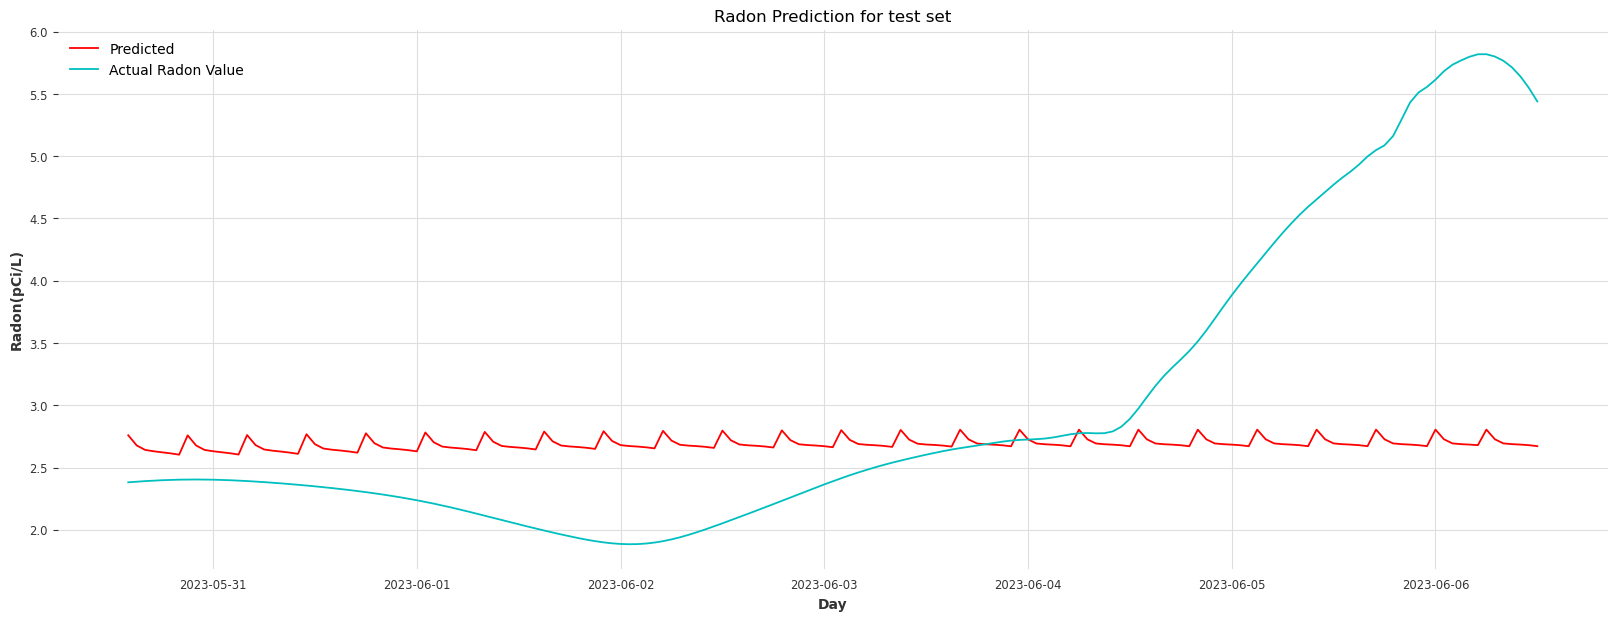

In [46]:
# plot the forecast
plt.figure(100, figsize=(20, 7))
plt.plot(dfY.index, dfY['Predicted'], color='r', label='Predicted')
plt.plot(dfY.index, dfY['Actual'], color='c', label='Actual Radon Value')
plt.legend()
plt.title('Radon Prediction for test set')
plt.xlabel('Day')
plt.ylabel('Radon(pCi/L)')
plt.show()